# Fraud in Electricity and Gas Consumption Dataset

This project targets client-level fraud detection in electricity and gas usage. We frame utility-fraud detection as a imbalanced classification problem with aggregation over sparse monthly invoices. We compare LightGBM with an ANN method to probe nonlinear effects.

# Table of Contents

1. Importing Packages
2. Loading Data
3. Exploratory Data Analysis
4. Data Engineering
5. Modeling
6. Model Performance

# 1. Importing Packages

In [ ]:
%pip install scikit-optimize

In [ ]:
%pip install scikit-optimize

In [ ]:
# --- Core libraries ---
import os
import re
from pathlib import Path
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Preprocessing & model selection ---
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# --- Evaluation metrics ---
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, classification_report,
    precision_recall_curve, roc_curve, confusion_matrix, auc
)

# --- Imbalanced data handling ---
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# --- Modeling ---
import lightgbm as lgb

# --- Optimization ---
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# --- Utilities ---
import joblib

# 2. Loading Data

* Open the Colab file browser by pressing the small folder icon on the top left of the Colab page.
* Drag and drop the `client.csv` and `invoice.csv` file into the Colab folder.

# 3. Exploratory Data Analysis

* The first five data points for each dataset
* The variables in our dataset
* The shape of our data: how many columns and rows are in each dataframe
* The data types for each variable
* Check if there are null values or extreme values
* Pre visualization

In [ ]:
# Basic Analysis for client.csv and invoice.csv
# from caas_jupyter_tools import display_dataframe_to_user # Remove custom import

# --- Load datasets ---
client_path = "/content/client.csv"
invoice_path = "/content/invoice.csv"

clients = pd.read_csv(client_path)
invoices = pd.read_csv(invoice_path)

# --- First five datapoints ---
clients_head = clients.head(5)
invoices_head = invoices.head(5)

# Display first five rows interactively
display(clients_head) # Use standard display
display(invoices_head) # Use standard display

# --- Shapes ---
clients_shape = clients.shape
invoices_shape = invoices.shape

print("Shapes (rows, columns):")
print(f"  clients: {clients_shape}")
print(f"  invoices: {invoices_shape}")

# --- Data types ---
print("\nData types — clients:")
print(clients.dtypes)

print("\nData types — invoices:")
print(invoices.dtypes)

# --- Null checks ---
print("\nNull values per column — clients:")
print(clients.isnull().sum())

print("\nNull values per column — invoices:")
print(invoices.isnull().sum())

region        date  dis     id  catg  target
0     301   13/3/1986   62   7405    11       0
1     105   11/7/1996   69   4715    11       0
2     303  14/10/2014   62  20199    11       0
3     101  25/10/2011   60  10097    11       0
4     311   30/6/2006   63  20967    12       0

id       date  tarif_type  counter_statue  reading_remarque  \
0  7405  15/2/2010          11               0                 8   
1  7405   6/3/2015          11               0                 8   
2  7405  13/2/2009          11               0                 6   
3  7405   2/5/2019          11               0                 9   
4  7405  30/5/2017          11               0                 8   

   consommation_level_4  months_number counter_type  counter_coefficient  \
0                     0              4         ELEC                    1   
1                     0              8         ELEC                    1   
2                     0              4         ELEC                    1   
3                     0             12         ELEC                    1   
4                     0              4         ELEC                    1   

   consommation_level_1  consommation_level_2  consommation_level_3  
0                   407                     0                     0  
1                   815                     0                     0  
2                   569                     0                     0  
3                  2400                   682                     0  
4                   188                     0                     0

Shapes (rows, columns):
  clients: (11741, 6)
  invoices: (194374, 12)

Data types — clients:
region     int64
date      object
dis        int64
id         int64
catg       int64
target     int64
dtype: object

Data types — invoices:
id                       int64
date                    object
tarif_type               int64
counter_statue           int64
reading_remarque         int64
consommation_level_4     int64
months_number            int64
counter_type            object
counter_coefficient      int64
consommation_level_1     int64
consommation_level_2     int64
consommation_level_3     int64
dtype: object

Null values per column — clients:
region    0
date      0
dis       0
id        0
catg      0
target    0
dtype: int64

Null values per column — invoices:
id                      0
date                    0
tarif_type              0
counter_statue          0
reading_remarque        0
consommation_level_4    0
months_number           0
counter_type            0
counter_coeffici

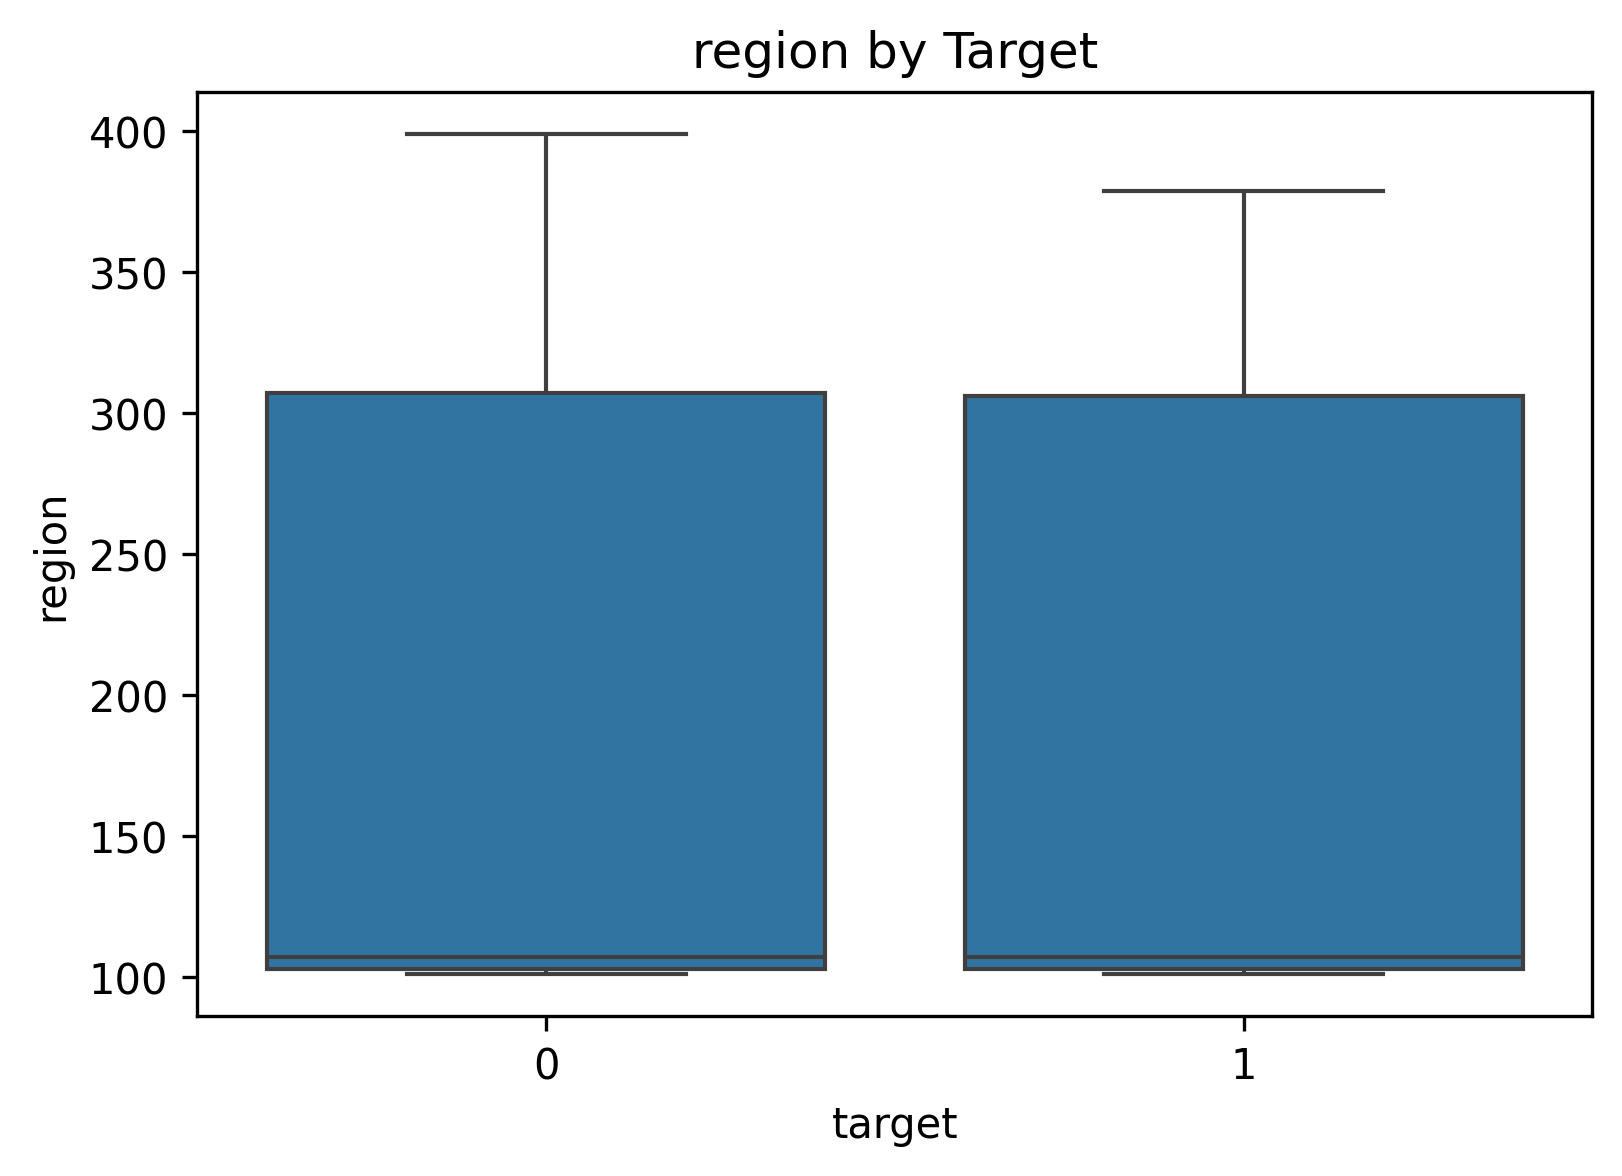

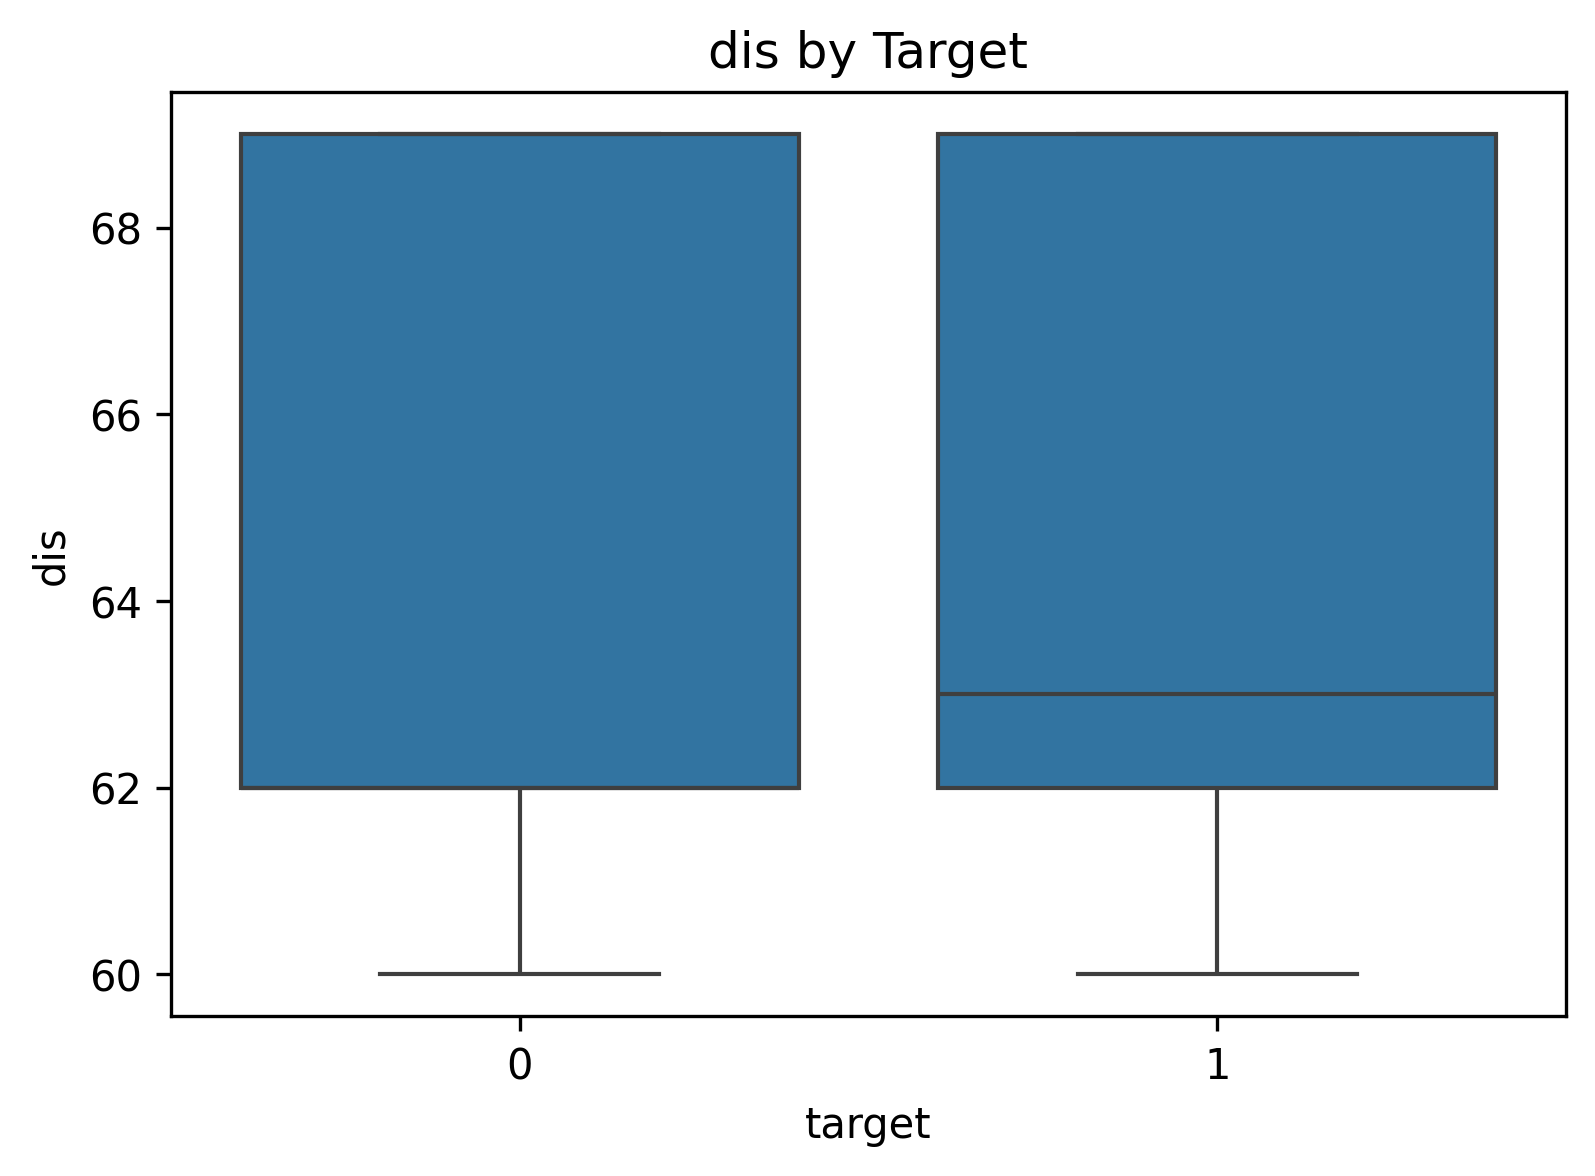

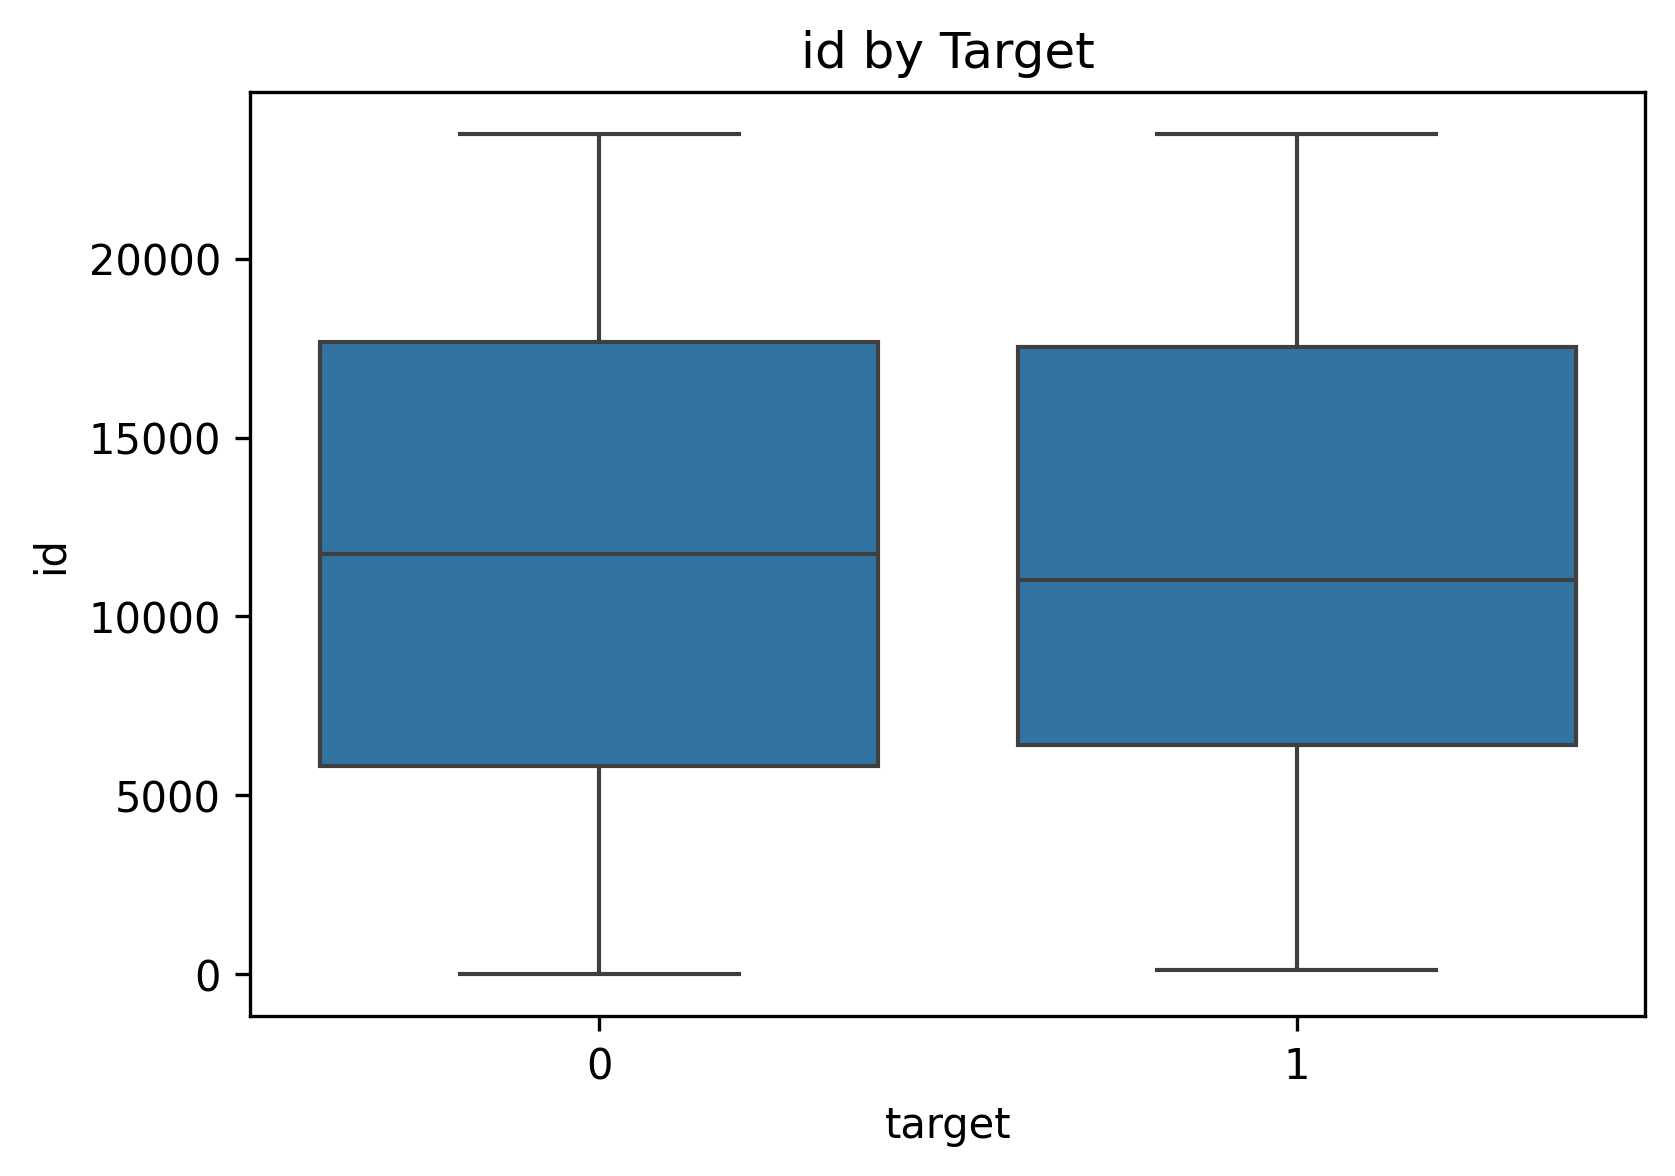

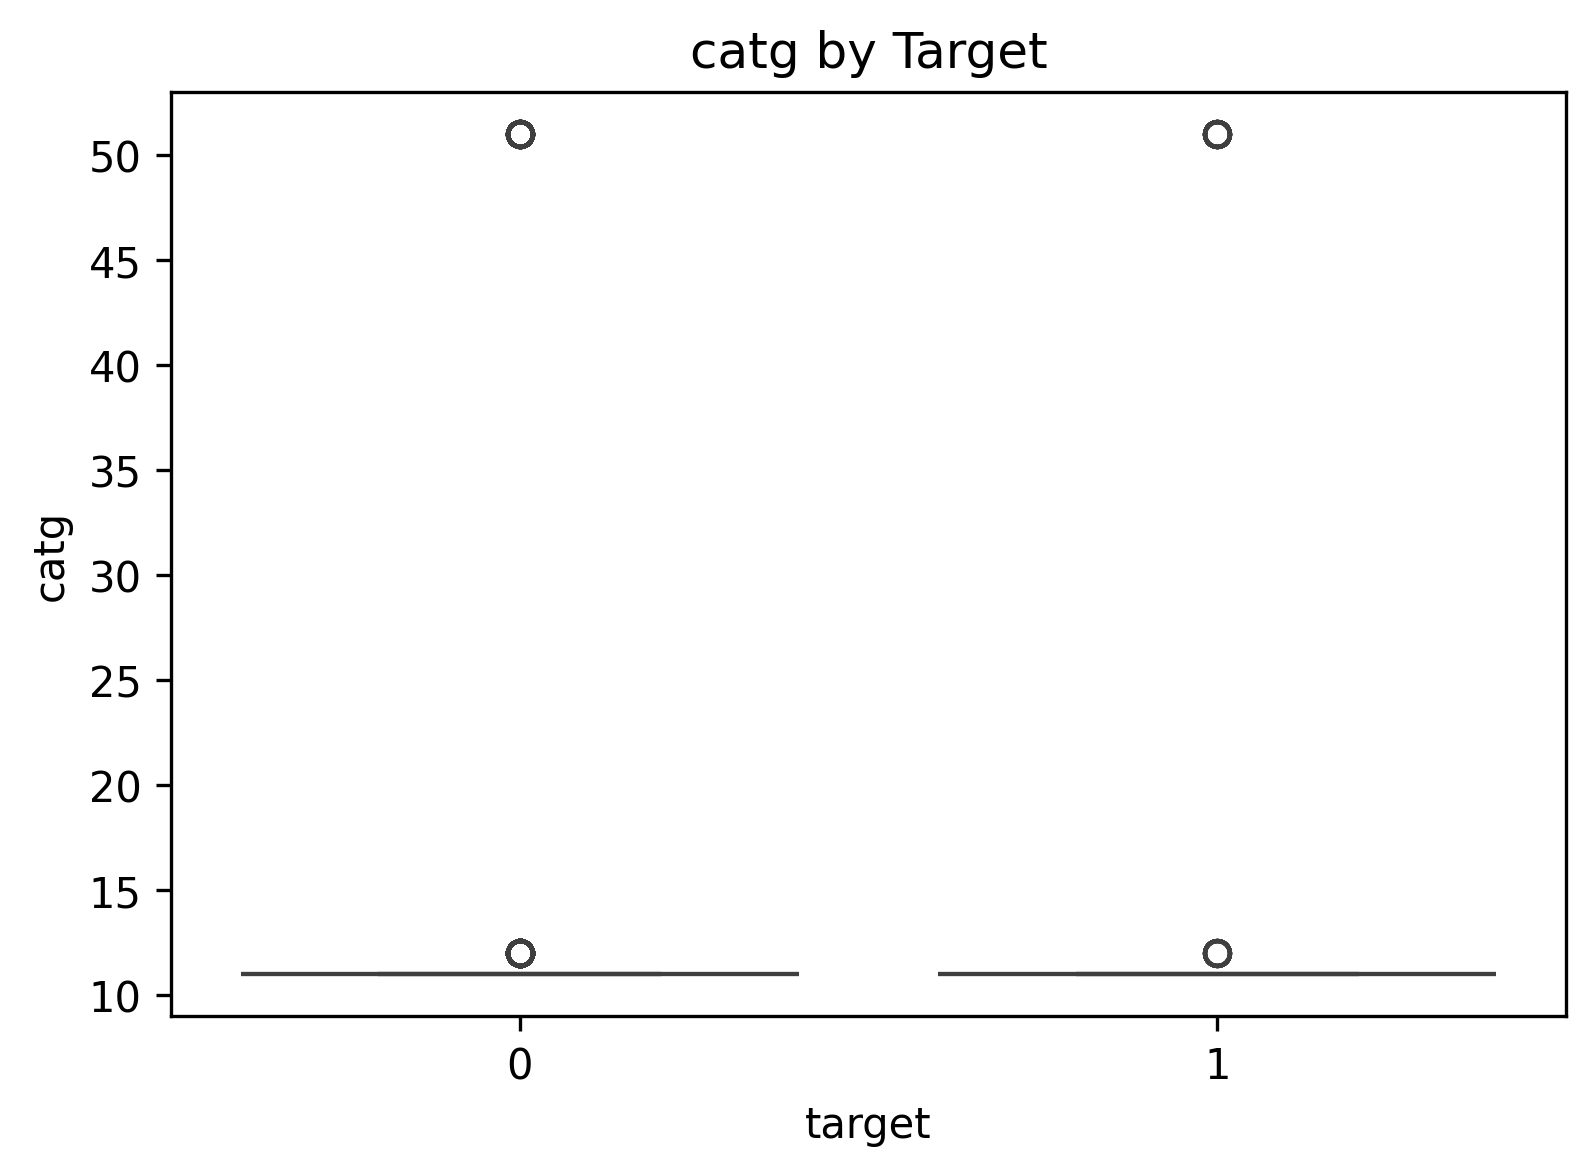


Mean values per target class:
            region        dis            id       catg
target                                                
0       206.396223  63.537413  11747.323446  11.360146
1       192.374757  64.504854  11646.349515  12.735922

Correlation of numerical features with target:
target    1.000000
catg      0.070609
dis       0.058254
id       -0.003048
region   -0.027458
Name: target, dtype: float64


In [ ]:
# Relationship with target

# List of numerical columns
numerical_cols = clients.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target from features list
numerical_cols = [col for col in numerical_cols if col != 'target']

# Drop the non-numeric 'date' column before calculating correlations
clients_numeric = clients.drop(columns=['date'], errors='ignore')


# 1. Boxplots for each numerical feature by target
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='target', y=col, data=clients)
    plt.title(f'{col} by Target')
    plt.show()

# 2. Mean values per target class
print("\nMean values per target class:")
print(clients.groupby('target')[numerical_cols].mean())

# 3. Correlation with target (point-biserial)
# Calculate correlations on the DataFrame without the 'date' column
correlations = clients_numeric.corr()['target'].sort_values(ascending=False)
print("\nCorrelation of numerical features with target:")
print(correlations)

In [ ]:
# Load
df = invoices.copy()

# Identify consommation level columns
level_cols = [c for c in df.columns if "consommation_level" in c.lower()]

anomaly_masks = []
anomaly_rows_detail = []

for col in level_cols:
    s = pd.to_numeric(df[col], errors="coerce")
    if s.notna().sum() < 20:
        anomaly_masks.append(pd.Series(False, index=df.index))
        continue

    # Extremely huge threshold = max(Q3 + 3*IQR, 99.5th percentile)
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    iqr_thr = q3 + 3 * iqr if pd.notna(iqr) else np.nan
    p995 = s.quantile(0.995)
    thr = np.nanmax([iqr_thr, p995])
    if not np.isfinite(thr):
        p99 = s.quantile(0.99)
        thr = p99 if np.isfinite(p99) else None
    if thr is None or not np.isfinite(thr):
        anomaly_masks.append(pd.Series(False, index=df.index))
        continue

    # Rare values (≤ 2 occurrences)
    value_counts = s.value_counts(dropna=True)
    rare_values = set(value_counts[value_counts <= 2].index.tolist())

    # Mask for extremely huge & rare
    mask_col = s.gt(thr) & s.isin(list(rare_values))
    anomaly_masks.append(mask_col.fillna(False))

    # Add to audit list
    for idx in df.index[mask_col.fillna(False)]:
        anomaly_rows_detail.append({
            "row_index": int(idx),
            "id": df.loc[idx, "id"] if "id" in df.columns else None,
            "date": df.loc[idx, "date"] if "date" in df.columns else None,
            "column": col,
            "value": float(s.loc[idx]) if pd.notna(s.loc[idx]) else None,
            "threshold_used": float(thr),
            "value_count_in_column": int(value_counts.get(s.loc[idx], 0)),
        })

# Union across all consommation levels
any_anomaly = anomaly_masks[0].copy() if anomaly_masks else pd.Series(False, index=df.index)
for m in anomaly_masks[1:]:
    any_anomaly |= m

removed_df = df[any_anomaly].copy()
clean_df = df[~any_anomaly].copy()

# Save outputs
clean_path = "/content/invoice_cleaned.csv"
audit_path = "/content/removed_anomalies_audit.csv"
clean_df.to_csv(clean_path, index=False)
pd.DataFrame(anomaly_rows_detail).sort_values(["column","value"], ascending=[True, False]).to_csv(audit_path, index=False)

print({
    "input_rows": len(df),
    "anomaly_rows_removed": int(any_anomaly.sum()),
    "cleaned_rows": len(clean_df),
    "cleaned_csv": clean_path,
    "audit_csv": audit_path,
    "consommation_level_columns": level_cols
})


{'input_rows': 194374, 'anomaly_rows_removed': 2786, 'cleaned_rows': 191588, 'cleaned_csv': '/content/invoice_cleaned.csv', 'audit_csv': '/content/removed_anomalies_audit.csv', 'consommation_level_columns': ['consommation_level_4', 'consommation_level_1', 'consommation_level_2', 'consommation_level_3']}


# 4. Data Engineering

Here we did the following:
* 4.1 Feature creation
* 4.2 Splitting the data into training and validation sets
* 4.3 Scaling of the numerical features and Encoding of the non-numerical features
* 4.4 Feature selection
* 4.5 Dataset update
* 4.6 Post data engineering visualization


## 4.1 Feature creation

In [ ]:
# Merge with client meta and save final matrix; drop all-NaN columns (to avoid empties).

dfc = pd.read_csv("/content/client.csv").rename(columns={"dis":"Dis"})
dfc["join_date"] = pd.to_datetime(dfc["date"], errors="coerce")
client_meta = dfc[["id","Dis","catg","region","join_date","target"]].drop_duplicates("id").set_index("id")

# Rebuild 'feat' properly by reading from earlier code's variable is not possible now;
# so recompute quickly but compactly (no top-5 to keep it fast here), then join and save.

dfi = pd.read_csv("/content/invoice_cleaned.csv")
dfi["invoice_date"] = pd.to_datetime(dfi["date"], errors="coerce")
dfi["invoice_month"] = dfi["invoice_date"].dt.month
dfi["invoice_year"]  = dfi["invoice_date"].dt.year
dfi["is_weekday"]    = dfi["invoice_date"].dt.dayofweek <= 4
dfi = dfi.sort_values(["id","invoice_date"])
dfi["delta_time"] = dfi.groupby("id")["invoice_date"].diff().dt.total_seconds()/86400.0
for col in ["old_index","new_index"]:
    if col in dfi.columns and not pd.api.types.is_numeric_dtype(dfi[col]):
        dfi[col] = pd.to_numeric(dfi[col], errors="coerce")
dfi["delta_index"] = dfi["new_index"] - dfi["old_index"] if set(["old_index","new_index"]).issubset(dfi.columns) else np.nan
# levels
level_cols = [c for c in dfi.columns if re.fullmatch(r"consommation_level_[1-4]", c)]
for c in level_cols:
    if not pd.api.types.is_numeric_dtype(dfi[c]):
        dfi[c] = pd.to_numeric(dfi[c], errors="coerce")
if level_cols:
    dfi["consommation_total"] = dfi[level_cols].sum(axis=1, skipna=True)

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3473: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3473: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
g = dfi.groupby("id", dropna=False)
feat = pd.DataFrame(index=g.size().index)
feat["txn_count"] = g.size()

num_cols = [c for c in ["old_index","new_index","months_number","invoice_month","invoice_year",
                        "delta_index","delta_time"] + level_cols + (["consommation_total"] if "consommation_total" in dfi.columns else [])
            if c in dfi.columns]

for c in num_cols:
    agg = g[c].agg(["min","max","mean","std","median"])
    feat[f"{c}_min"]    = agg["min"]
    feat[f"{c}_max"]    = agg["max"]
    feat[f"{c}_mean"]   = agg["mean"]
    feat[f"{c}_std"]    = agg["std"]
    feat[f"{c}_median"] = agg["median"]
    feat[f"{c}_range"]  = agg["max"] - agg["min"]

feat["is_weekday_rate"] = g["is_weekday"].mean()

In [ ]:
feature_matrix = client_meta.join(feat, how="left")
# drop all-NaN columns
feature_matrix = feature_matrix.loc[:, ~feature_matrix.isna().all()]
OUT = "/content/feature_matrix_flowchart_exact.csv"
feature_matrix.to_csv(OUT)

display(feature_matrix.head(50))
print({"shape": feature_matrix.shape, "out": OUT, "levels": level_cols})

Dis  catg  region  join_date  target  txn_count  months_number_min  \
id                                                                          
7405    62    11     301 1986-03-13       0       18.0                4.0   
4715    69    11     105 1996-07-11       0       20.0                4.0   
20199   62    11     303 2014-10-14       0       14.0                2.0   
10097   60    11     101 2011-10-25       0        2.0                4.0   
20967   63    12     311 2006-06-30       0       13.0                2.0   
11122   60    11     101 2009-05-28       0       26.0                2.0   
811     69    11     104 2002-10-22       0        9.0                4.0   
392     69    11     104 1999-05-25       0        6.0                4.0   
747     60    11     101 2006-04-25       0       14.0                2.0   
4814    63    11     311 1999-11-30       0       20.0                4.0   
8768    69    11     104 2011-11-17       0       22.0                2.0   
8483    69    51     104 2017-07-13       0        8.0                1.0   
22656   63    11     311 2014-10-17       0        8.0                2.0   
23139   62    11     301 1981-12-30       0        6.0                4.0   
2267    60    11     101 1997-12-22       0        7.0                4.0   
3657    62    11     301 1983-10-17       0       27.0                4.0   
17624   63    11     308 2012-11-07       1       18.0                4.0   
7716    69    11     104 2015-07-09       0       12.0                4.0   
113     62    11     307 2009-09-16       1       23.0                4.0   
16687   63    11     313 2010-03-03       0       27.0                2.0   
5102    62    11     303 2016-06-22       0        8.0                4.0   
3216    60    11     101 1979-04-16       0        5.0                2.0   
3451    60    11     101 2004-02-23       0        5.0                4.0   
16509   63    11     101 2010-10-26       0       27.0                4.0   
5253    62    11     303 2003-03-12       0       20.0                4.0   
4903    62    11     303 2007-02-19       0       27.0                2.0   
20435   69    11     104 2012-12-20       0       28.0                2.0   
7539    62    11     310 1996-12-31       0       30.0                2.0   
6212    62    11     304 2014-10-14       0       15.0                2.0   
12333   69    11     104 2002-04-08       0        5.0                1.0   
1758    63    11     312 2000-05-11       0       19.0                2.0   
14092   60    11     101 2016-08-29       0        8.0                4.0   
9315    69    11     104 2011-05-13       0       10.0                2.0   
22380   60    11     101 2011-11-28       0       18.0                4.0   
10407   62    11     301 2014-12-26       0       12.0                4.0   
18020   62    11     309 2004-11-29       0       11.0                4.0   
23413   62    11     310 1993-12-06       0        6.0                4.0   
12004   60    11     101 2007-09-13       0       17.0                2.0   
16969   60    11     101 2012-05-16       0       18.0                2.0   
12292   60    11     101 1977-03-05       0        5.0                2.0   
4038    63    11     312 2016-02-04       0       22.0                4.0   
22667   62    11     304 1996-10-28       0        6.0                4.0   
12311   62    11     307 2012-09-10       0       20.0                2.0   
21168   60    11     101 2016-12-28       0        6.0                4.0   
9978    63    11     313 2011-08-10       0       10.0                4.0   
1791    62    11     309 2009-11-06       0       17.0                1.0   
2458    63    11     311 2003-12-31       0        6.0                2.0   
4750    62    11     301 2013-08-30       0       16.0                4.0   
1492    62    11     305 1992-04-22       0       29.0                4.0   
2278    63    11     312 1990-12-27       1       23.0                2.0   

  

{'shape': (11741, 61), 'out': '/content/feature_matrix_flowchart_exact.csv', 'levels': ['consommation_level_4', 'consommation_level_1', 'consommation_level_2', 'consommation_level_3']}


## 4.2 Split Training/Testing Sets

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # example model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
X = feature_matrix.drop(columns=['target'])
y = feature_matrix['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Convert to DataFrames if not already
X_train = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train, columns=['target'])
y_test = pd.DataFrame(y_test, columns=['target'])


## 4.3 Scaling of the numerical features and Encoding of the non-numerical features

In [ ]:
# --- Identify column types on TRAIN only ---
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# --- 1) Scale numerics (fit on train, apply to test) ---
scaler = StandardScaler()
X_train_num = pd.DataFrame(
    scaler.fit_transform(X_train[num_cols]),
    columns=num_cols,
    index=X_train.index,
)
X_test_num = pd.DataFrame(
    scaler.transform(X_test[num_cols]),
    columns=num_cols,
    index=X_test.index,
)

# --- 2) One-hot encode categoricals (create train columns, then align test) ---
X_train_cat = pd.get_dummies(X_train[cat_cols], drop_first=False)
train_cat_cols = X_train_cat.columns
X_test_cat = pd.get_dummies(X_test[cat_cols], drop_first=False).reindex(
    columns=train_cat_cols, fill_value=0
)

# --- 3) Concatenate scaled numerics + encoded categoricals ---
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_df = pd.concat([X_test_num,  X_test_cat],  axis=1)

# X_train_proc / X_test_proc are now ready for modeling; y_* unchanged


## 4.4 Feature selection

In [ ]:
# ----------------------------------
# Load your split data (already in memory in your snippet)
# X_train, y_train assumed present. If not, uncomment:
# X_train = pd.read_csv("/mnt/data/X_train.csv")
# y_train  = pd.read_csv("/mnt/data/y_train.csv").squeeze("columns")
# ----------------------------------

# Combine training features and target into one DataFrame
df = pd.concat([X_train.copy(), y_train.copy()], axis=1)

id_col = "id" if "id" in df.columns else None
target_col = "target" if "target" in df.columns else None
if target_col is None:
    raise RuntimeError("No 'target' column found.")

# Use rows with target
df = df[~df[target_col].isna()].copy()

# Numeric features only
num = df.select_dtypes(include=[np.number]).copy()

# --- remove min/max/mean/median of invoice_month/year,
#     and also month_number {max, range, mean} ---
agg_tokens = ["min", "max", "mean", "median"]

def is_time_agg(col: str) -> bool:
    c = col.lower()
    cond_invoice_agg = (("invoice_month" in c) or ("invoice_year" in c)) and any(tok in c for tok in agg_tokens)
    cond_monthnum_special = (("month_number" in c) or ("months_number" in c)) and (
        ("max" in c) or ("range" in c) or ("mean" in c)
    )
    return cond_invoice_agg or cond_monthnum_special

to_drop_time_aggs = [c for c in num.columns if c not in {target_col, id_col} and is_time_agg(c)]
if to_drop_time_aggs:
    num = num.drop(columns=to_drop_time_aggs, errors="ignore")

# Feature list after removal
feat_all = [c for c in num.columns if c not in [target_col] + ([id_col] if id_col else [])]
n_all = len(feat_all)

# r and r^2 to target
r_list = []
t = num[target_col]
for c in feat_all:
    r = num[c].corr(t)
    r2 = None if pd.isna(r) else float(r*r)
    r_list.append({"feature": c, "r_to_target": None if pd.isna(r) else float(r), "r2_to_target": r2})
r_df = pd.DataFrame(r_list).sort_values("r2_to_target", ascending=False)

def reduce_collinearity(df_num, features, target_abs_corr, collin_thresh):
    if len(features) <= 1:
        return features
    C = df_num[features].corr().abs()
    keep = set(features)
    cols = C.columns.tolist()
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            a, b = cols[i], cols[j]
            if a in keep and b in keep:
                v = C.iat[i, j]
                if pd.notna(v) and v >= collin_thresh:
                    ca = target_abs_corr.get(a, 0.0)
                    cb = target_abs_corr.get(b, 0.0)
                    if ca > cb: keep.discard(b)
                    elif cb > ca: keep.discard(a)
                    else: keep.discard(sorted([a,b])[1])
    return sorted(list(keep))

# Start thresholds (lower R2, softer collinearity)
r2_thresh = 0.001
collin_thresh = 0.85
target_keep_ratio = 0.60

sel_r2 = r_df[r_df["r2_to_target"].fillna(0) >= r2_thresh]["feature"].tolist()
abs_corr_all = r_df.set_index("feature")["r_to_target"].abs().fillna(0).to_dict()
sel_combined = reduce_collinearity(num, sel_r2, abs_corr_all, collin_thresh)

# Auto-tune to ~60% keep ratio
def keep_ratio(features): return len(features)/n_all if n_all>0 else 0.0
iters = 0
while keep_ratio(sel_combined) < target_keep_ratio and iters < 10:
    r2_thresh *= 0.5
    collin_thresh = min(0.95, collin_thresh + 0.03)
    sel_r2 = r_df[r_df["r2_to_target"].fillna(0) >= r2_thresh]["feature"].tolist()
    sel_combined = reduce_collinearity(num, sel_r2, abs_corr_all, collin_thresh)
    iters += 1

# ---------------------------
# Save ONLY combined selection
# ---------------------------
OUT_DIR = "/content"
pd.DataFrame({"feature": sel_combined}).to_csv(f"{OUT_DIR}/selected_combined_features.csv", index=False)

base = ([id_col] if id_col else []) + [target_col]
df_comb = df[base + sel_combined].copy()
df_comb.to_csv(f"{OUT_DIR}/dataset_selected_combined.csv", index=False)

print({
    "n_all_numeric_features": n_all,
    "n_removed_time_aggs": len(to_drop_time_aggs),
    "r2_thresh_final": r2_thresh,
    "collin_thresh_final": collin_thresh,
    "n_selected_combined": len(sel_combined),
    "keep_ratio_combined": keep_ratio(sel_combined),
    "saved": [
        f"{OUT_DIR}/selected_combined_features.csv",
        f"{OUT_DIR}/dataset_selected_combined.csv"
    ]
})


{'n_all_numeric_features': 48, 'n_removed_time_aggs': 11, 'r2_thresh_final': 6.25e-05, 'collin_thresh_final': 0.95, 'n_selected_combined': 30, 'keep_ratio_combined': 0.625, 'saved': ['/content/selected_combined_features.csv', '/content/dataset_selected_combined.csv']}


## 4.5 Dataset Update

In [ ]:
#Load the new training dataset
train_path = "/content/dataset_selected_combined.csv"
X_train_df = pd.read_csv(train_path)
print(f"[INFO] Loaded training data: {X_train_df.shape} from {train_path}")

#Load the list of selected feature names
features_path = "/content/selected_combined_features.csv"
feature_list_df = pd.read_csv(features_path)

# Handle both single-column and multi-column CSVs
if feature_list_df.shape[1] == 1:
    feature_names = feature_list_df.iloc[:, 0].tolist()
else:
    # If it contains multiple columns, use the first column or adjust manually
    feature_names = feature_list_df.columns.tolist()

print(f"[INFO] Loaded {len(feature_names)} feature names from {features_path}")

#Filter X_train_df to only keep selected features
X_train_df = X_train_df[[c for c in feature_names if c in X_train_df.columns]]
print(f"[INFO] Filtered X_train_df to shape: {X_train_df.shape}")

#Filter X_test_df to match the same feature set
missing_cols = [c for c in feature_names if c not in X_test_df.columns]
if missing_cols:
    print(f"⚠️ Warning: {len(missing_cols)} features missing in X_test_df: {missing_cols[:5]}...")

X_test_df = X_test_df[[c for c in feature_names if c in X_test_df.columns]]
print(f"[INFO] Filtered X_test_df to shape: {X_test_df.shape}")

#Save both as new CSVs (replace existing files)
out_train_path = "/content/X_train.csv"
out_test_path = "/content/X_test.csv"
out_y_train_path = "/content/y_train.csv"
out_y_test_path = "/content/y_test.csv"

X_train_df.to_csv(out_train_path, index=False)
X_test_df.to_csv(out_test_path, index=False)
y_train.to_csv(out_y_train_path, index=False)
y_test.to_csv(out_y_test_path, index=False)

print("\n[Saved]")
print(f"X_train_df → {out_train_path}  ({X_train_df.shape})")
print(f"X_test_df  → {out_test_path}  ({X_test_df.shape})")
print(f"y_train  → {out_y_train_path}  ({y_train.shape})")
print(f"y_test  → {out_y_test_path}  ({y_test.shape})")


[INFO] Loaded training data: (9392, 31) from /content/dataset_selected_combined.csv
[INFO] Loaded 30 feature names from /content/selected_combined_features.csv
[INFO] Filtered X_train_df to shape: (9392, 30)
[INFO] Filtered X_test_df to shape: (2349, 30)

[Saved]
X_train_df → /content/X_train.csv  ((9392, 30))
X_test_df  → /content/X_test.csv  ((2349, 30))
y_train  → /content/y_train.csv  ((9392,))
y_test  → /content/y_test.csv  ((2349,))


## 4.6 Post data engineering visualization

* Boxplots: Compared distributions of key numerical features across target classes.
* KDE plots: Visualized overall distribution differences for numerical variables by target.
* Bar plots: Showed average target rates across categorical features.
* Heatmap: Displayed correlations among numerical features and the target.

In [ ]:
target = 'target'  # change this to your actual target column name


categorical_features = ['Dis', 'catg', 'region']
# Exclude 'join_date' from numeric features as it's a datetime column

df_comb_1 = df_comb.copy()
df_comb_1 = df_comb_1.reset_index(drop=True)

numeric_features_1 = [

    "delta_time_min",
    "delta_time_range",
    "delta_time_std",
    "invoice_month_range",
    "invoice_year_std",
    "txn_count"
]
numeric_features_2 = [
    "consommation_level_1_mean",
    "consommation_level_1_median",
    "consommation_level_1_min",
    "consommation_level_1_range",
    "consommation_level_2_mean",
    "consommation_level_2_std",
    "consommation_level_3_mean",
    "consommation_level_3_median",
    "consommation_level_3_min",
    "consommation_level_3_range",
    "consommation_level_4_mean",
    "consommation_level_4_median",
    "consommation_level_4_min",
    "consommation_level_4_range",
    "consommation_total_mean",
    "consommation_total_median",
    "consommation_total_min",
    "consommation_total_std",
    "delta_time_mean",
    "delta_time_min",
    "delta_time_range",
    "delta_time_std",
    "invoice_month_range",
    "invoice_year_std",
    "is_weekday_rate",
    "txn_count"
]

In [ ]:
target = 'target'  # change this to your actual target column name


categorical_features = ['Dis', 'catg', 'region']
# Exclude 'join_date' from numeric features as it's a datetime column

df_comb_1 = df_comb.copy()
df_comb_1 = df_comb_1.reset_index(drop=True)

numeric_features_1 = [
    "consommation_level_1_mean",
    "consommation_level_1_median",
    "delta_time_min",
    "delta_time_range",
    "delta_time_std",
    "invoice_month_range",
    "invoice_year_std",
    "txn_count"
]
numeric_features_2 = [
    "consommation_level_1_mean",
    "consommation_level_1_median",
    "consommation_level_1_min",
    "consommation_level_1_range",
    "consommation_level_2_mean",
    "consommation_level_2_std",
    "consommation_level_3_mean",
    "consommation_level_3_median",
    "consommation_level_3_min",
    "consommation_level_3_range",
    "consommation_level_4_mean",
    "consommation_level_4_median",
    "consommation_level_4_min",
    "consommation_level_4_range",
    "consommation_total_mean",
    "consommation_total_median",
    "consommation_total_min",
    "consommation_total_std",
    "delta_time_mean",
    "delta_time_min",
    "delta_time_range",
    "delta_time_std",
    "invoice_month_range",
    "invoice_year_std",
    "is_weekday_rate",
    "txn_count"
]

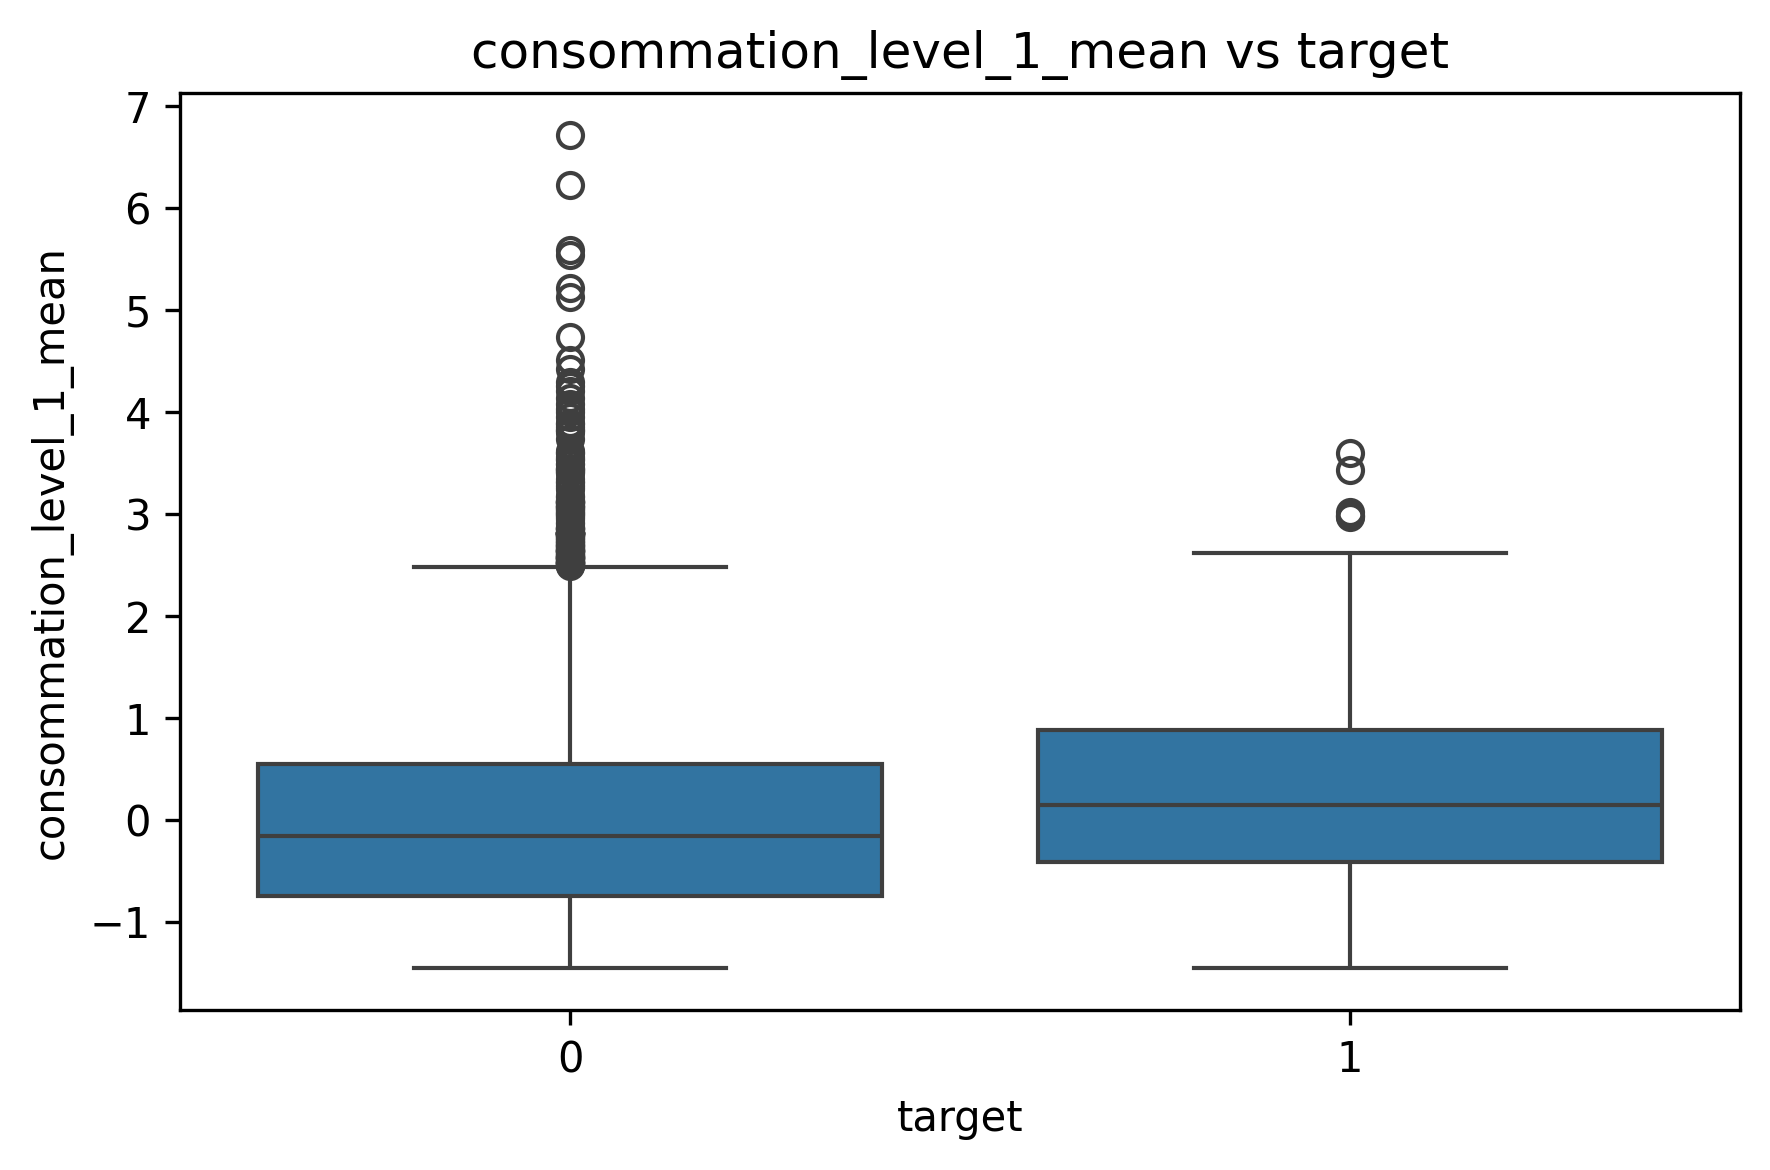

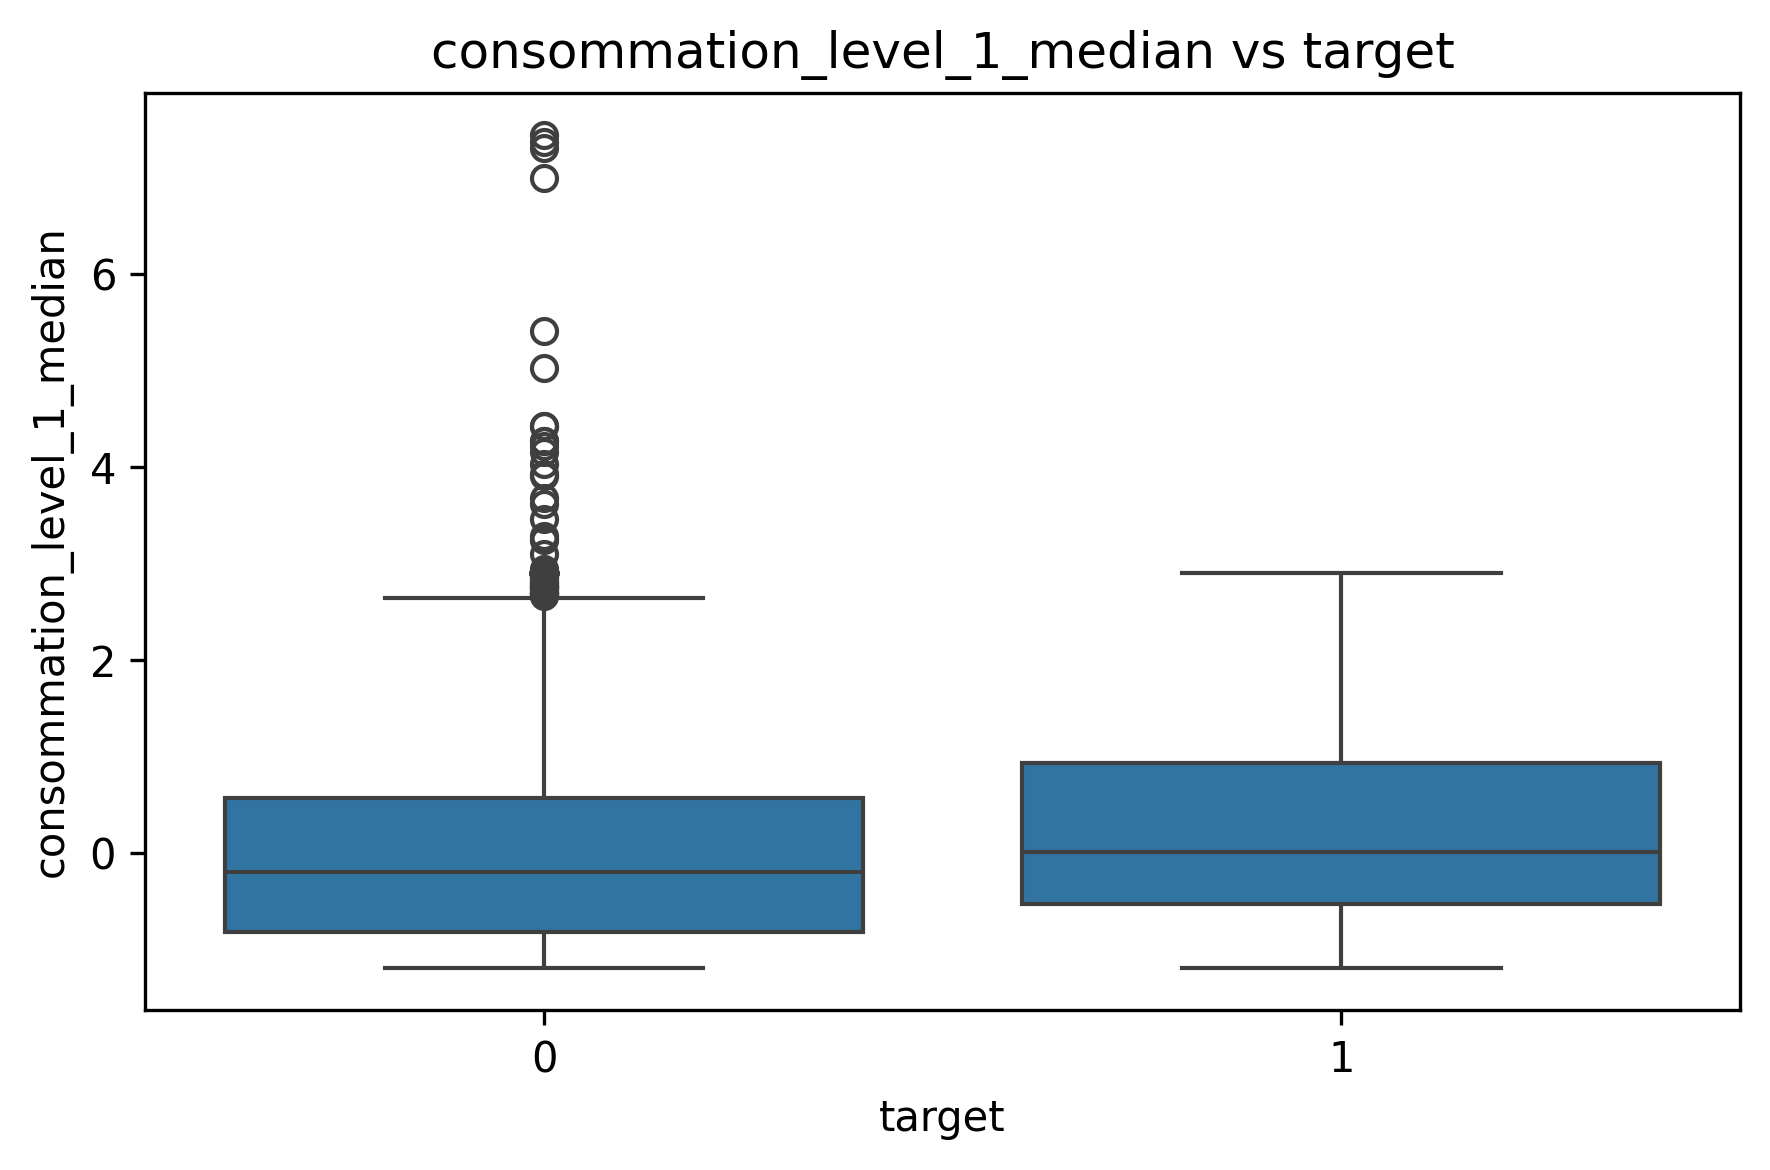

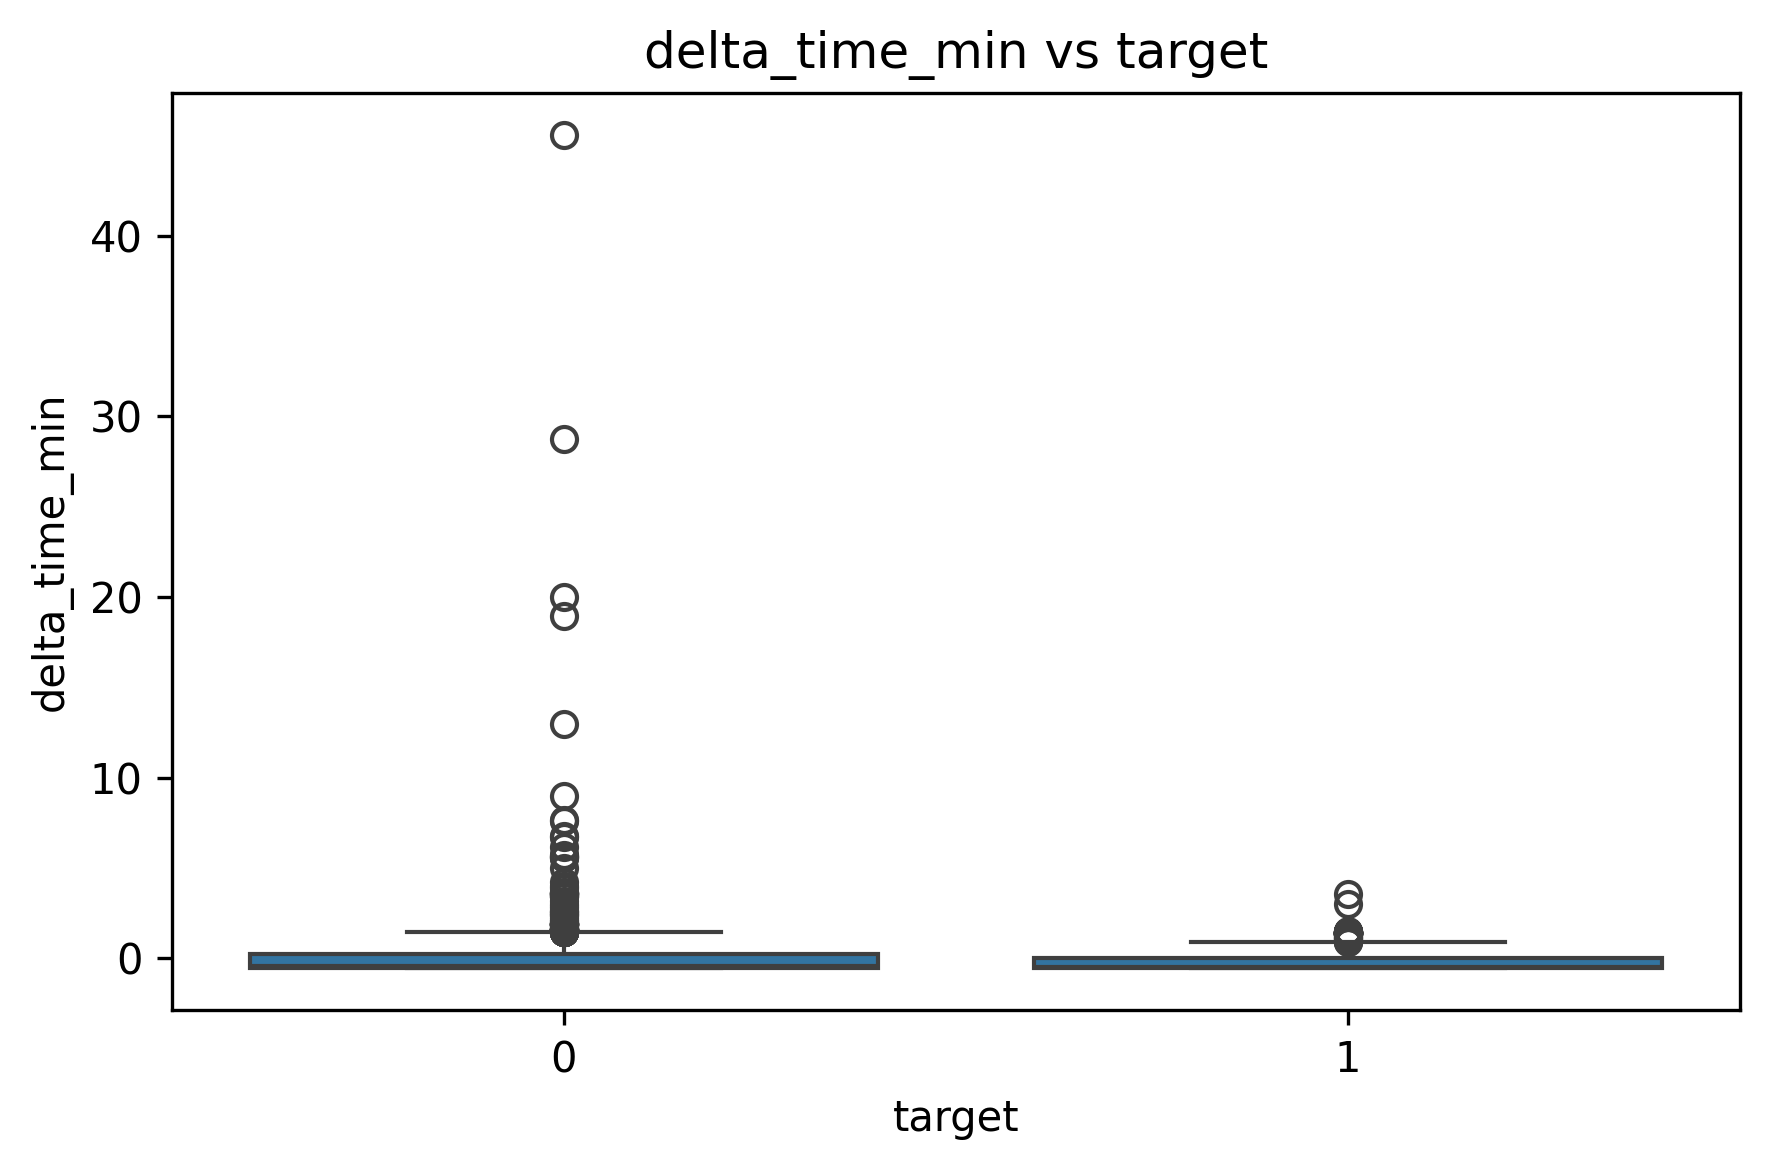

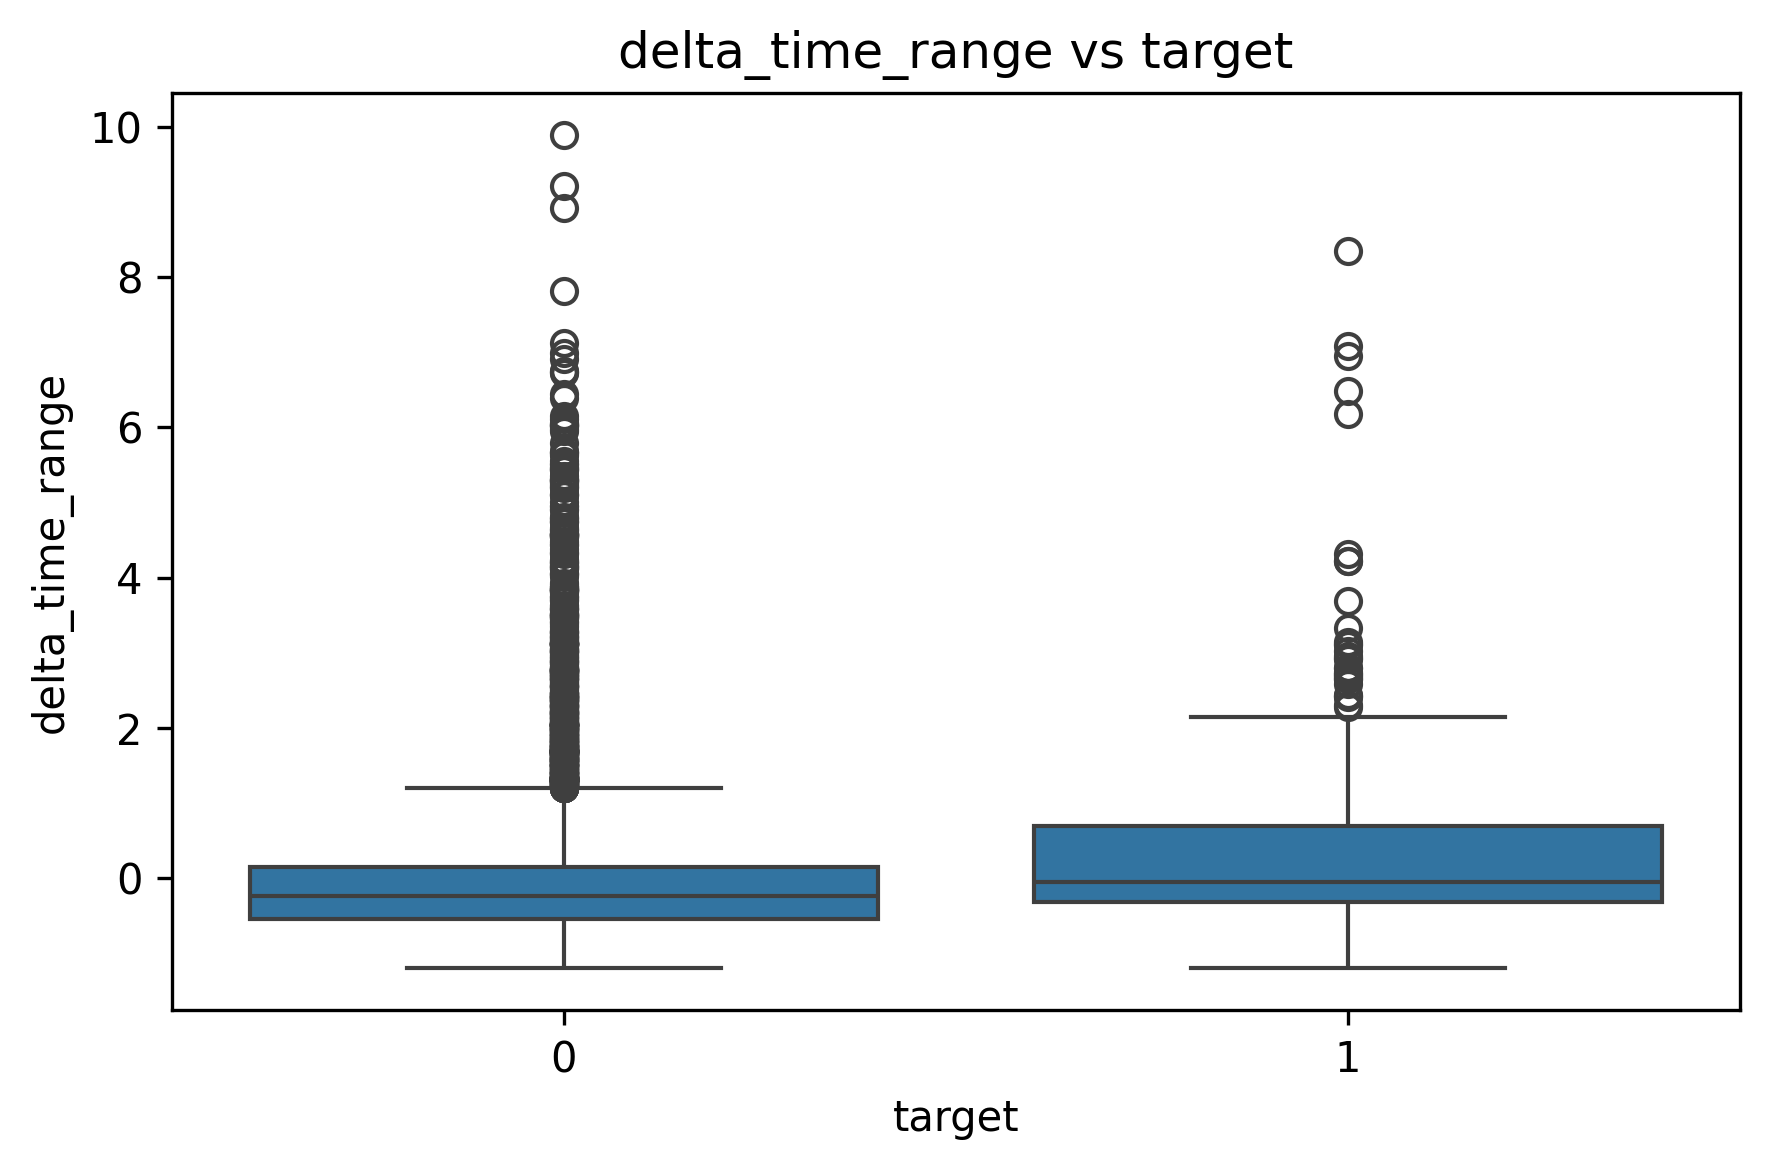

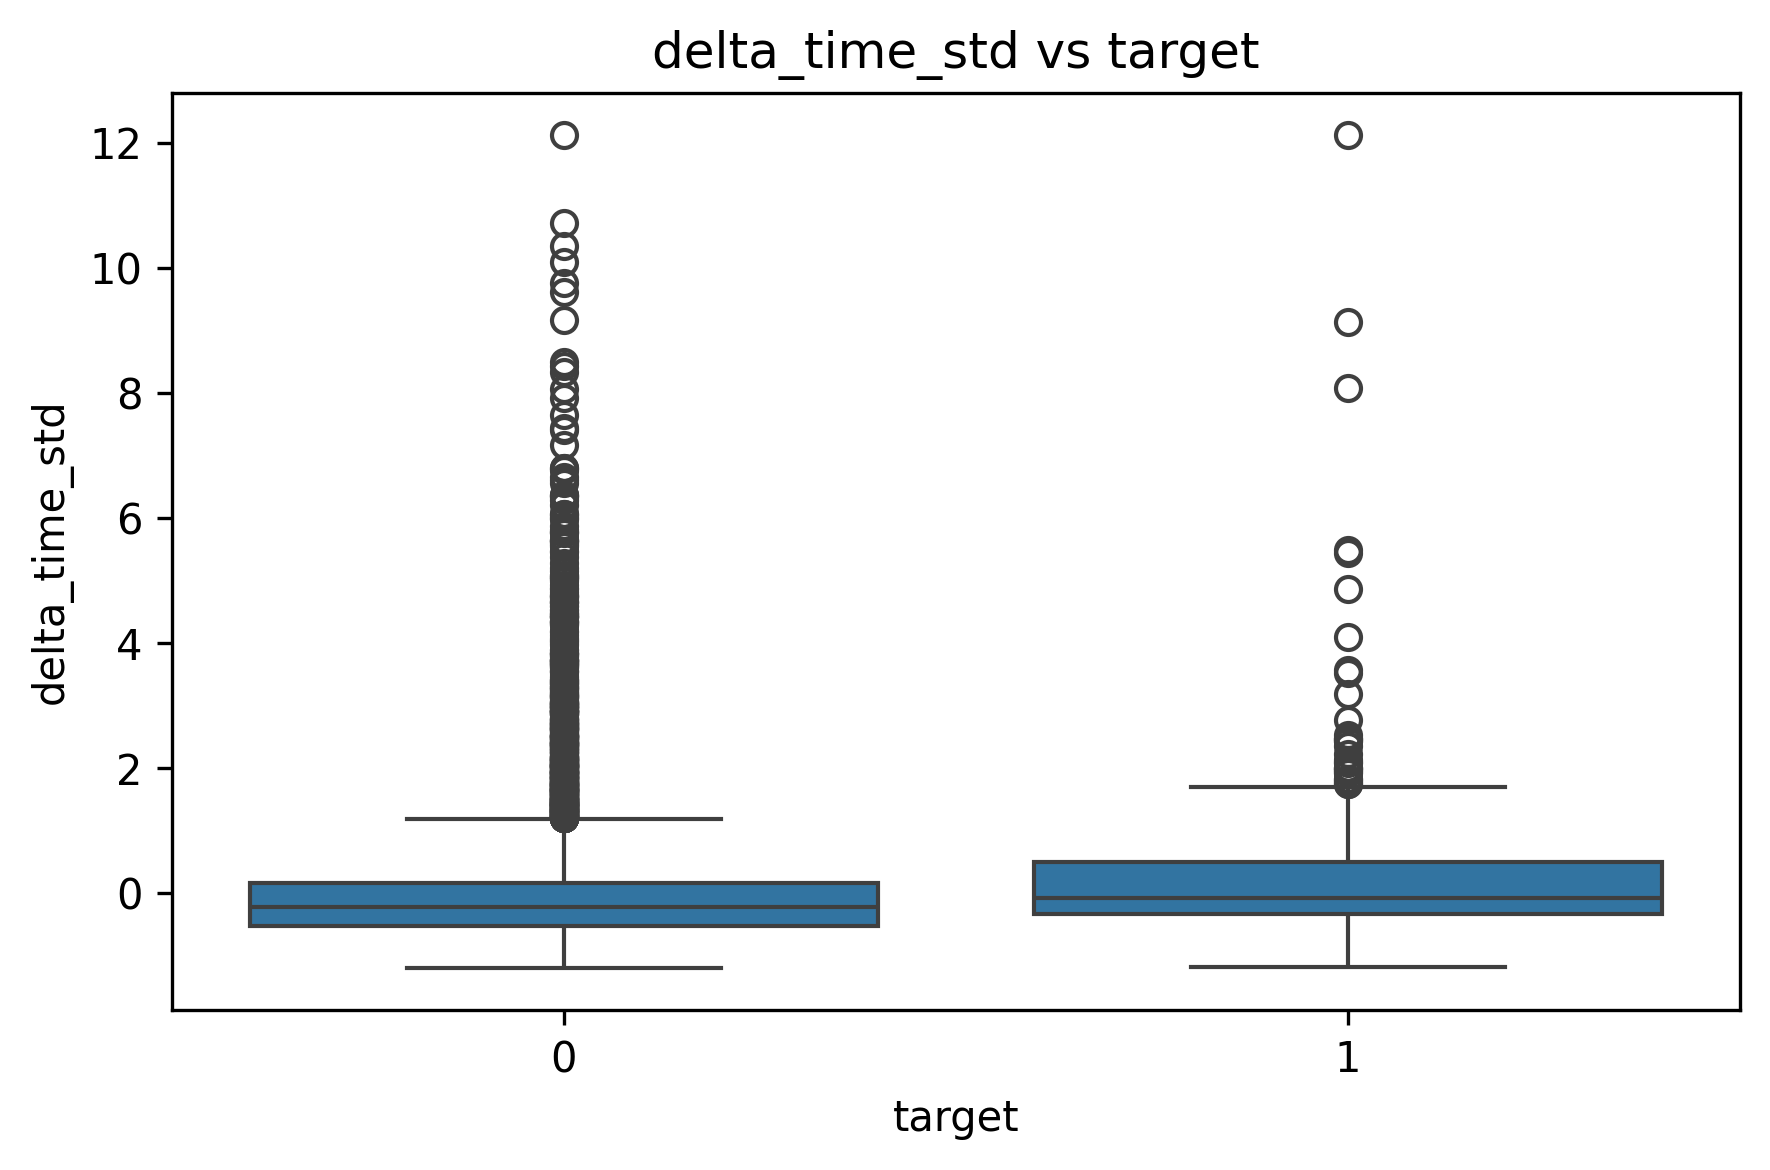

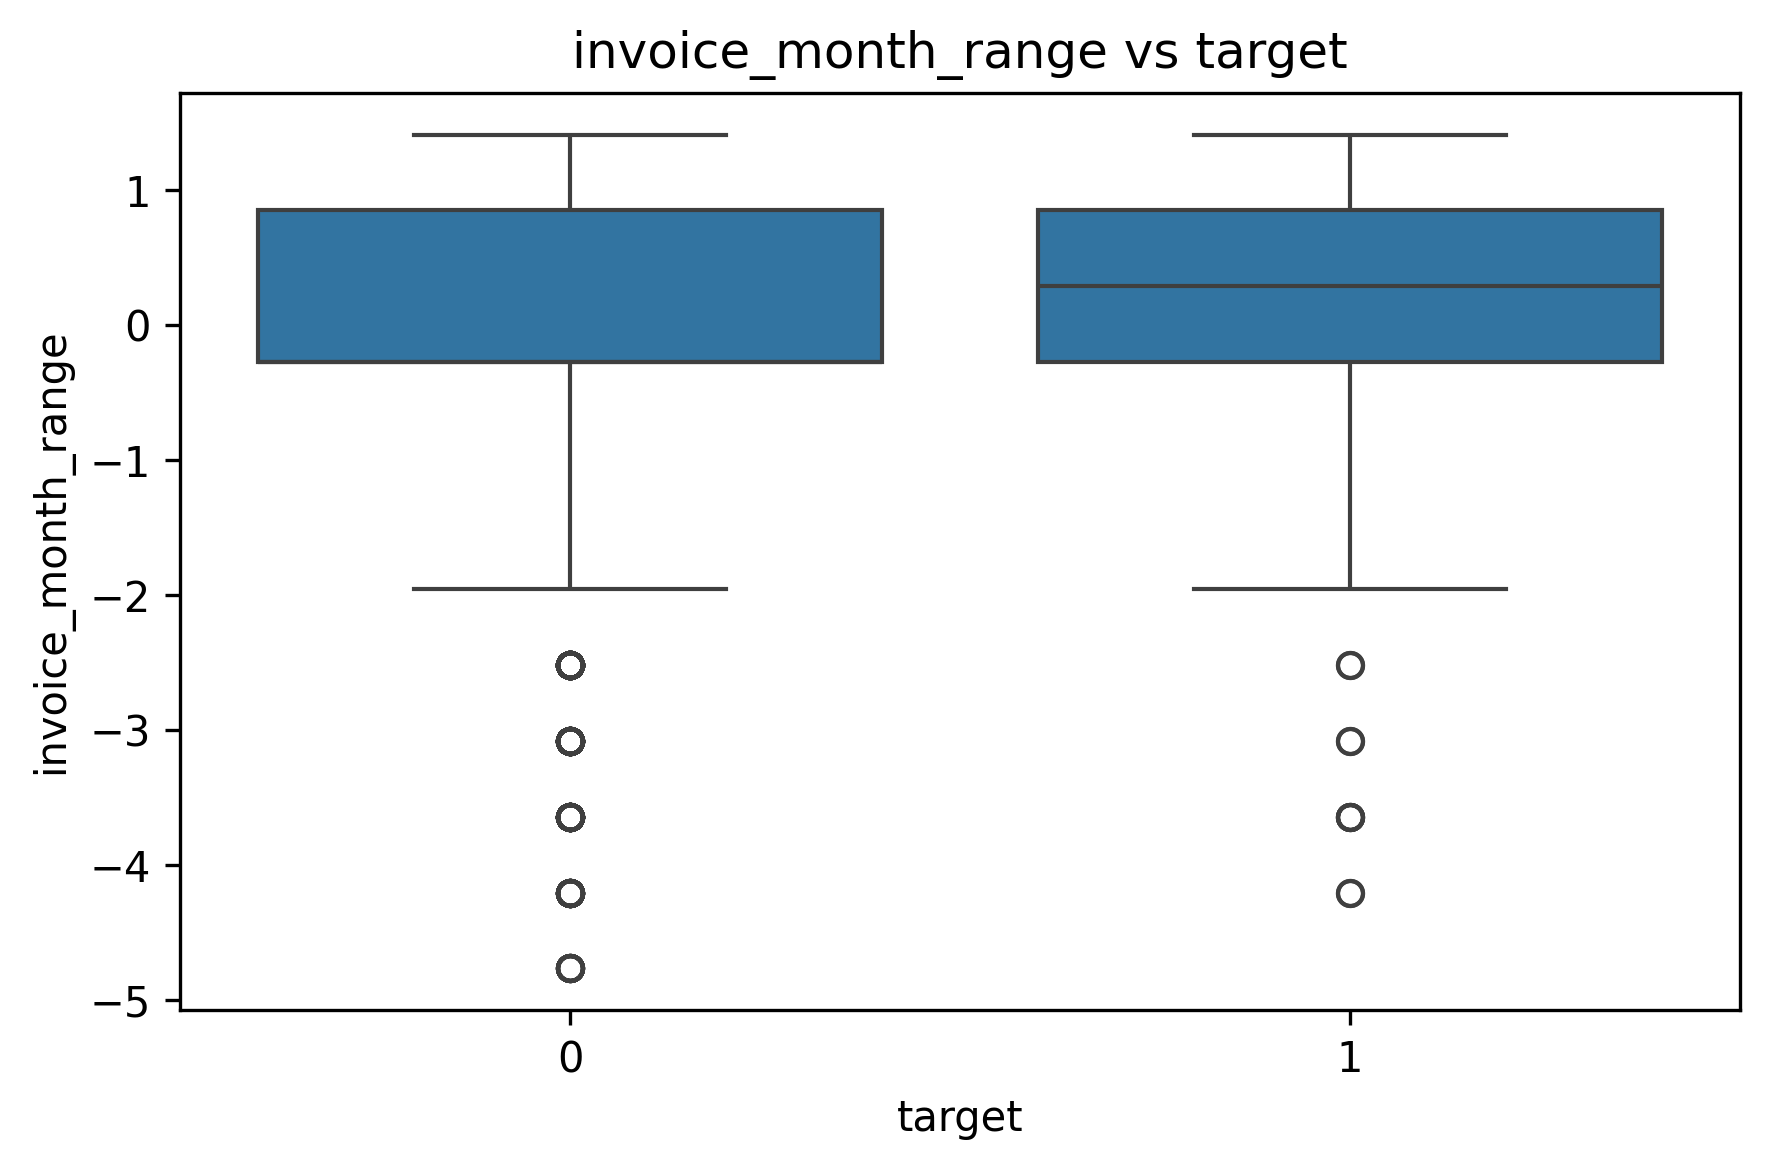

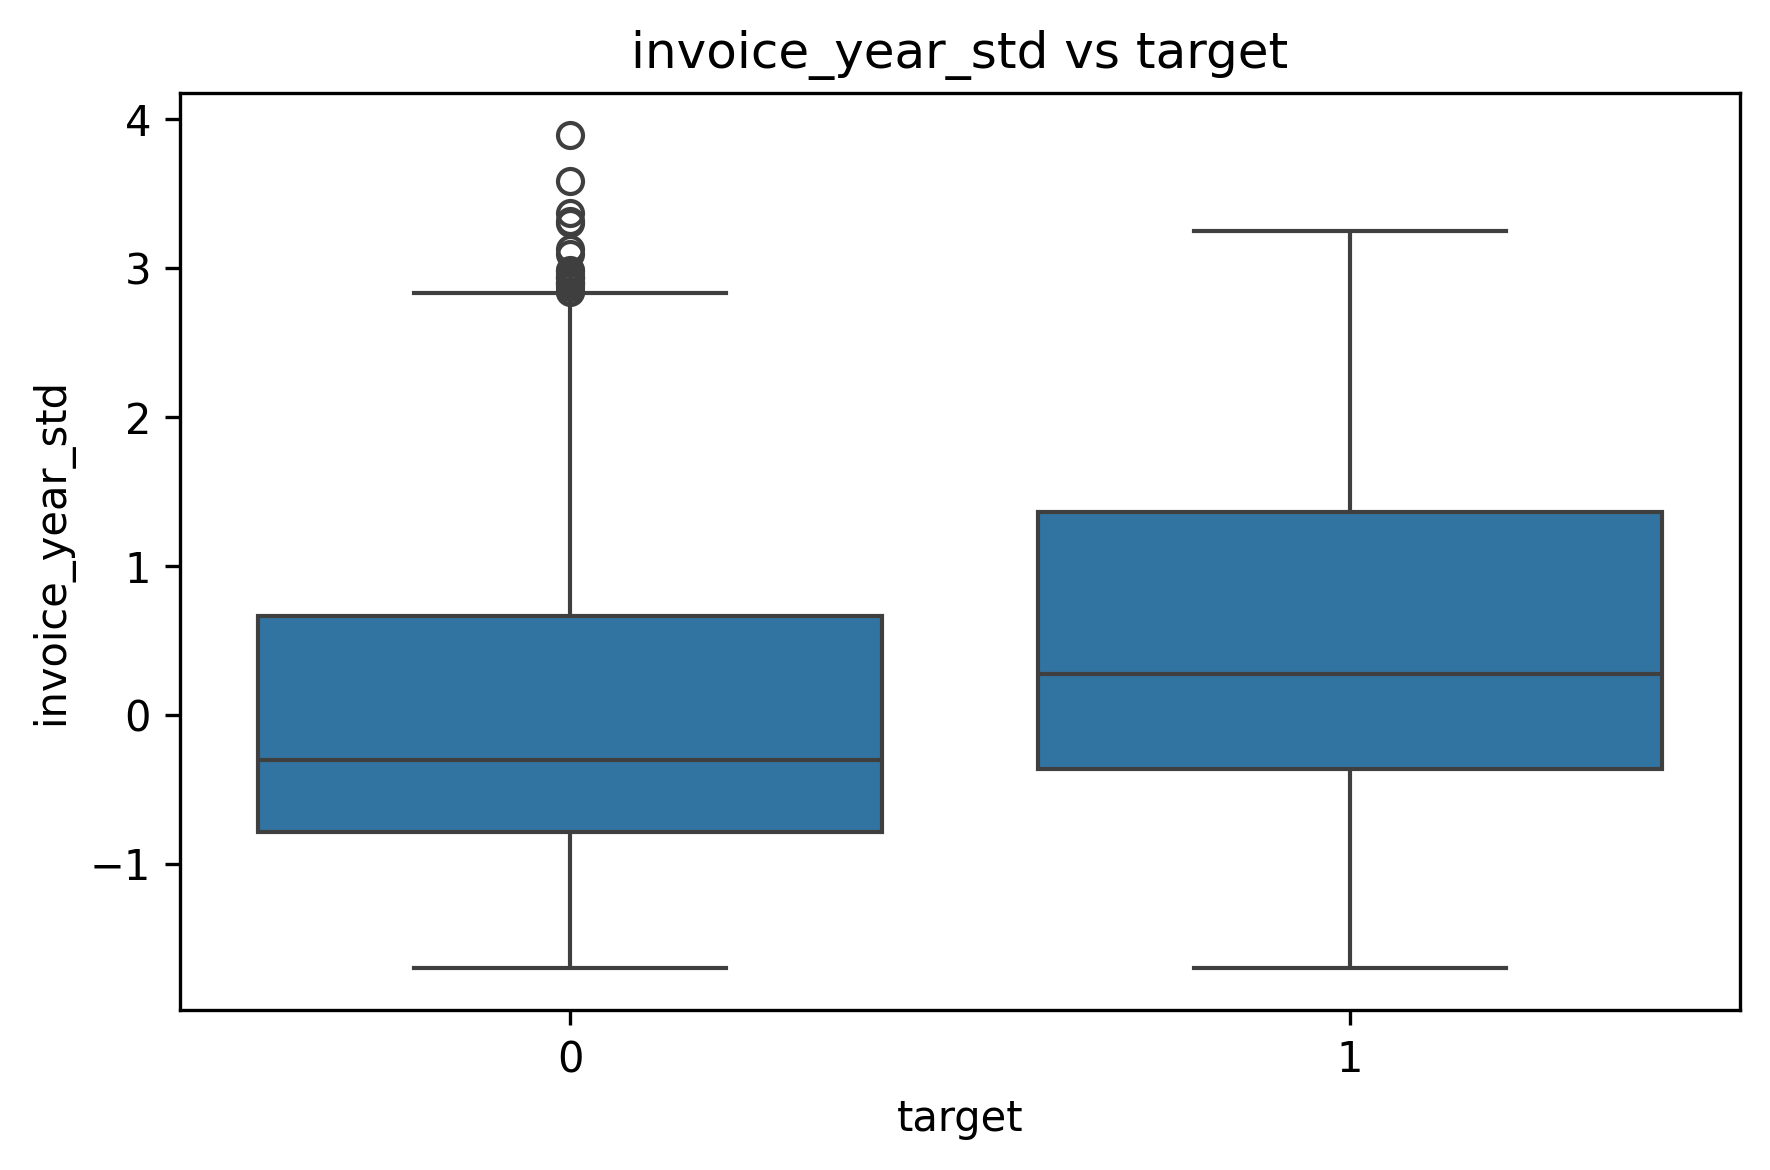

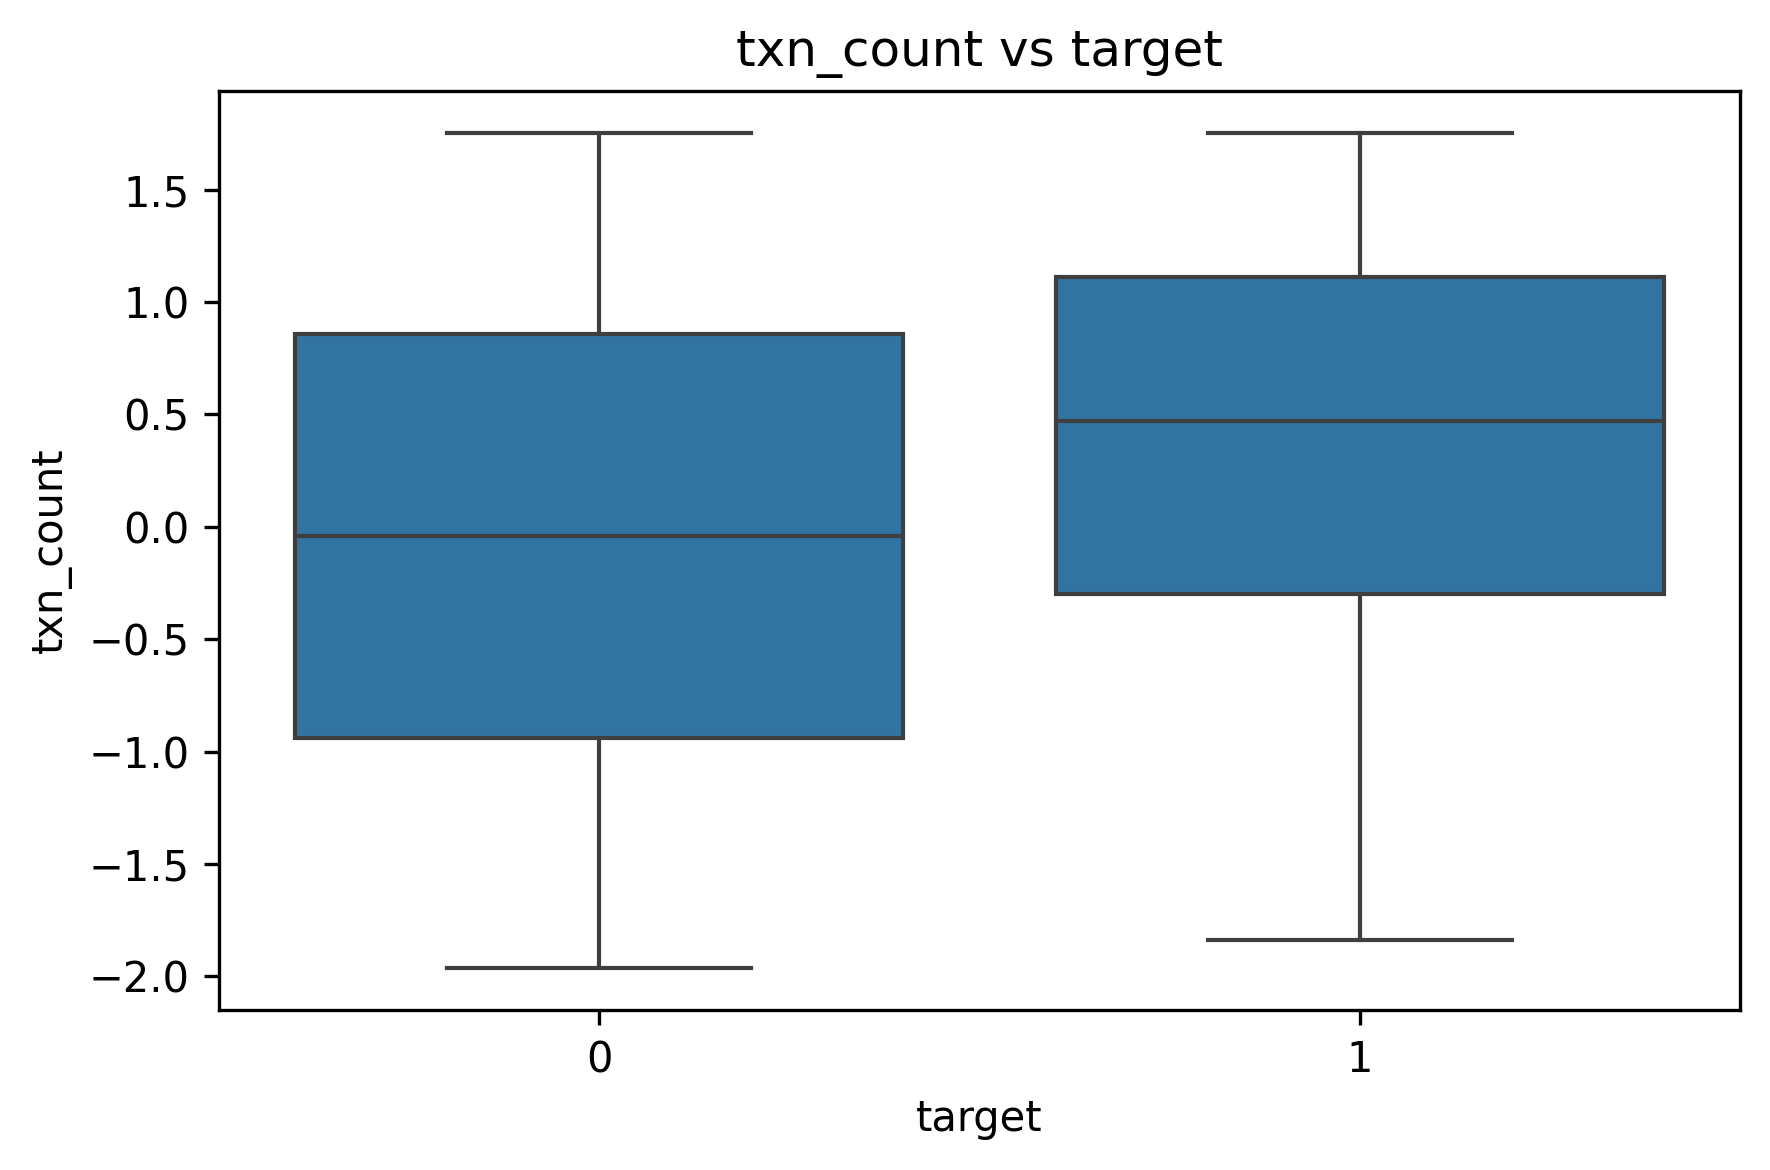

In [ ]:
for col in numeric_features_1:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=target, y=col, data=df)
    plt.title(f"{col} vs {target}")
    plt.tight_layout()
    plt.show()


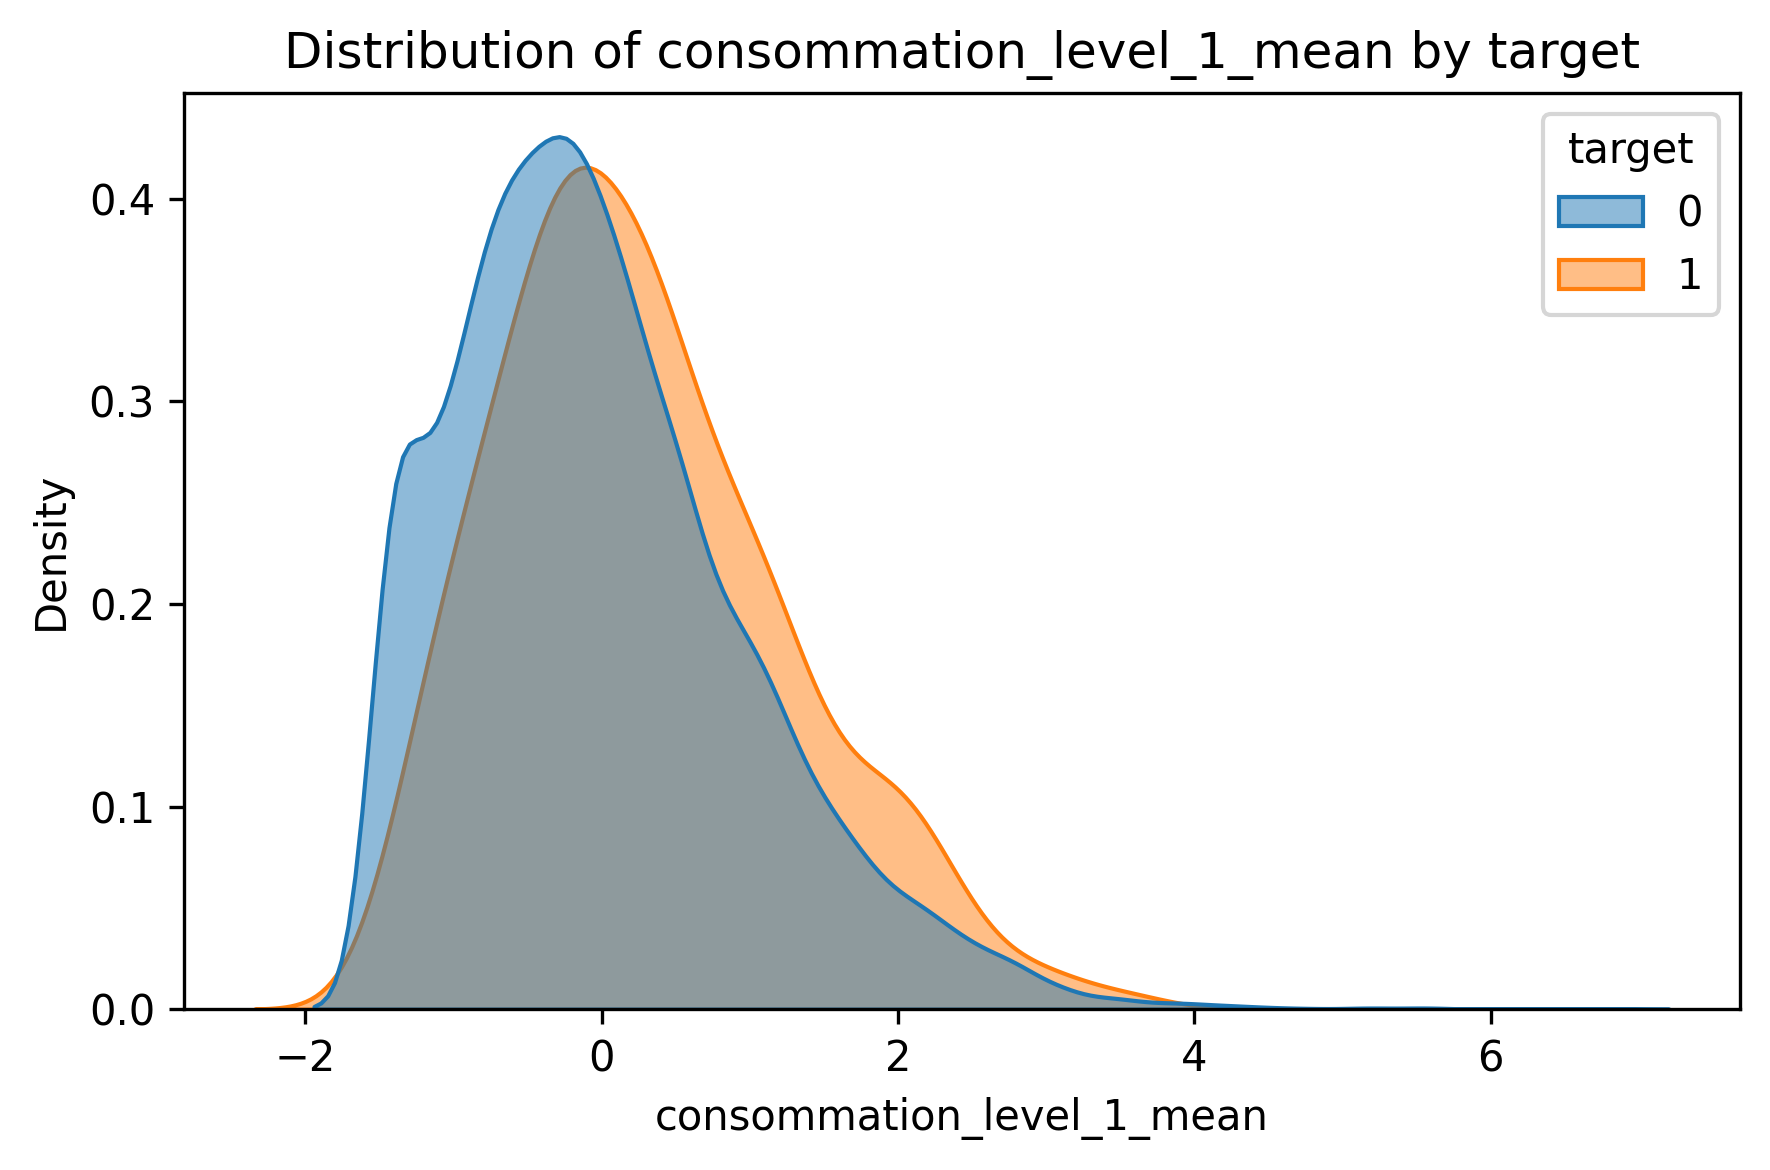

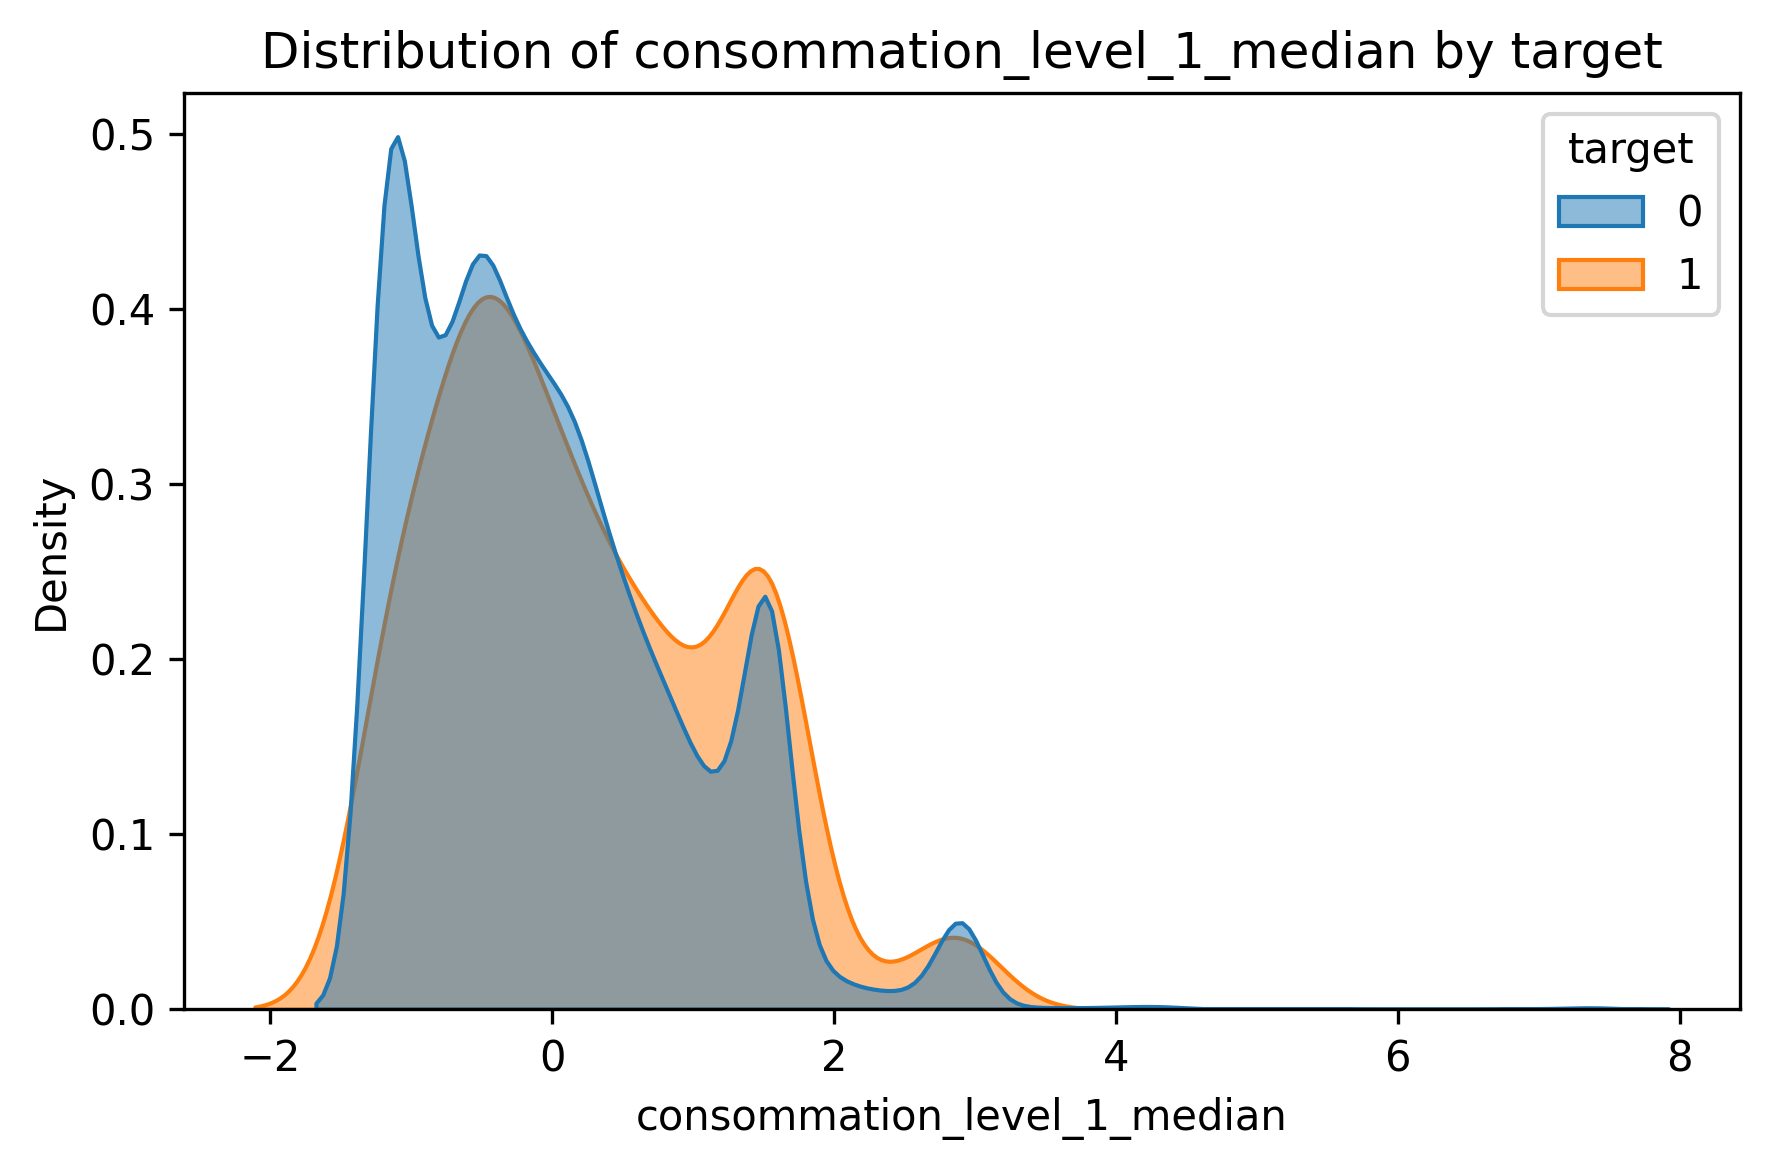

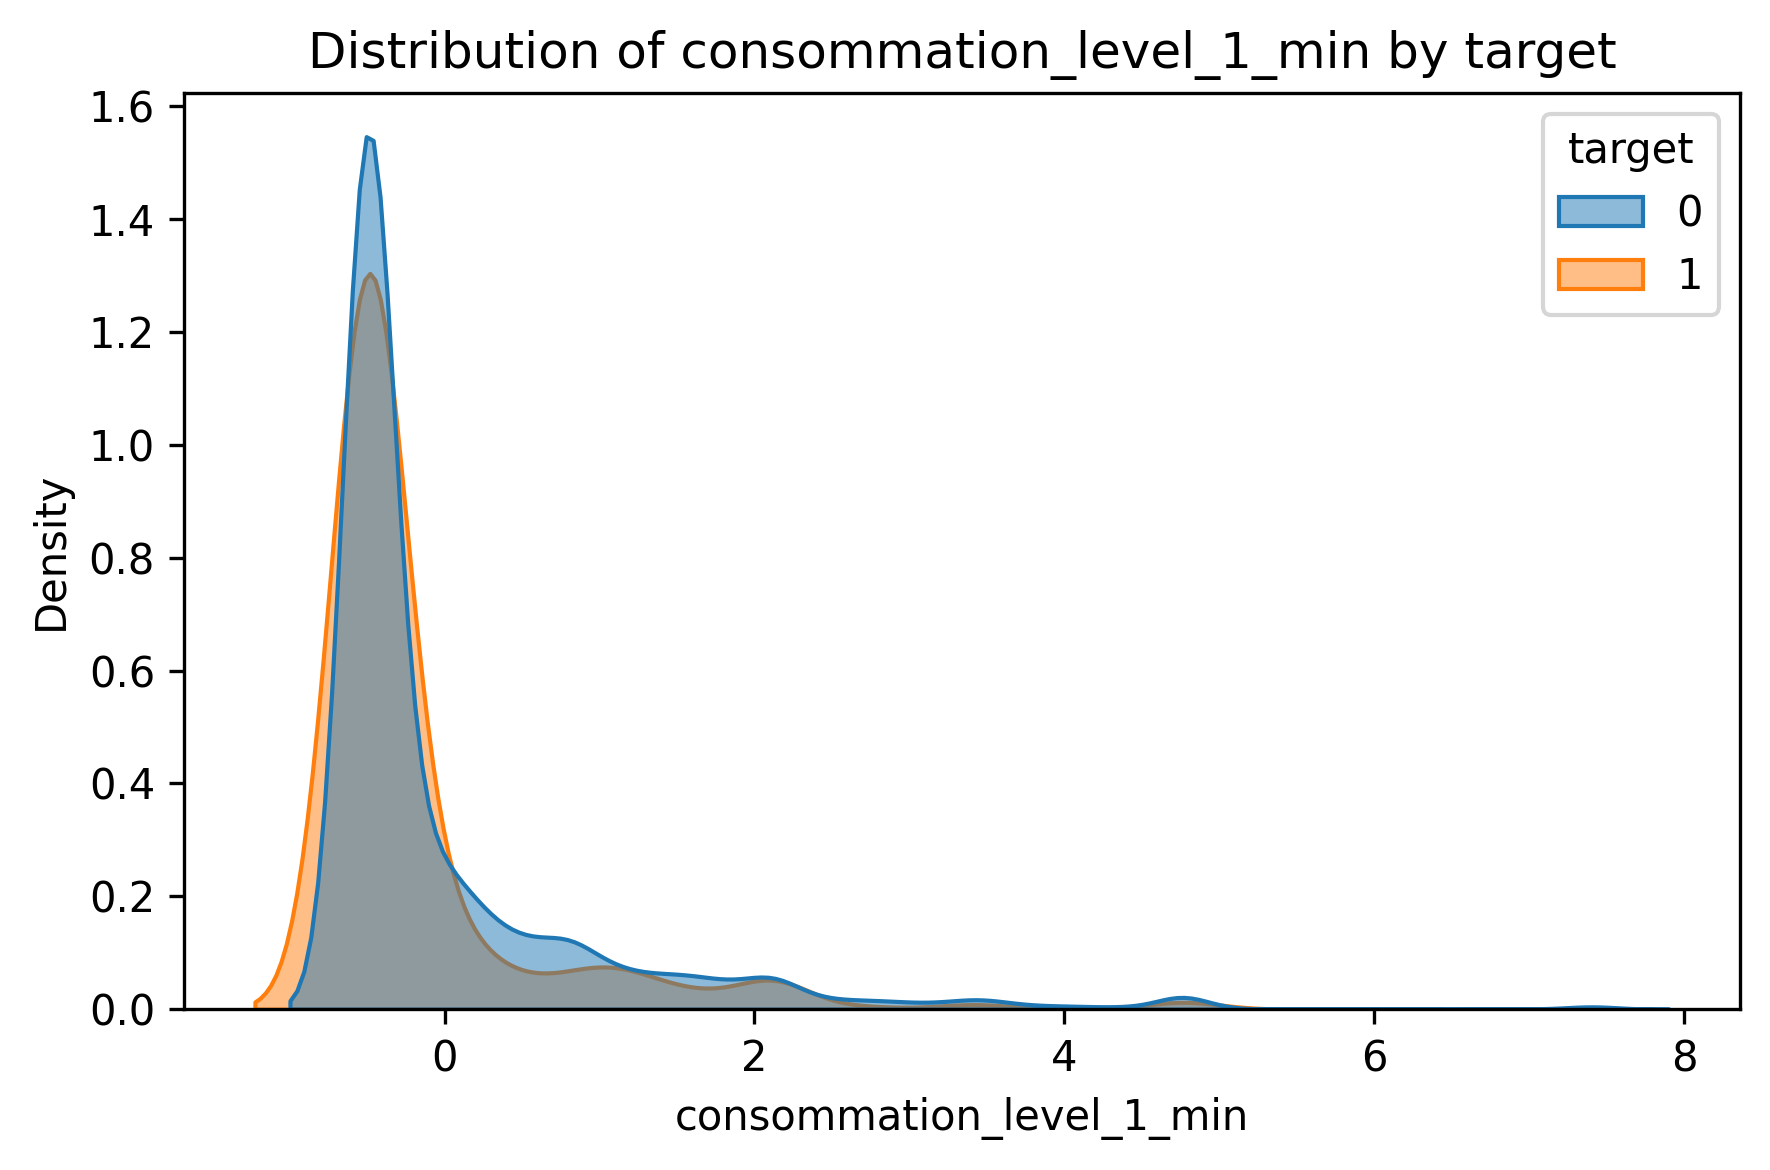

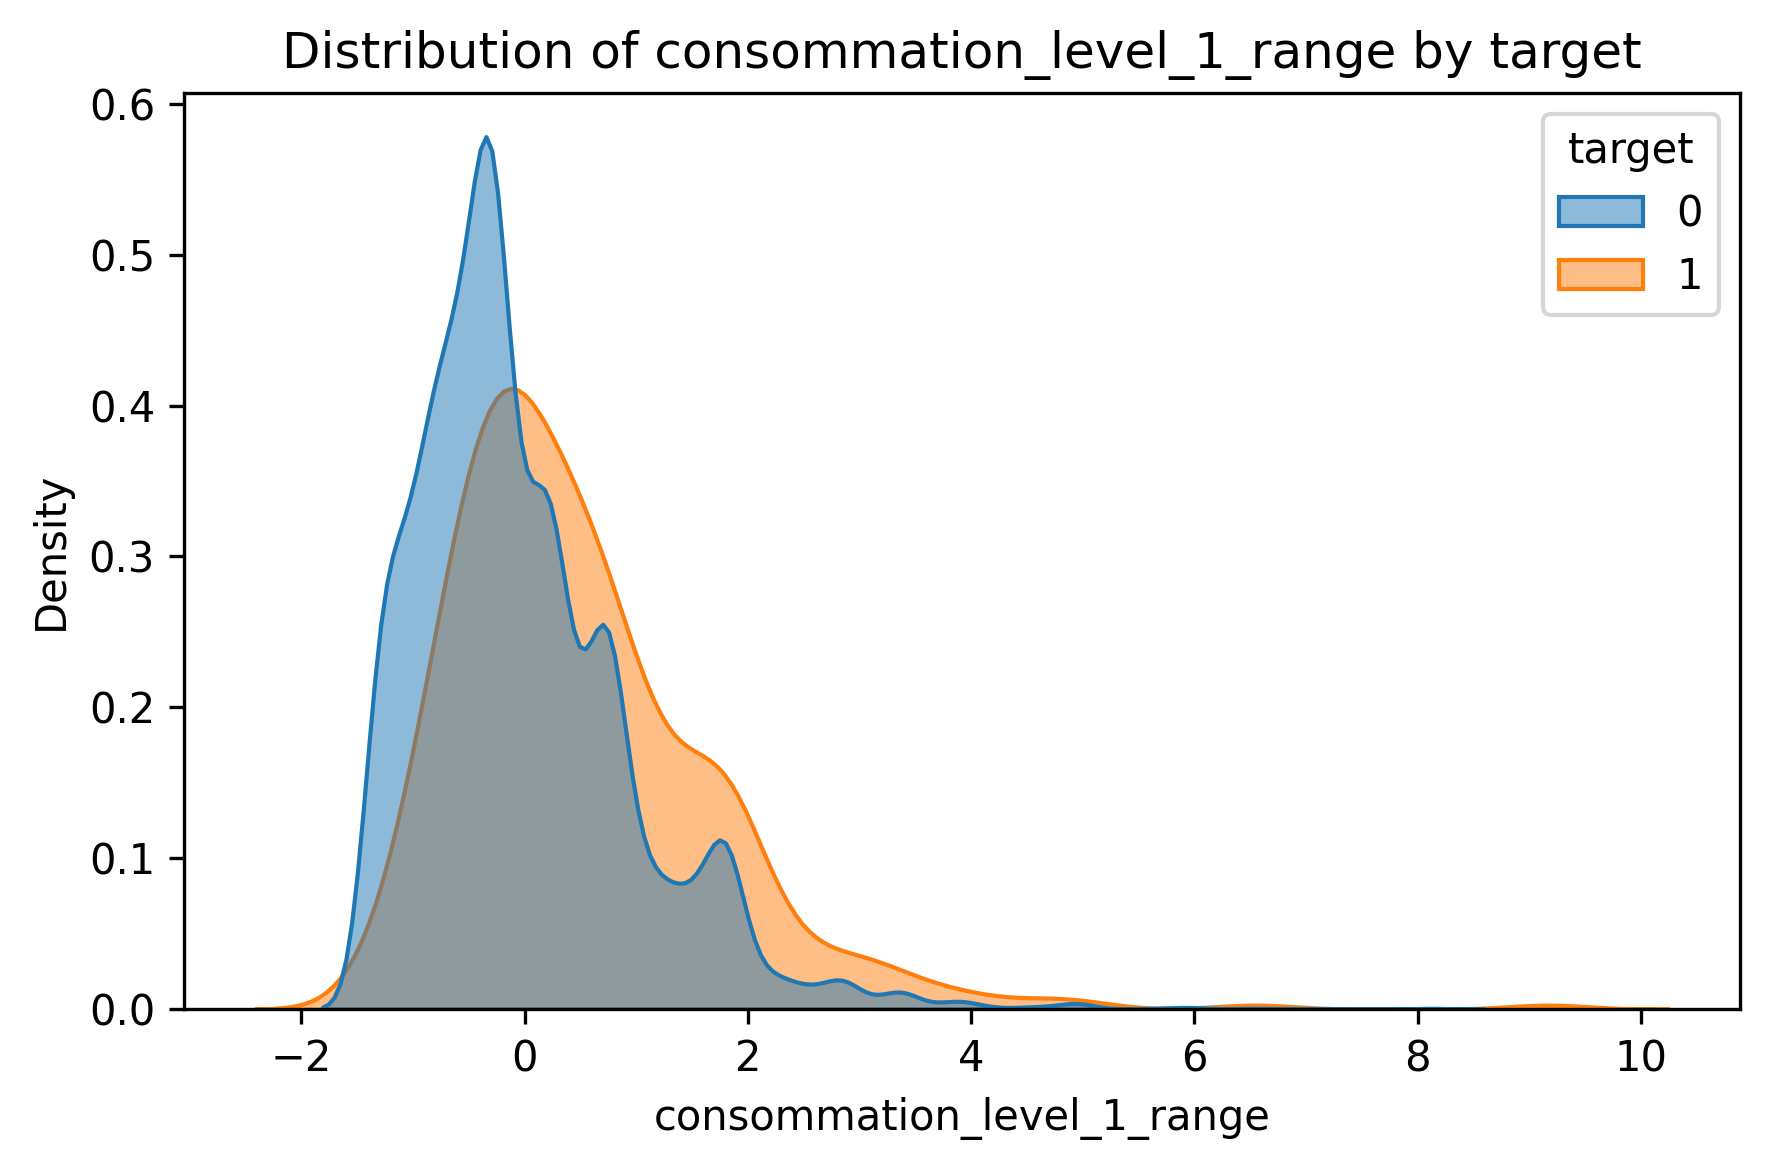

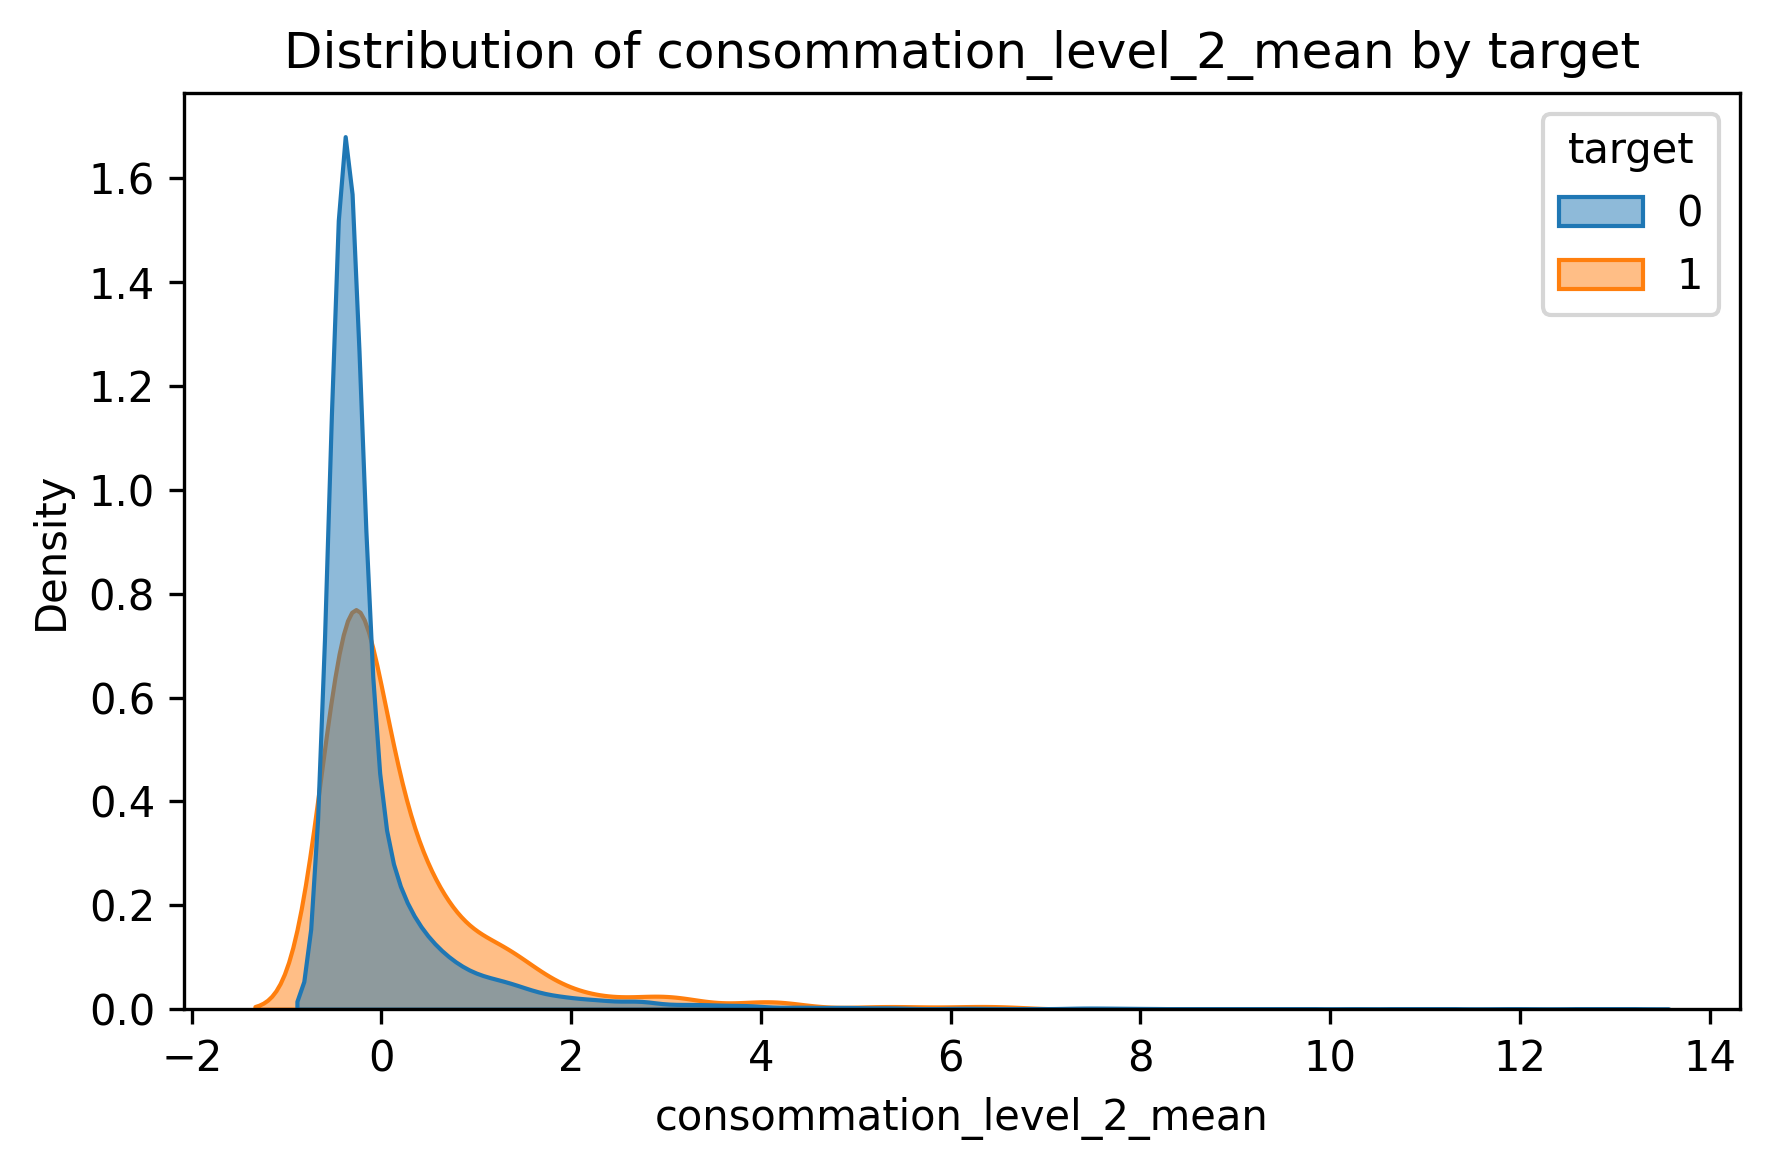

Column 'consommation_level_2_std' not found in df_comb. Skipping plot.


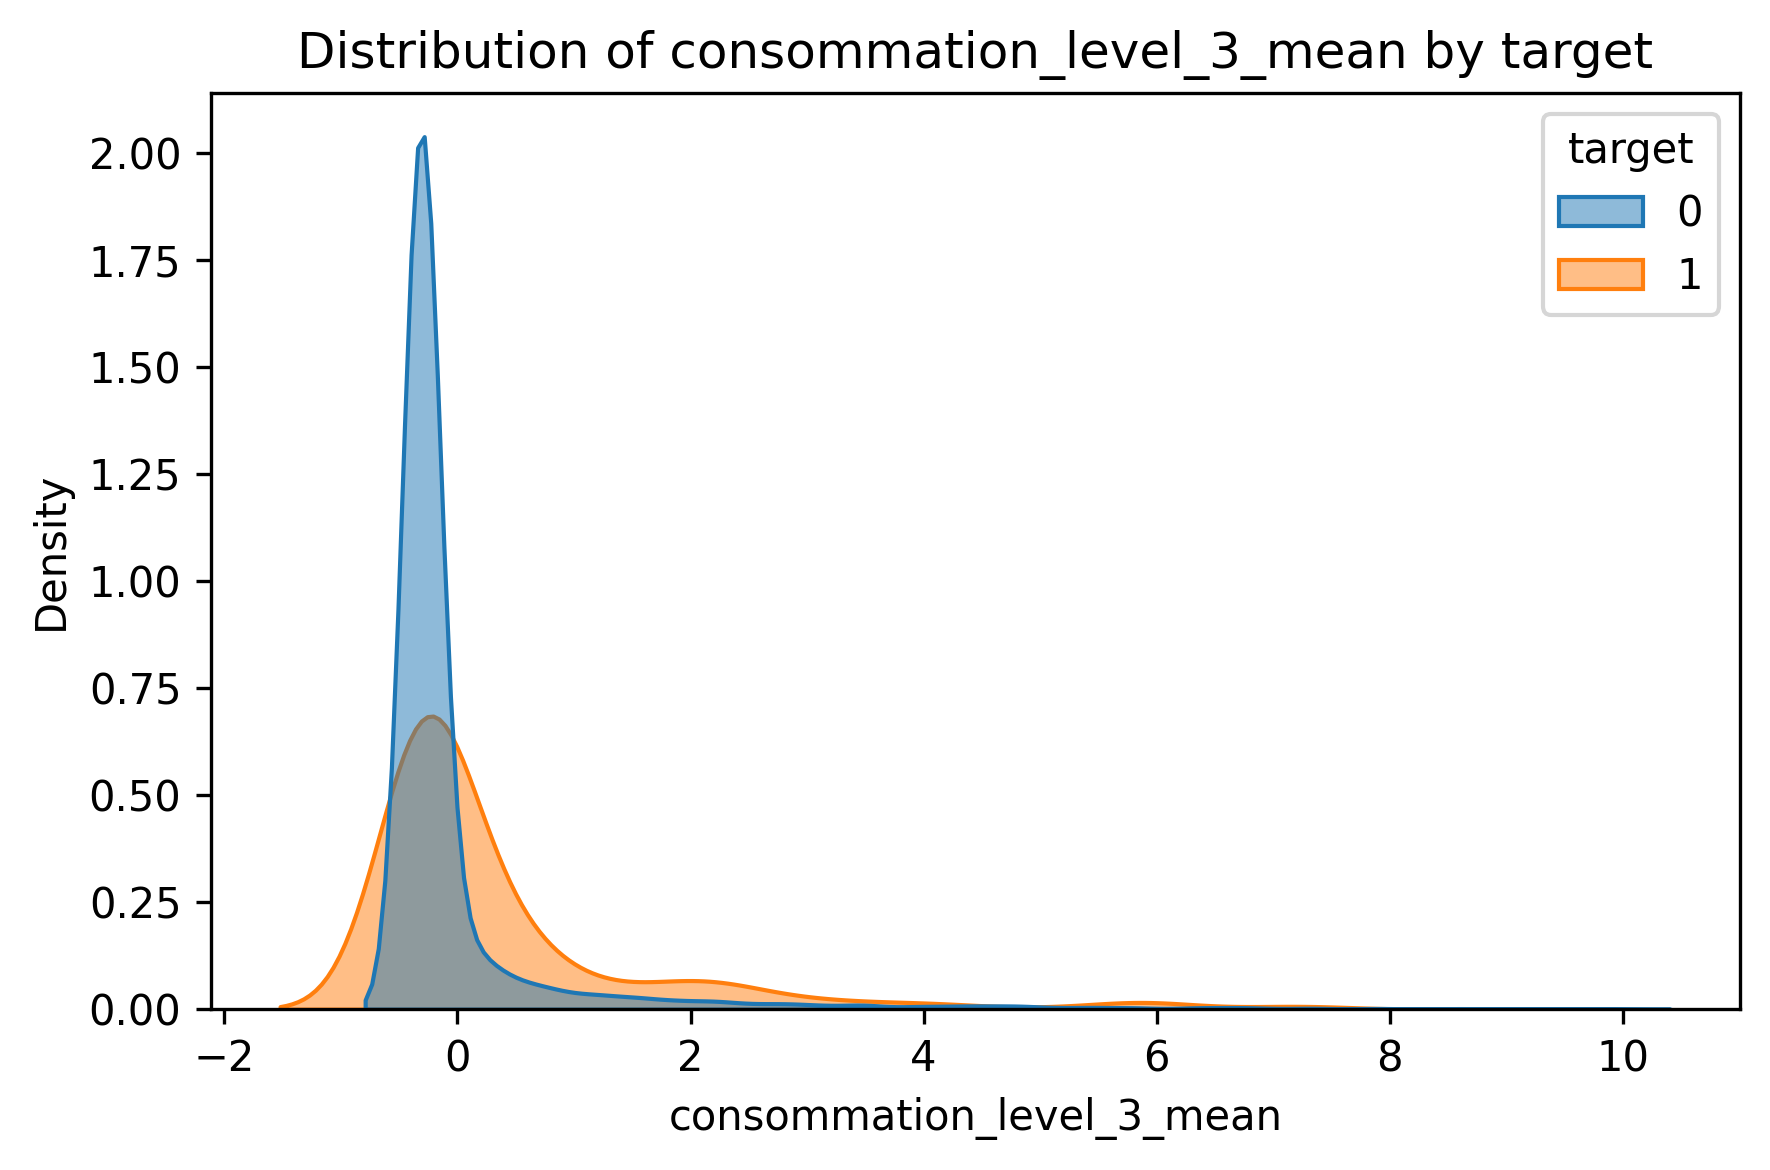

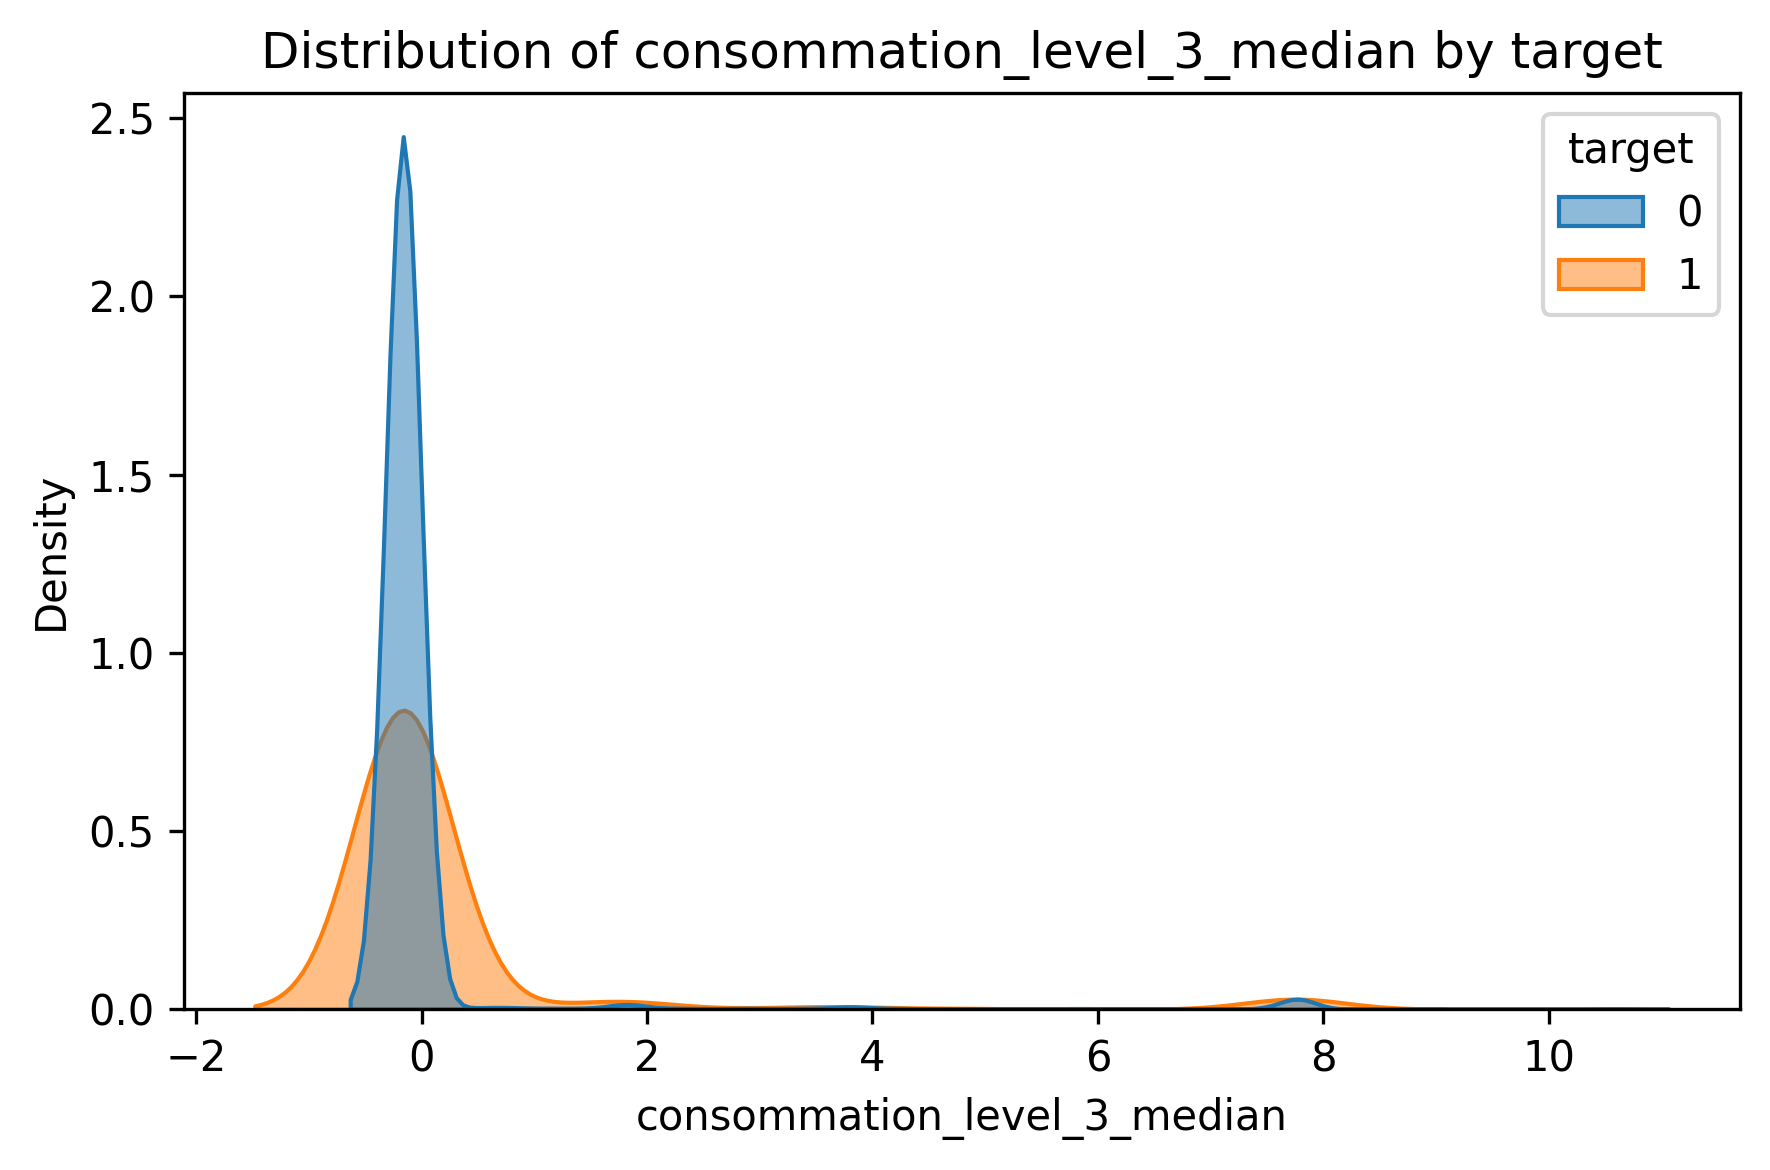

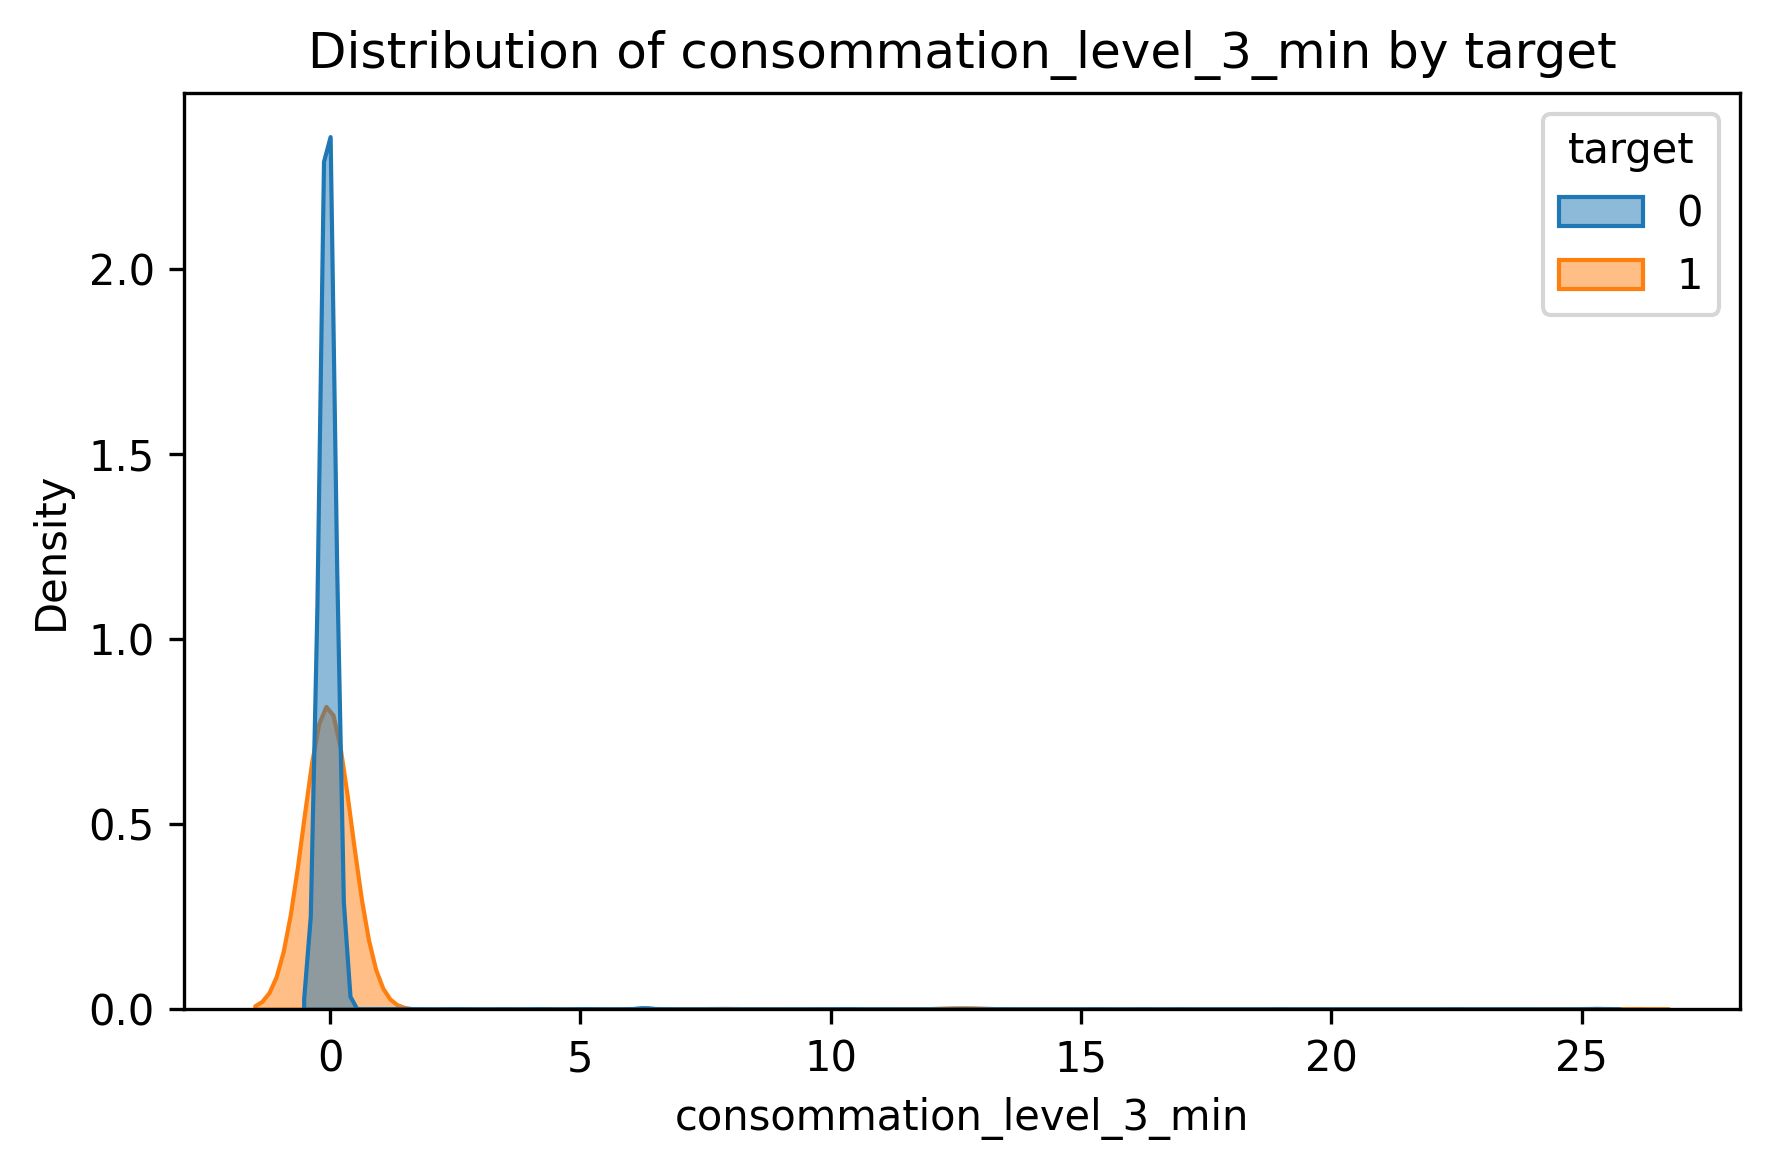

Column 'consommation_level_3_range' not found in df_comb. Skipping plot.


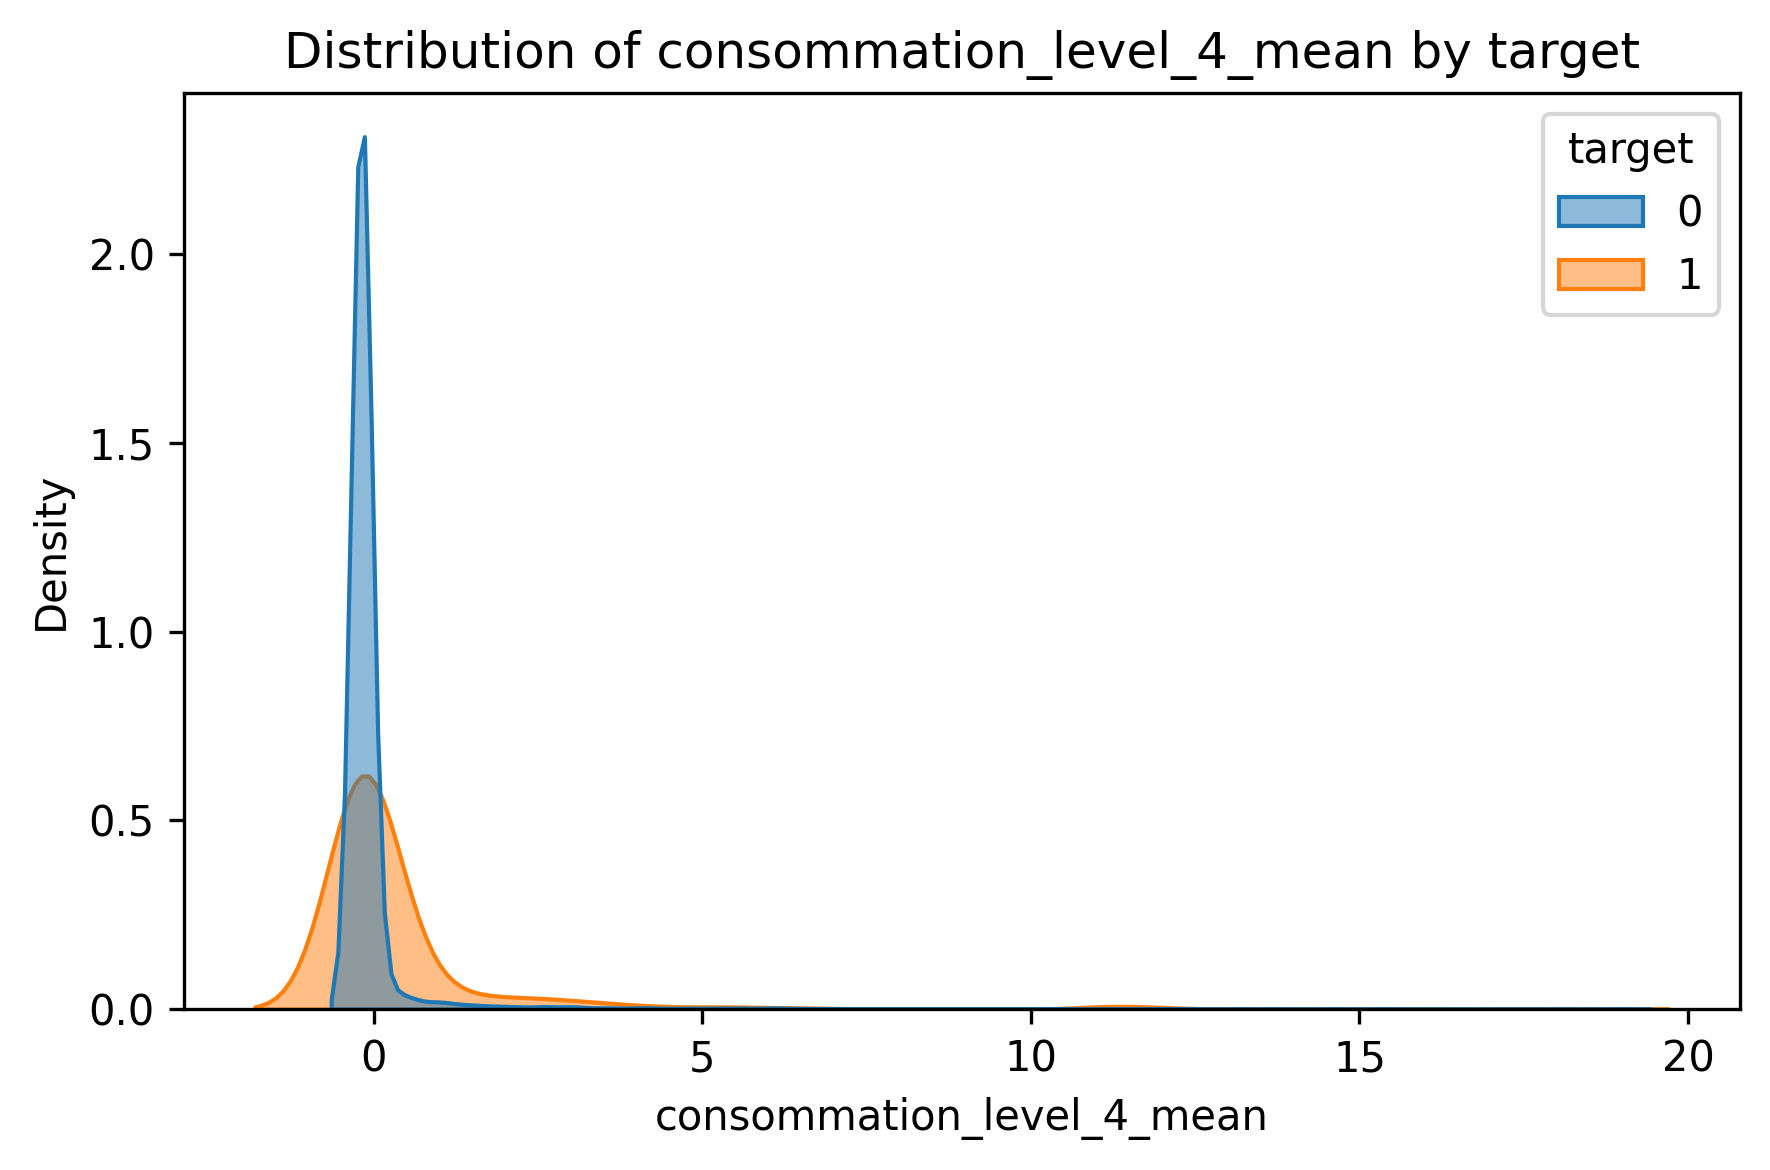

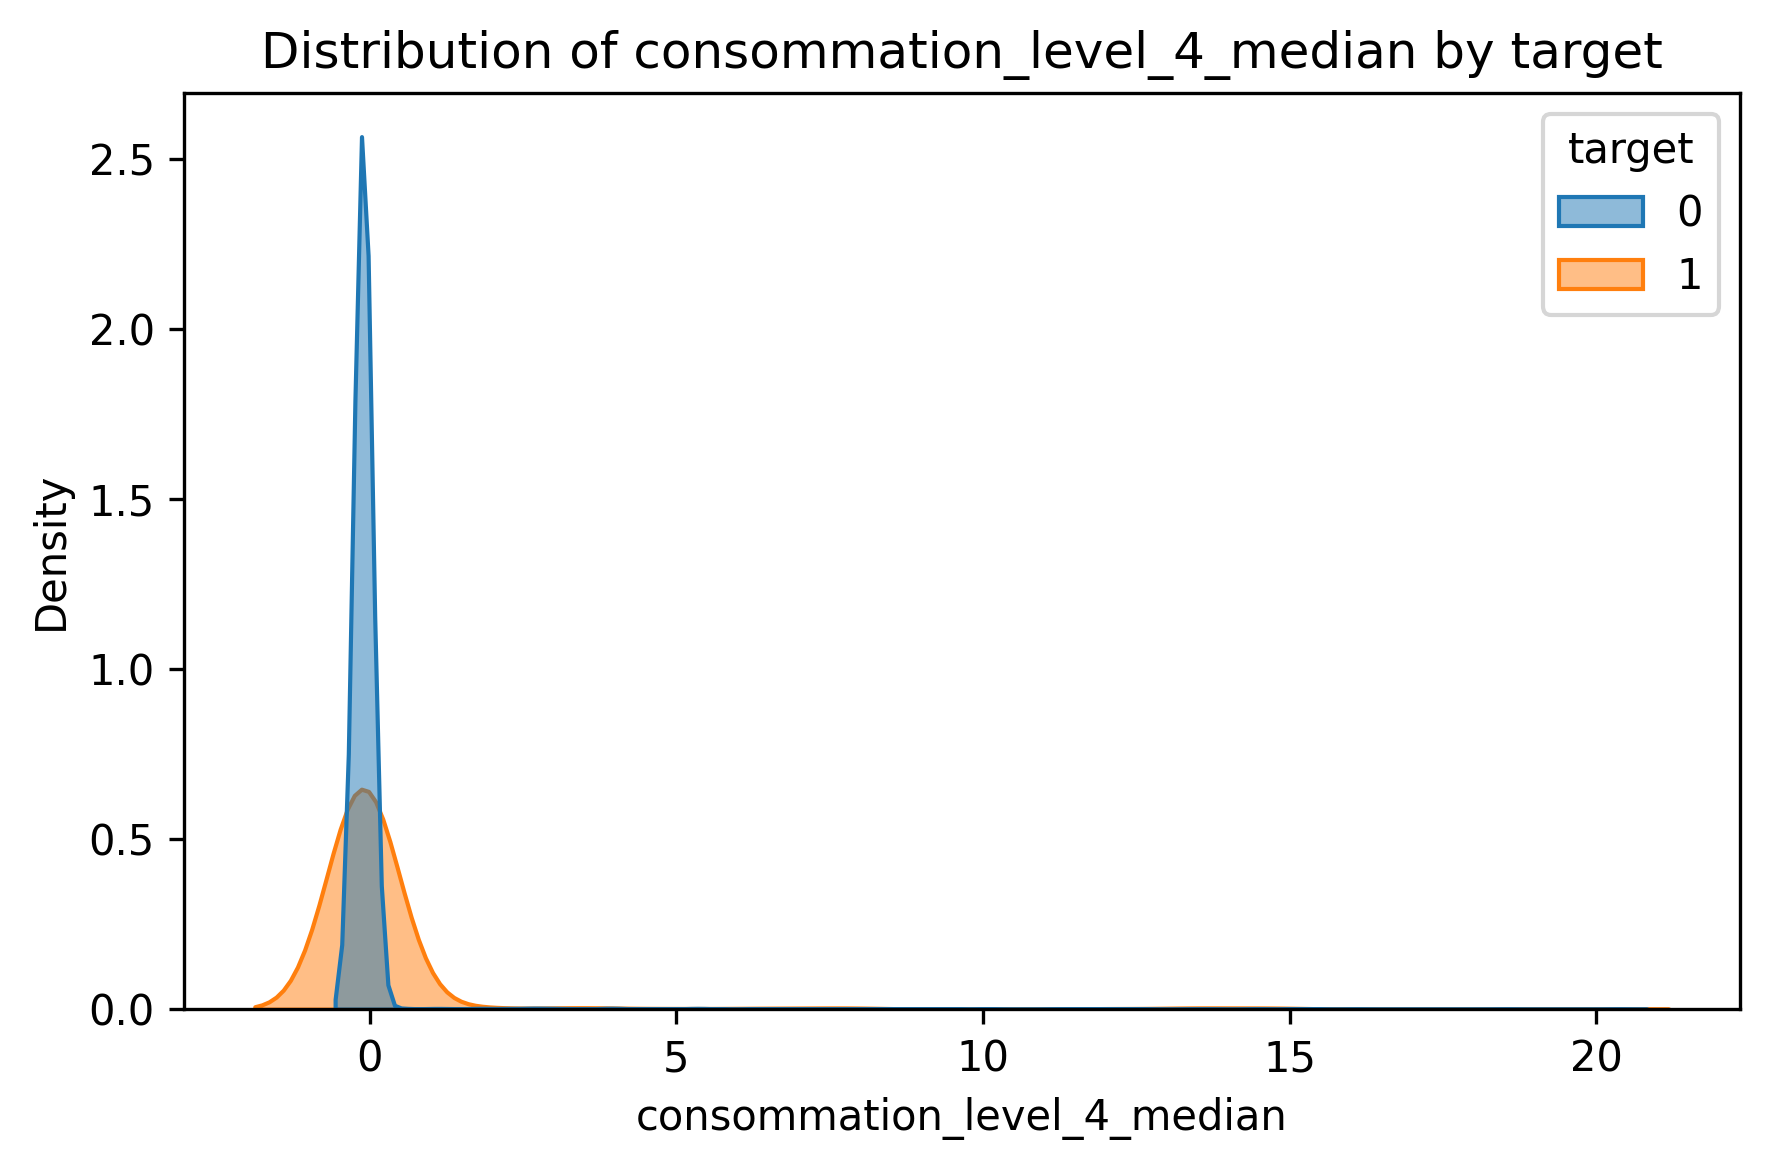

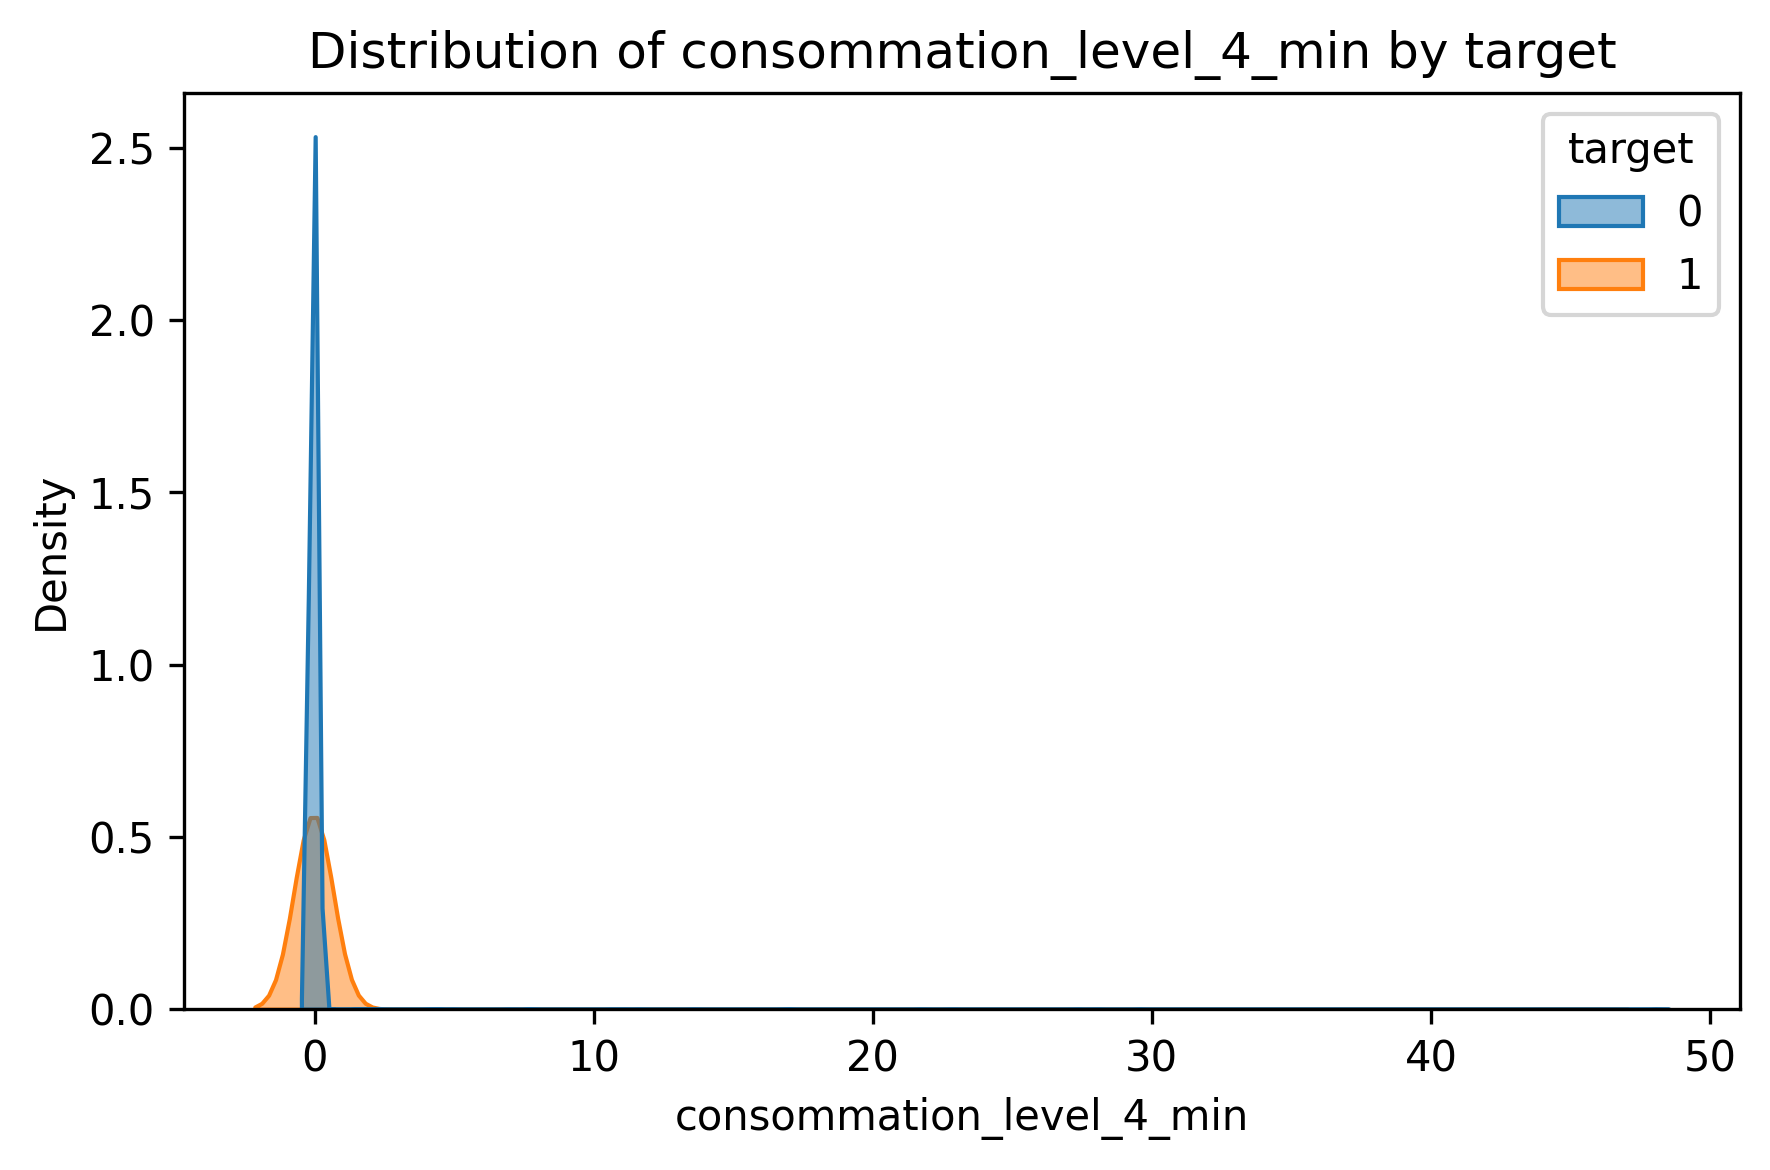

Column 'consommation_level_4_range' not found in df_comb. Skipping plot.


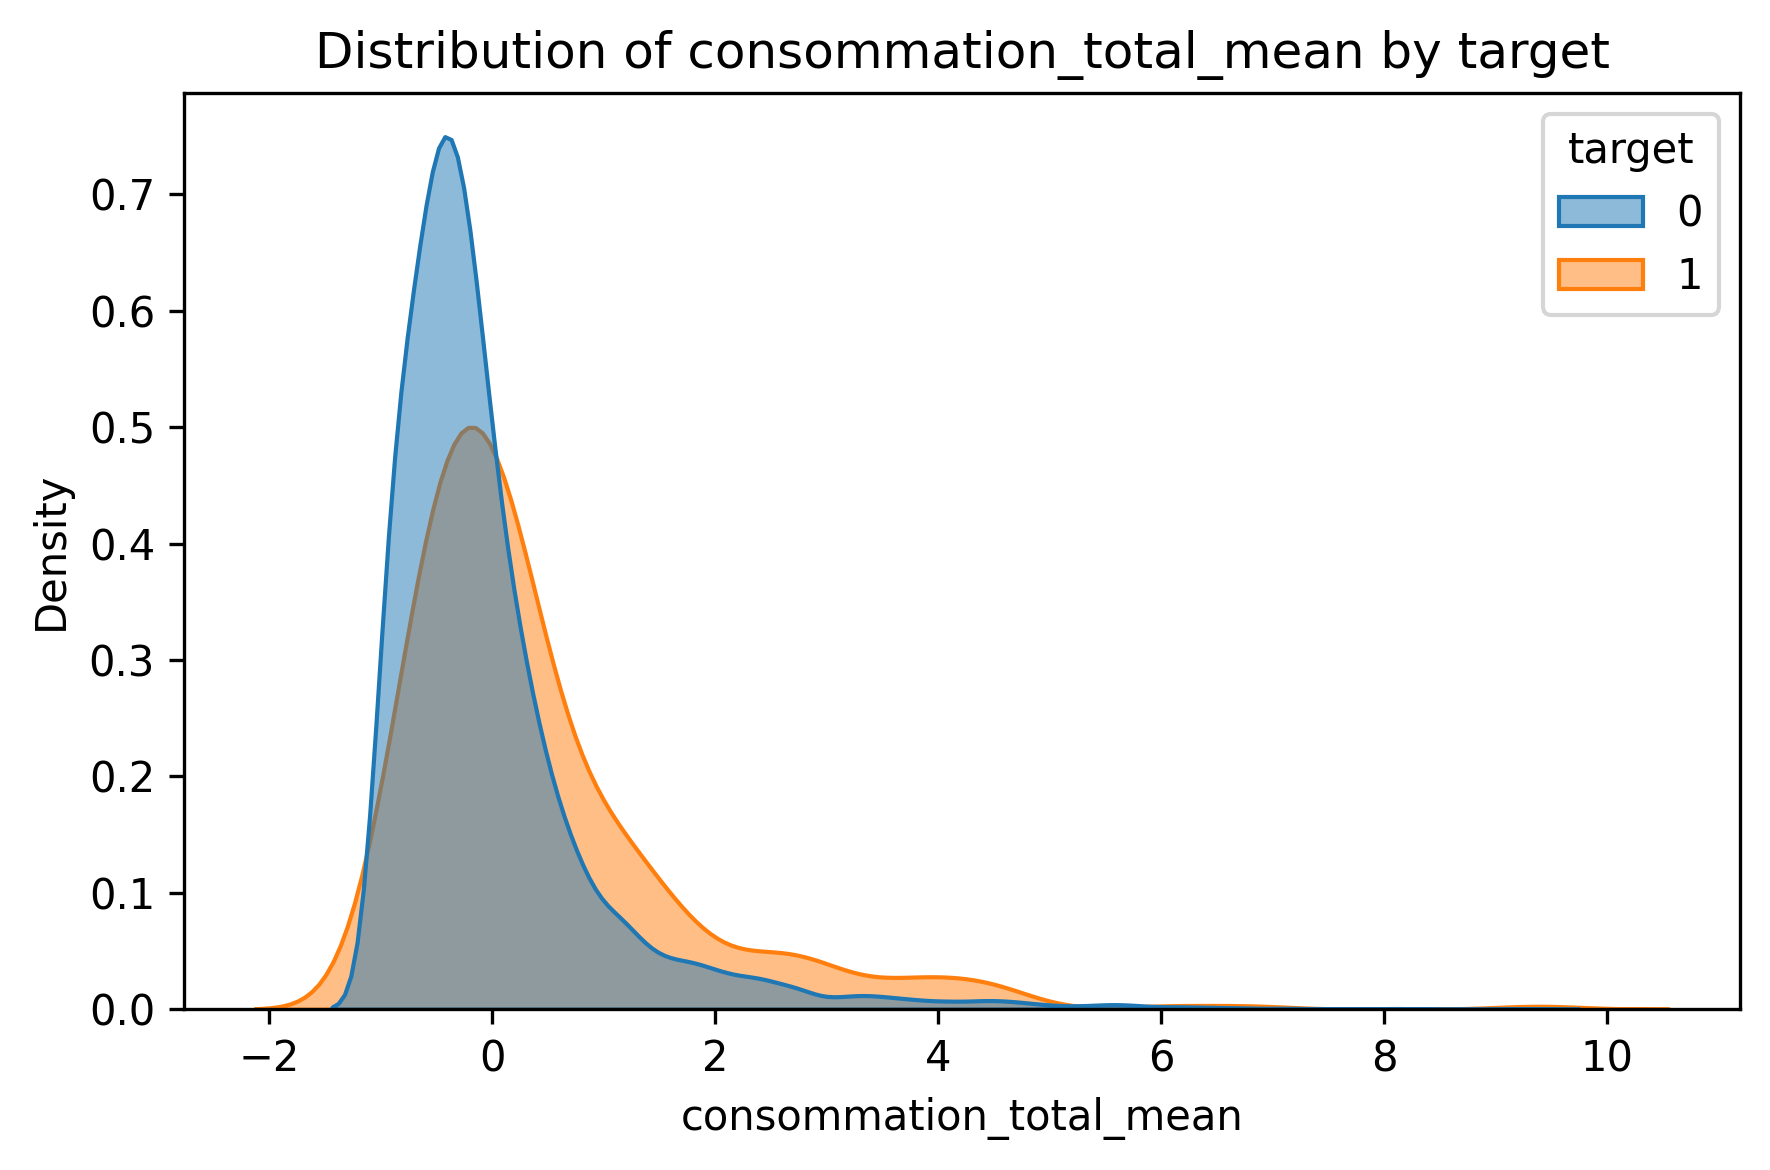

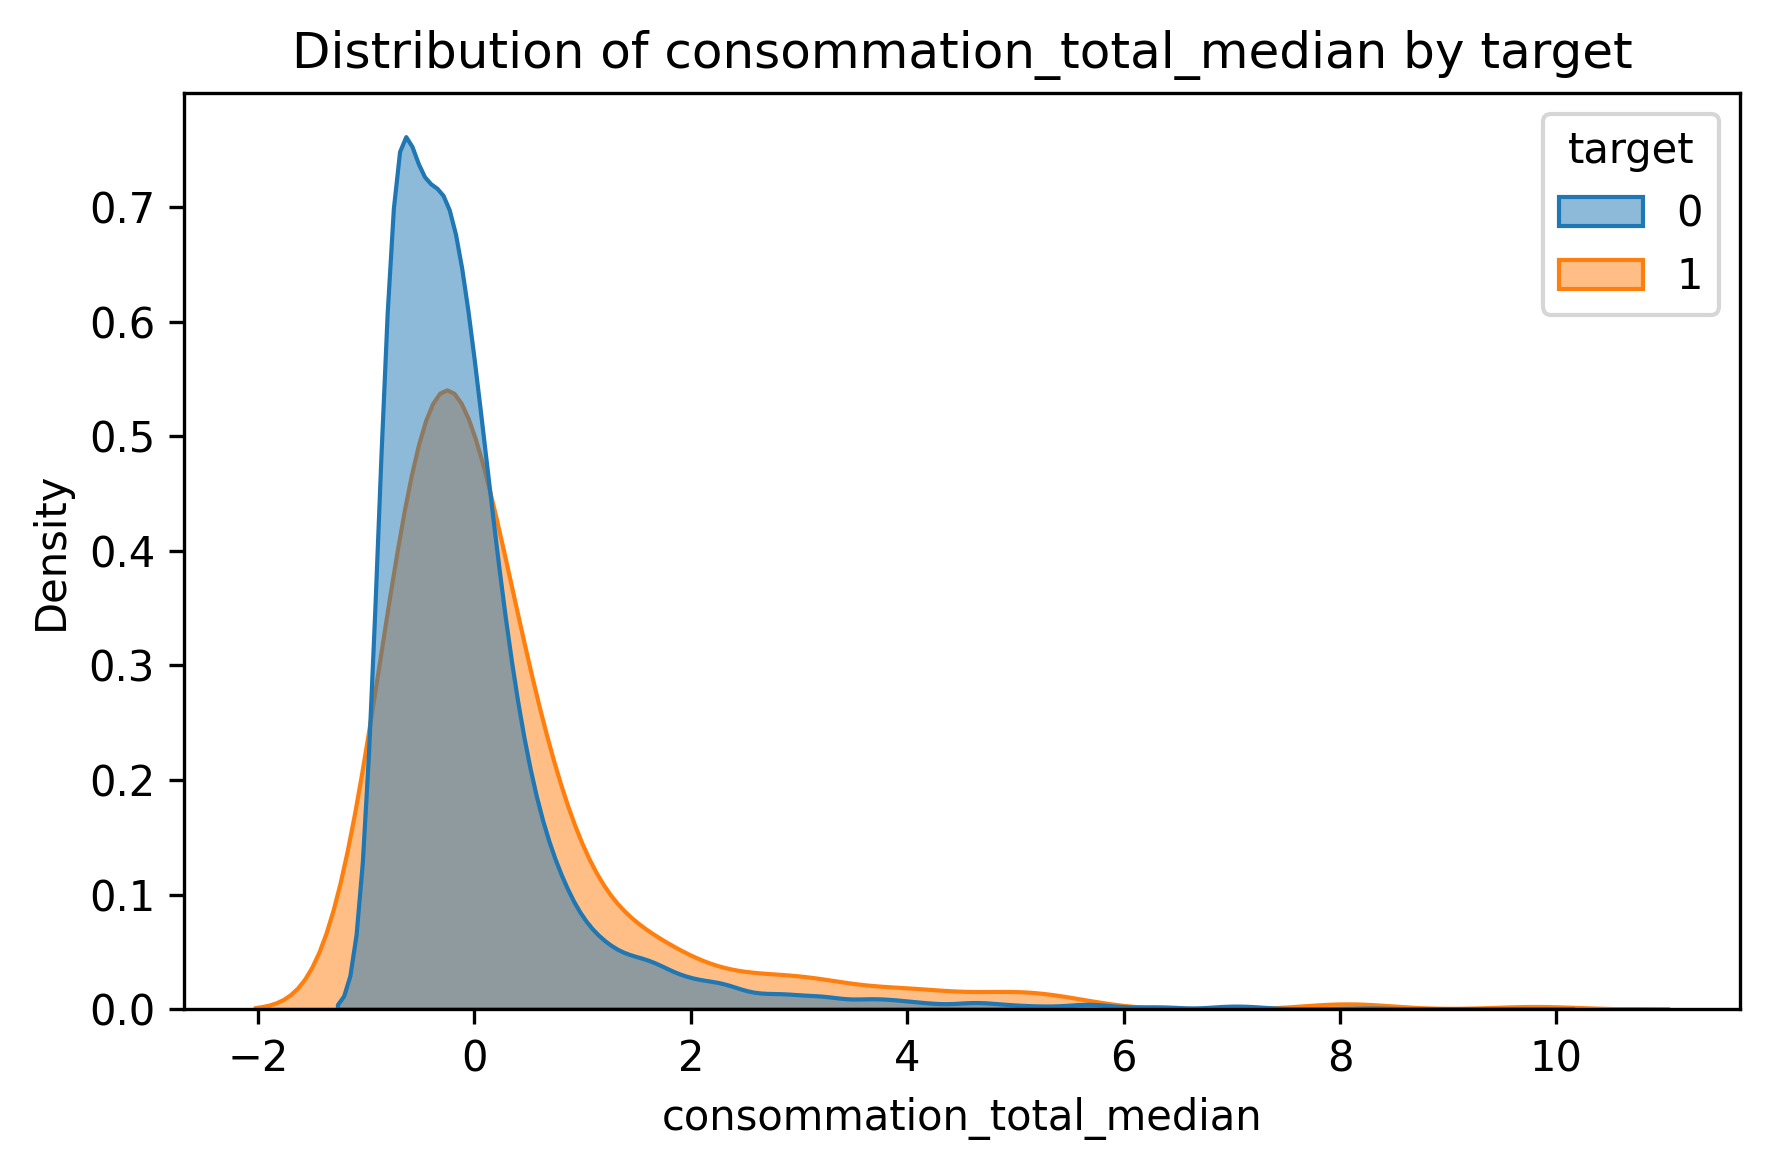

Column 'consommation_total_min' not found in df_comb. Skipping plot.


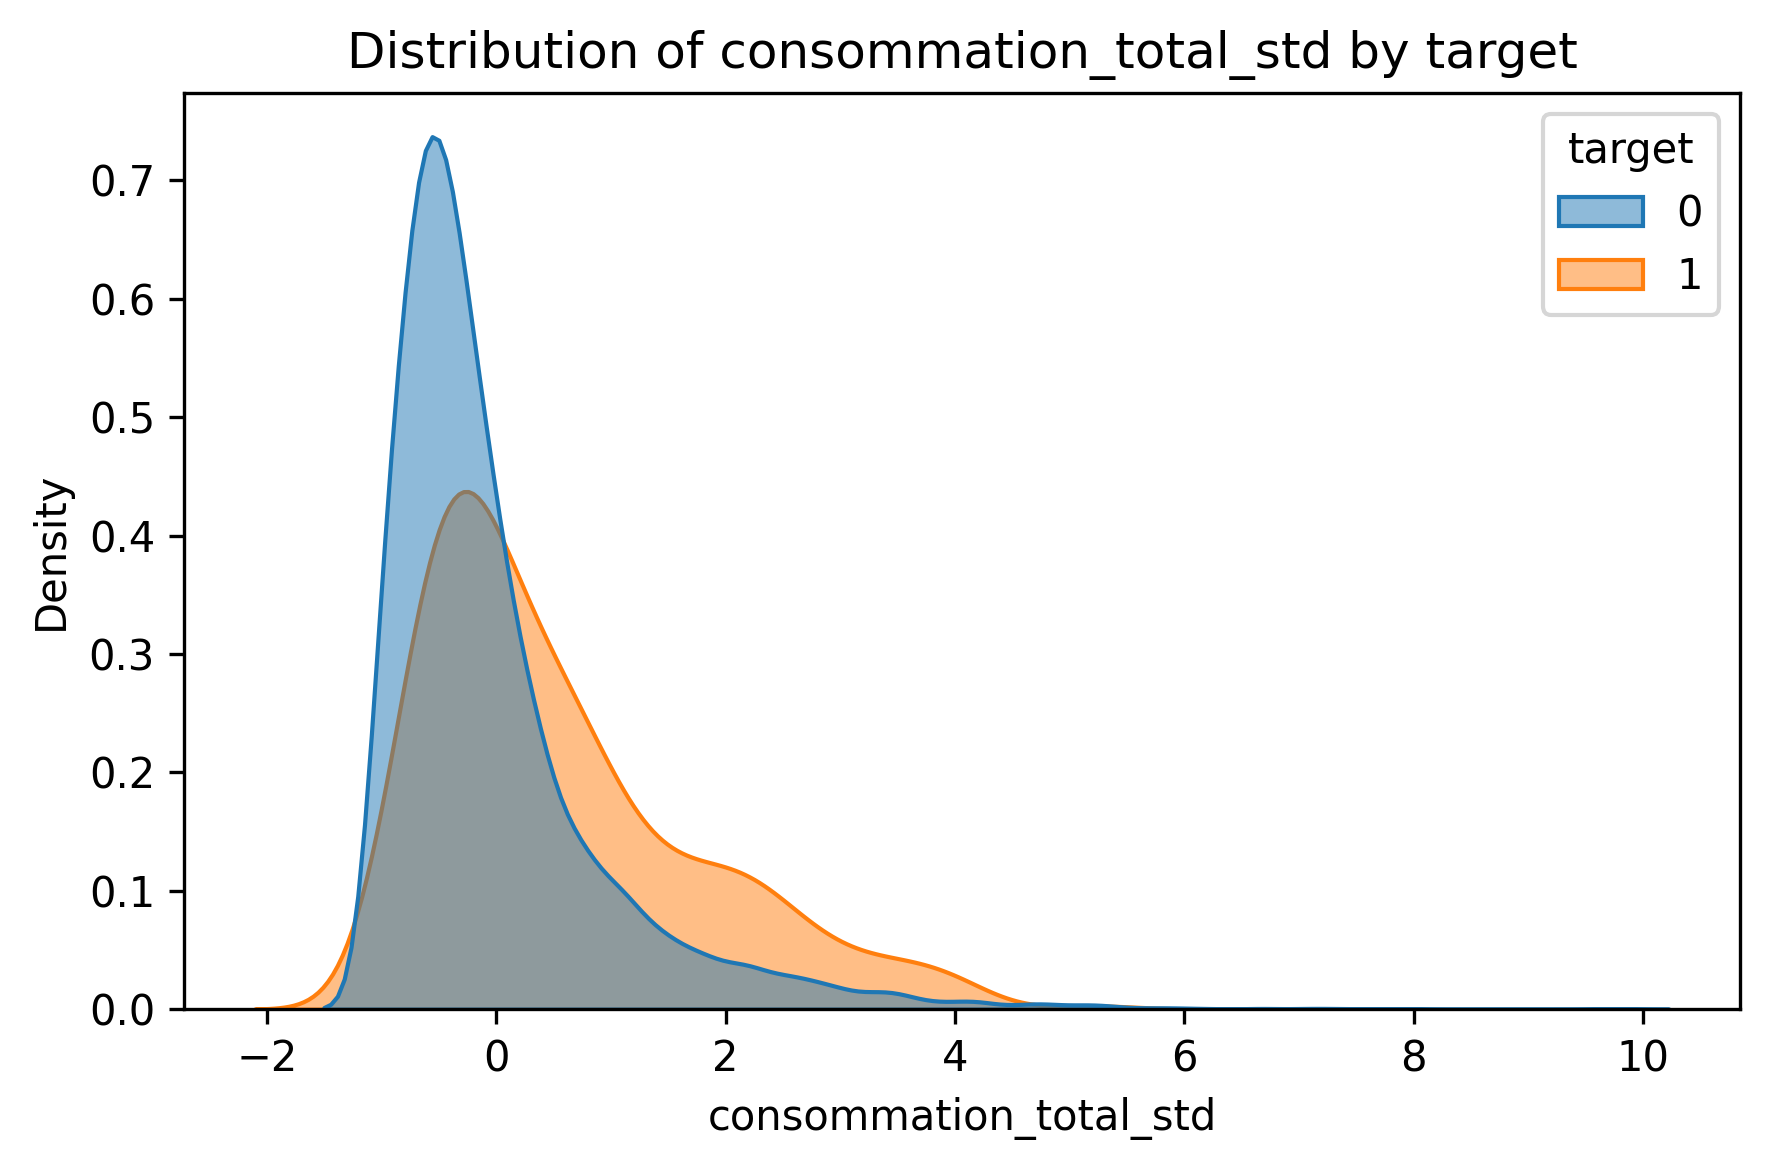

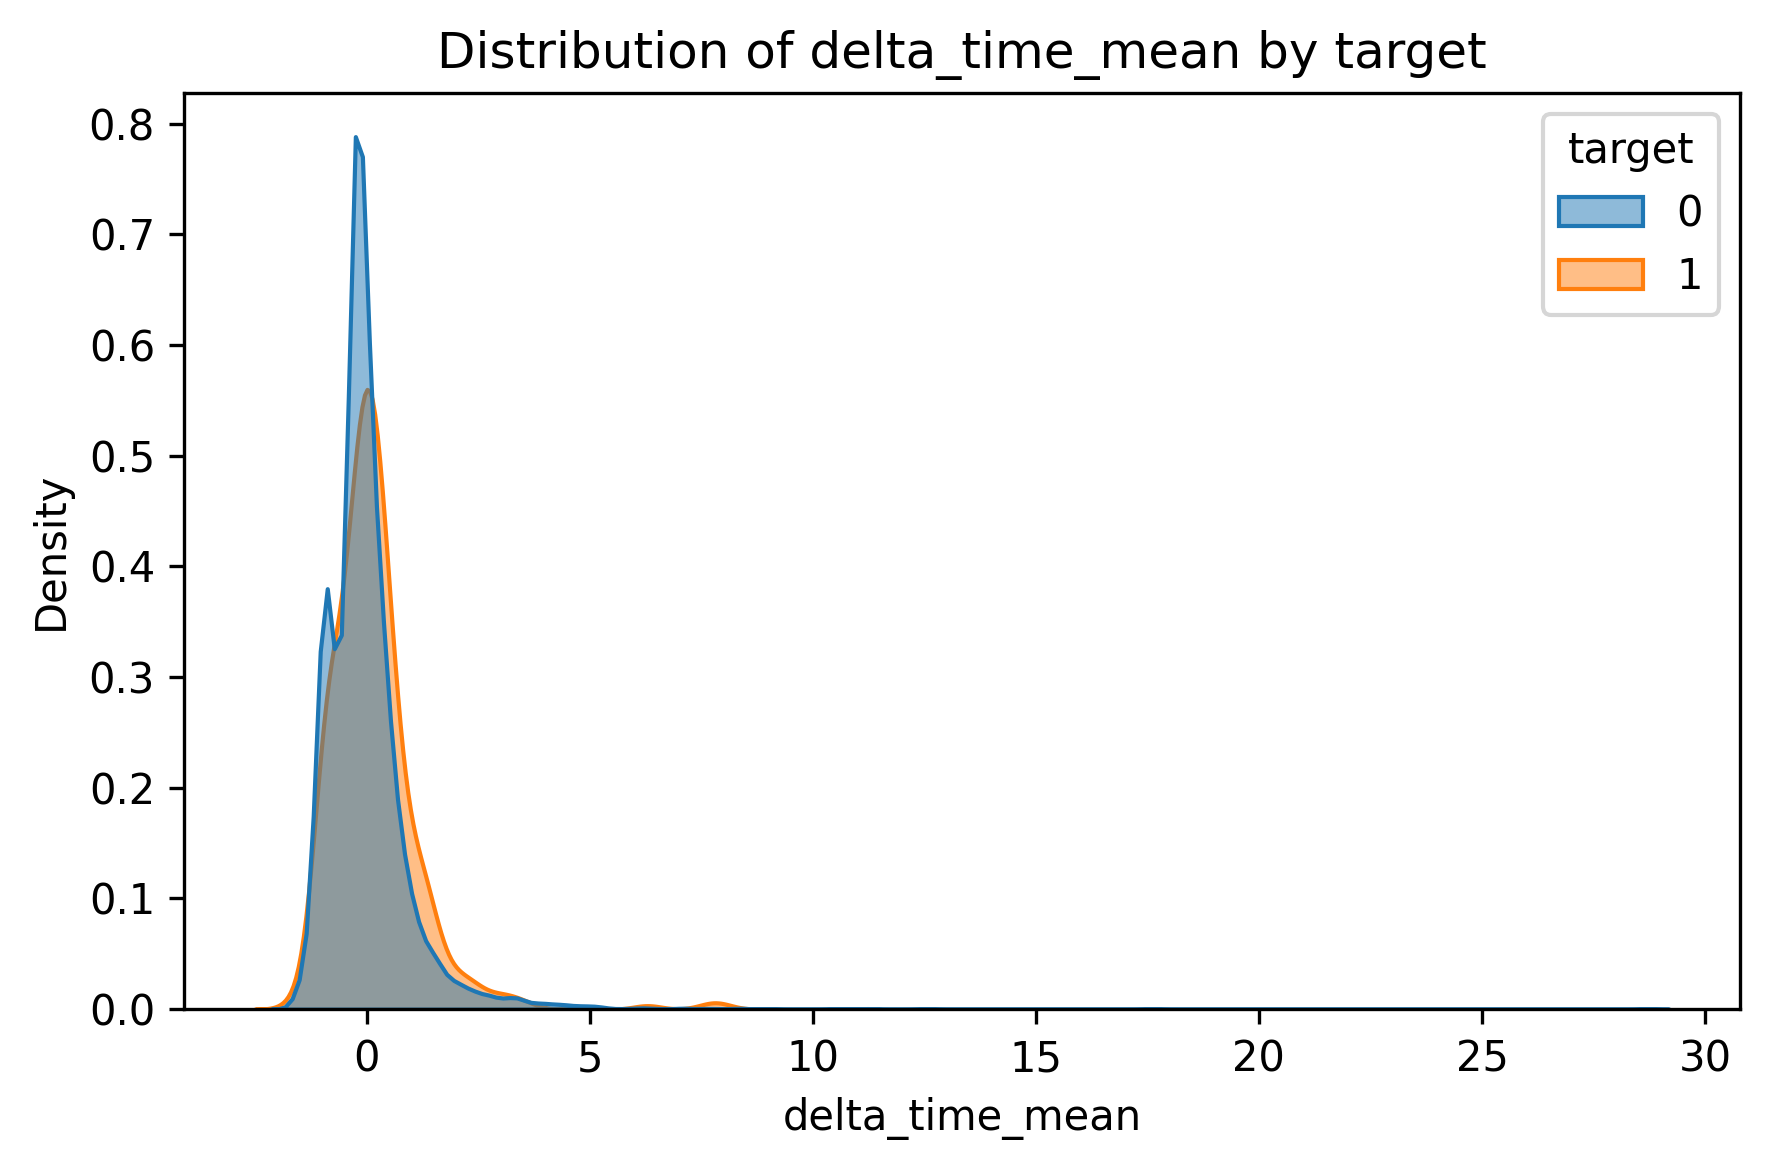

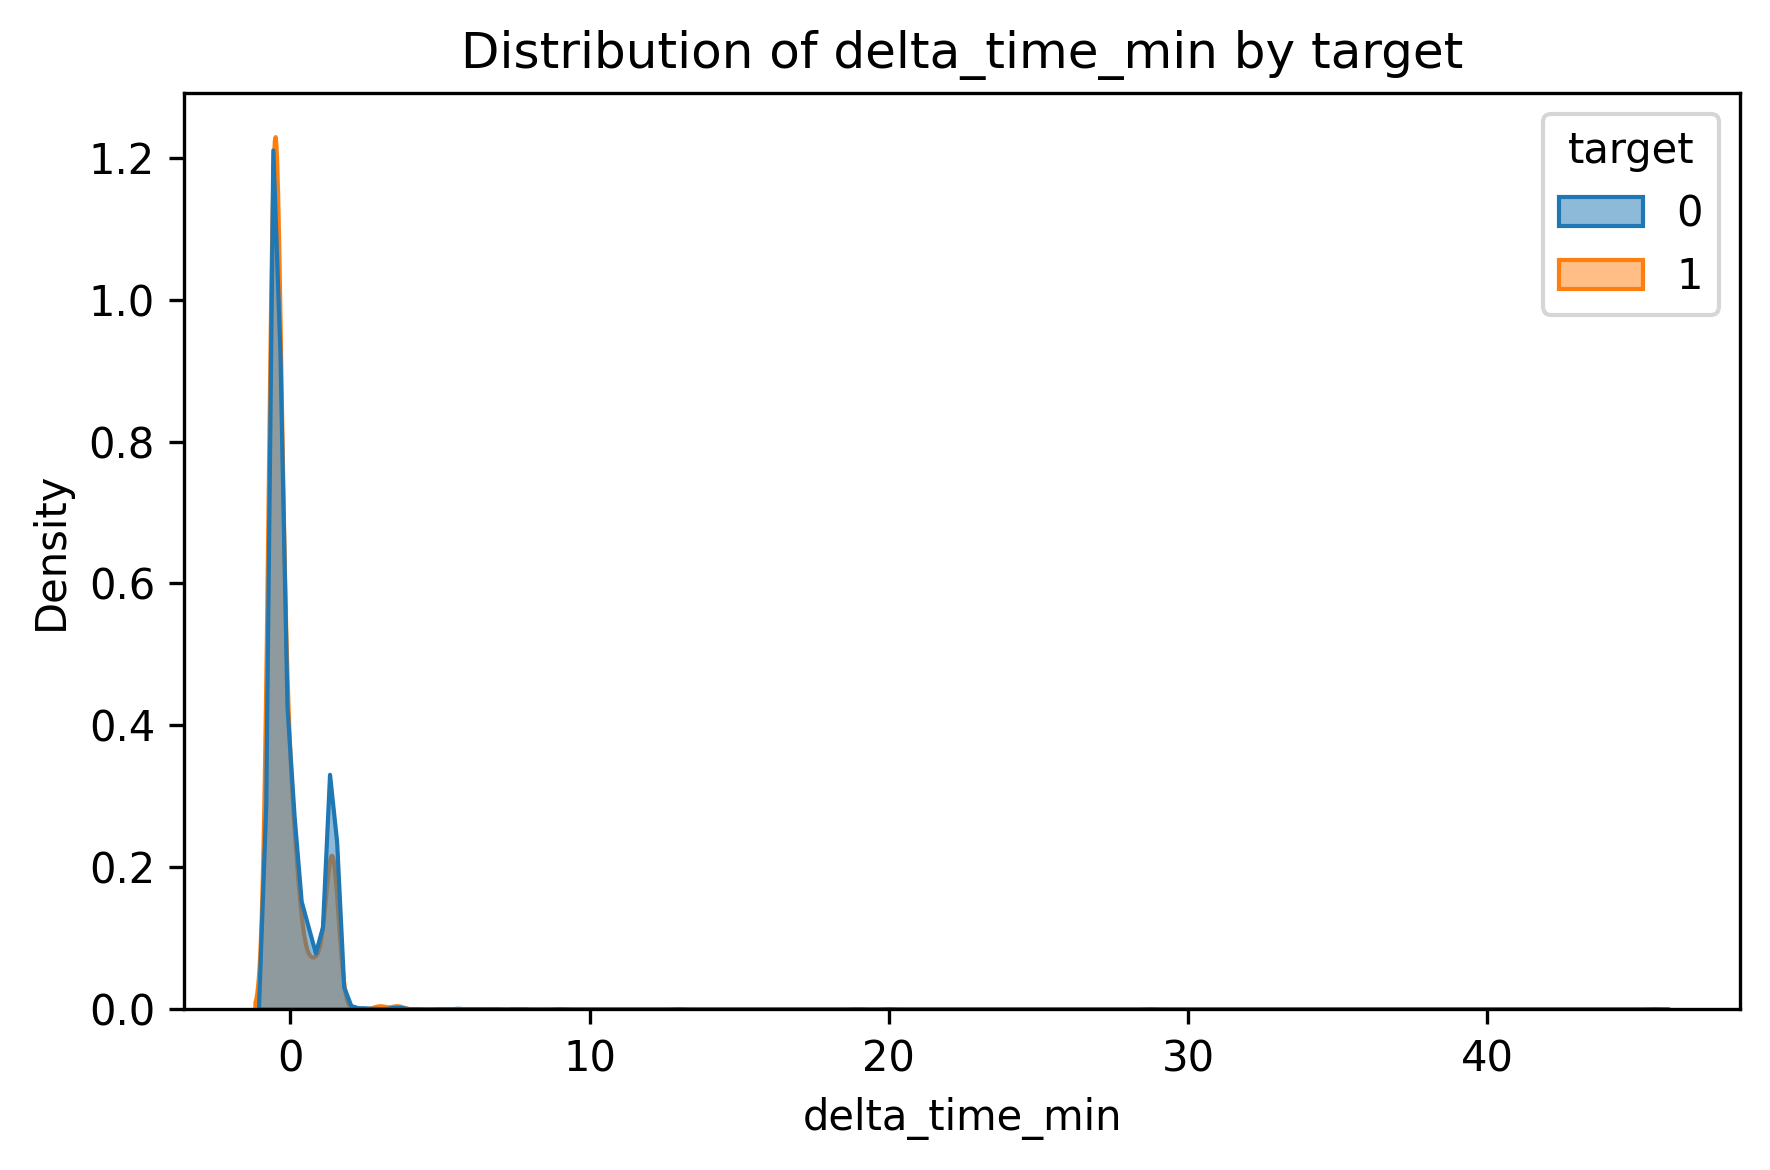

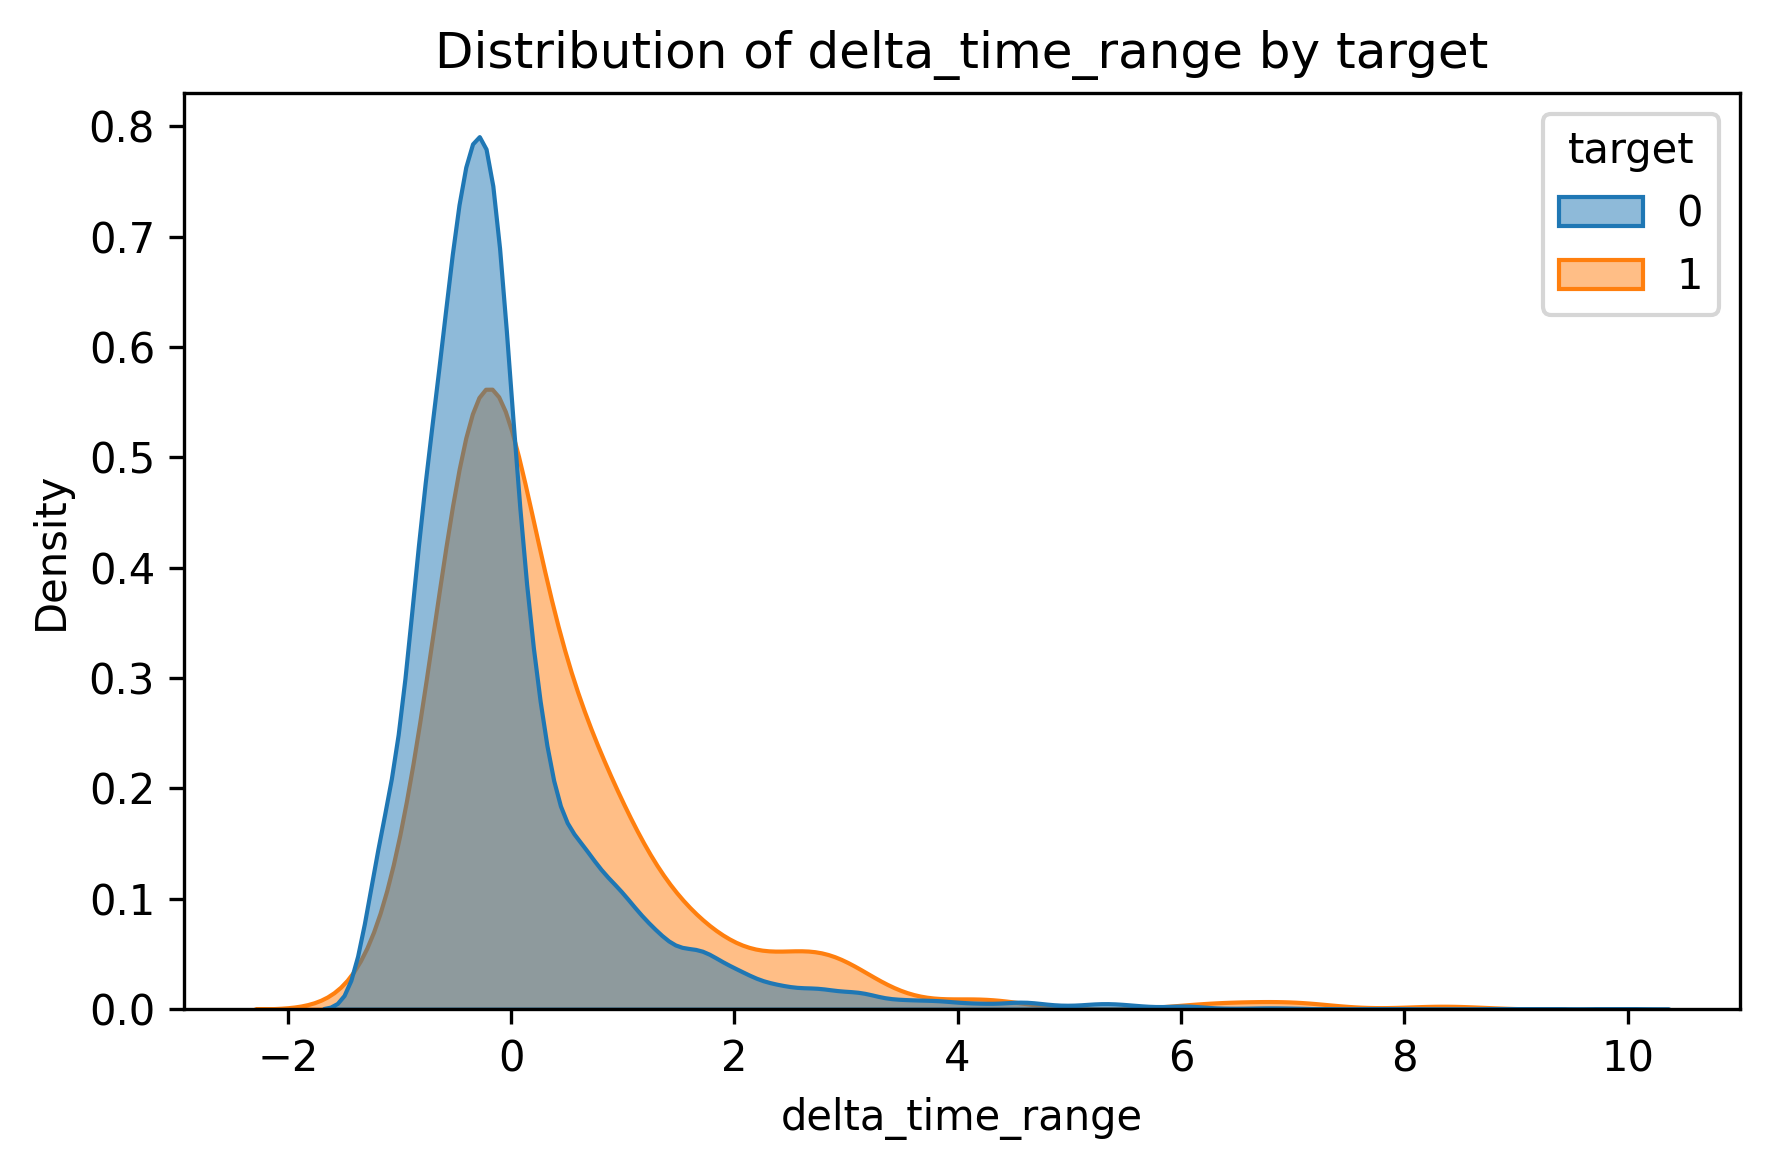

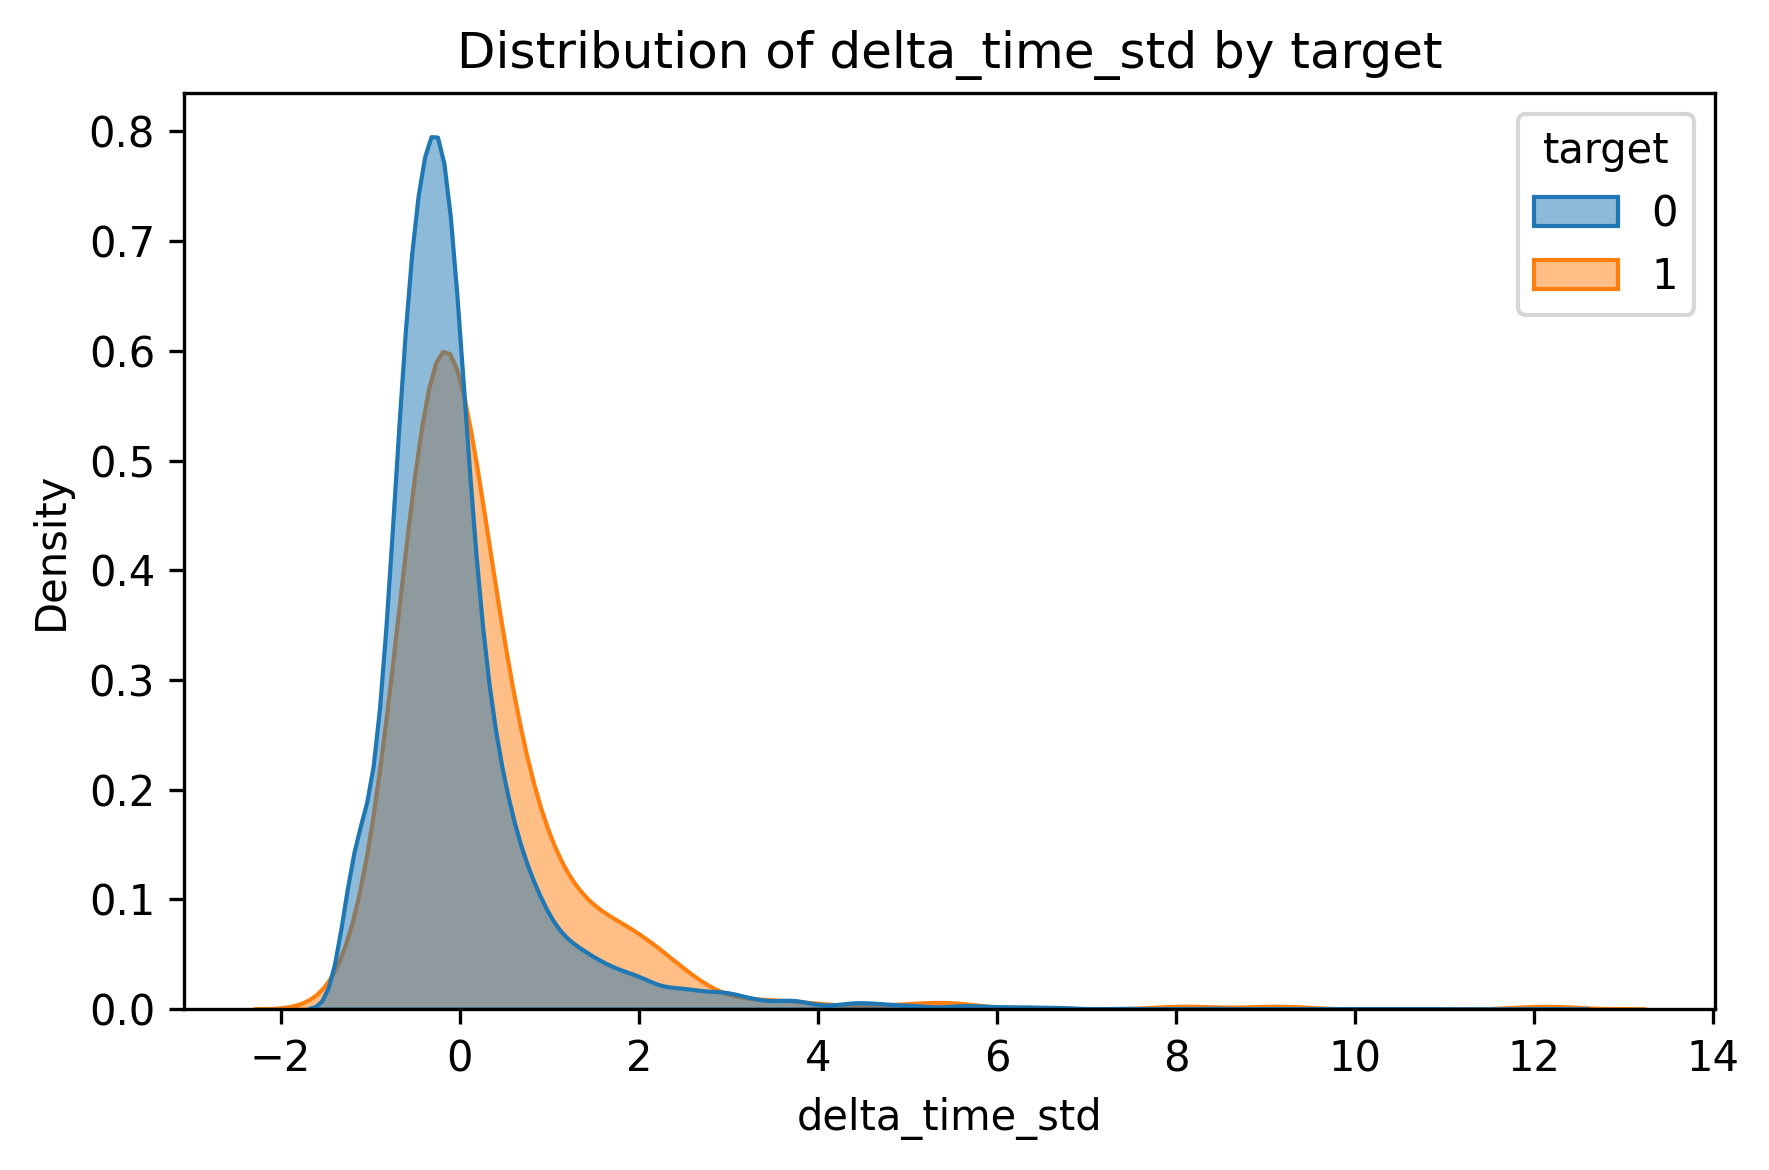

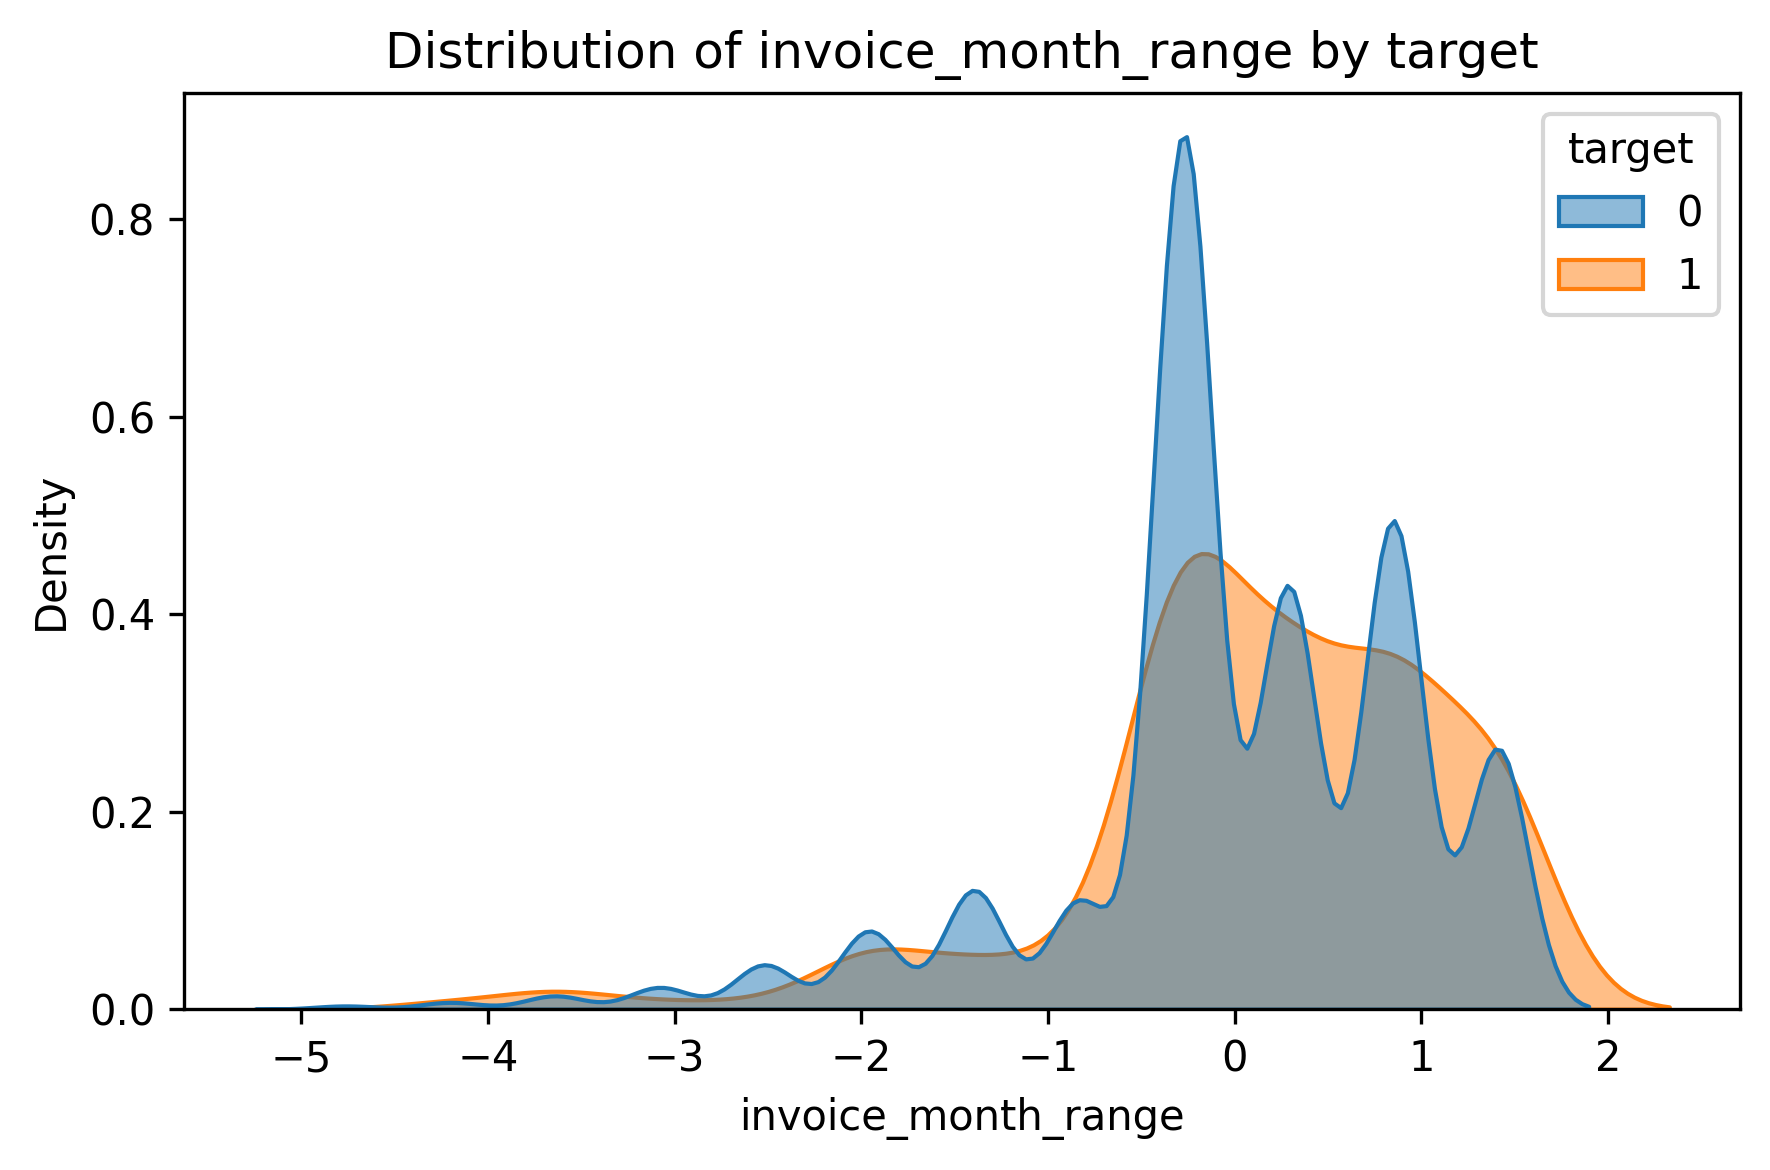

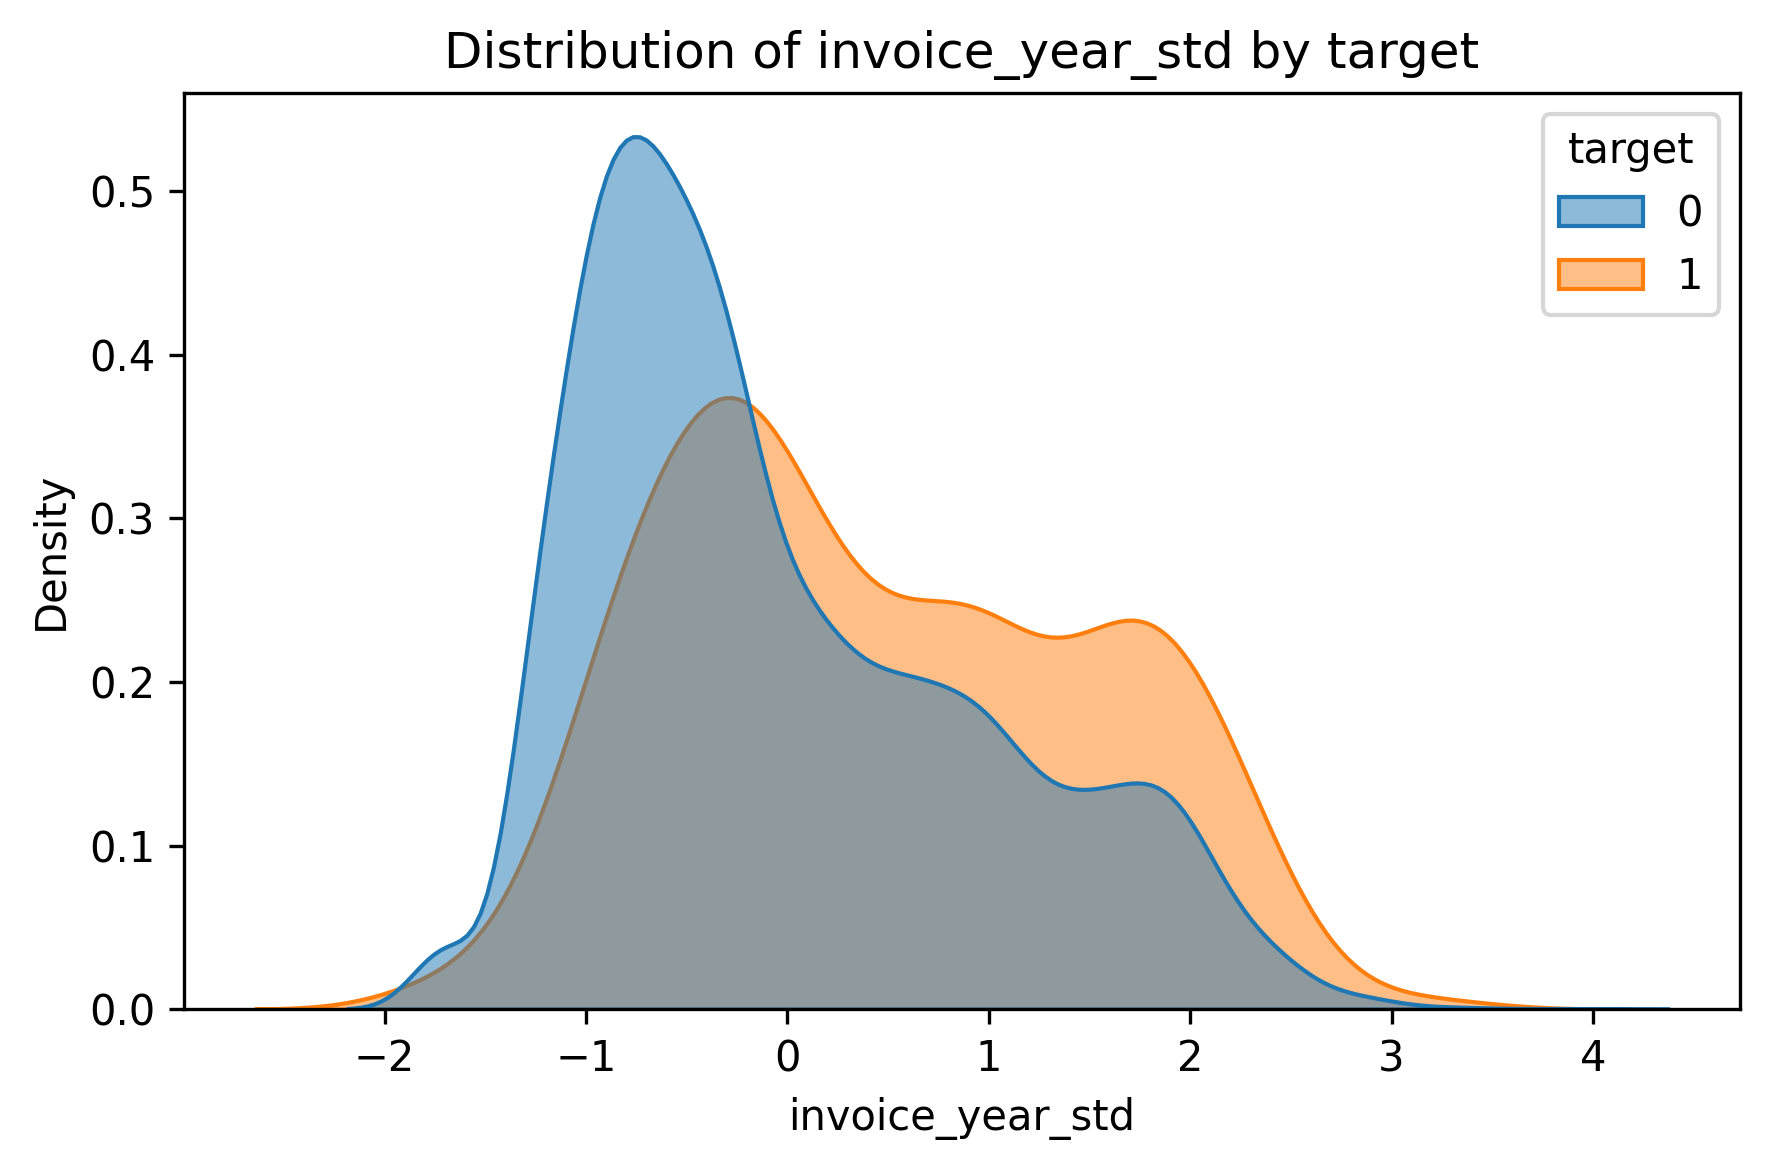

Column 'is_weekday_rate' not found in df_comb. Skipping plot.


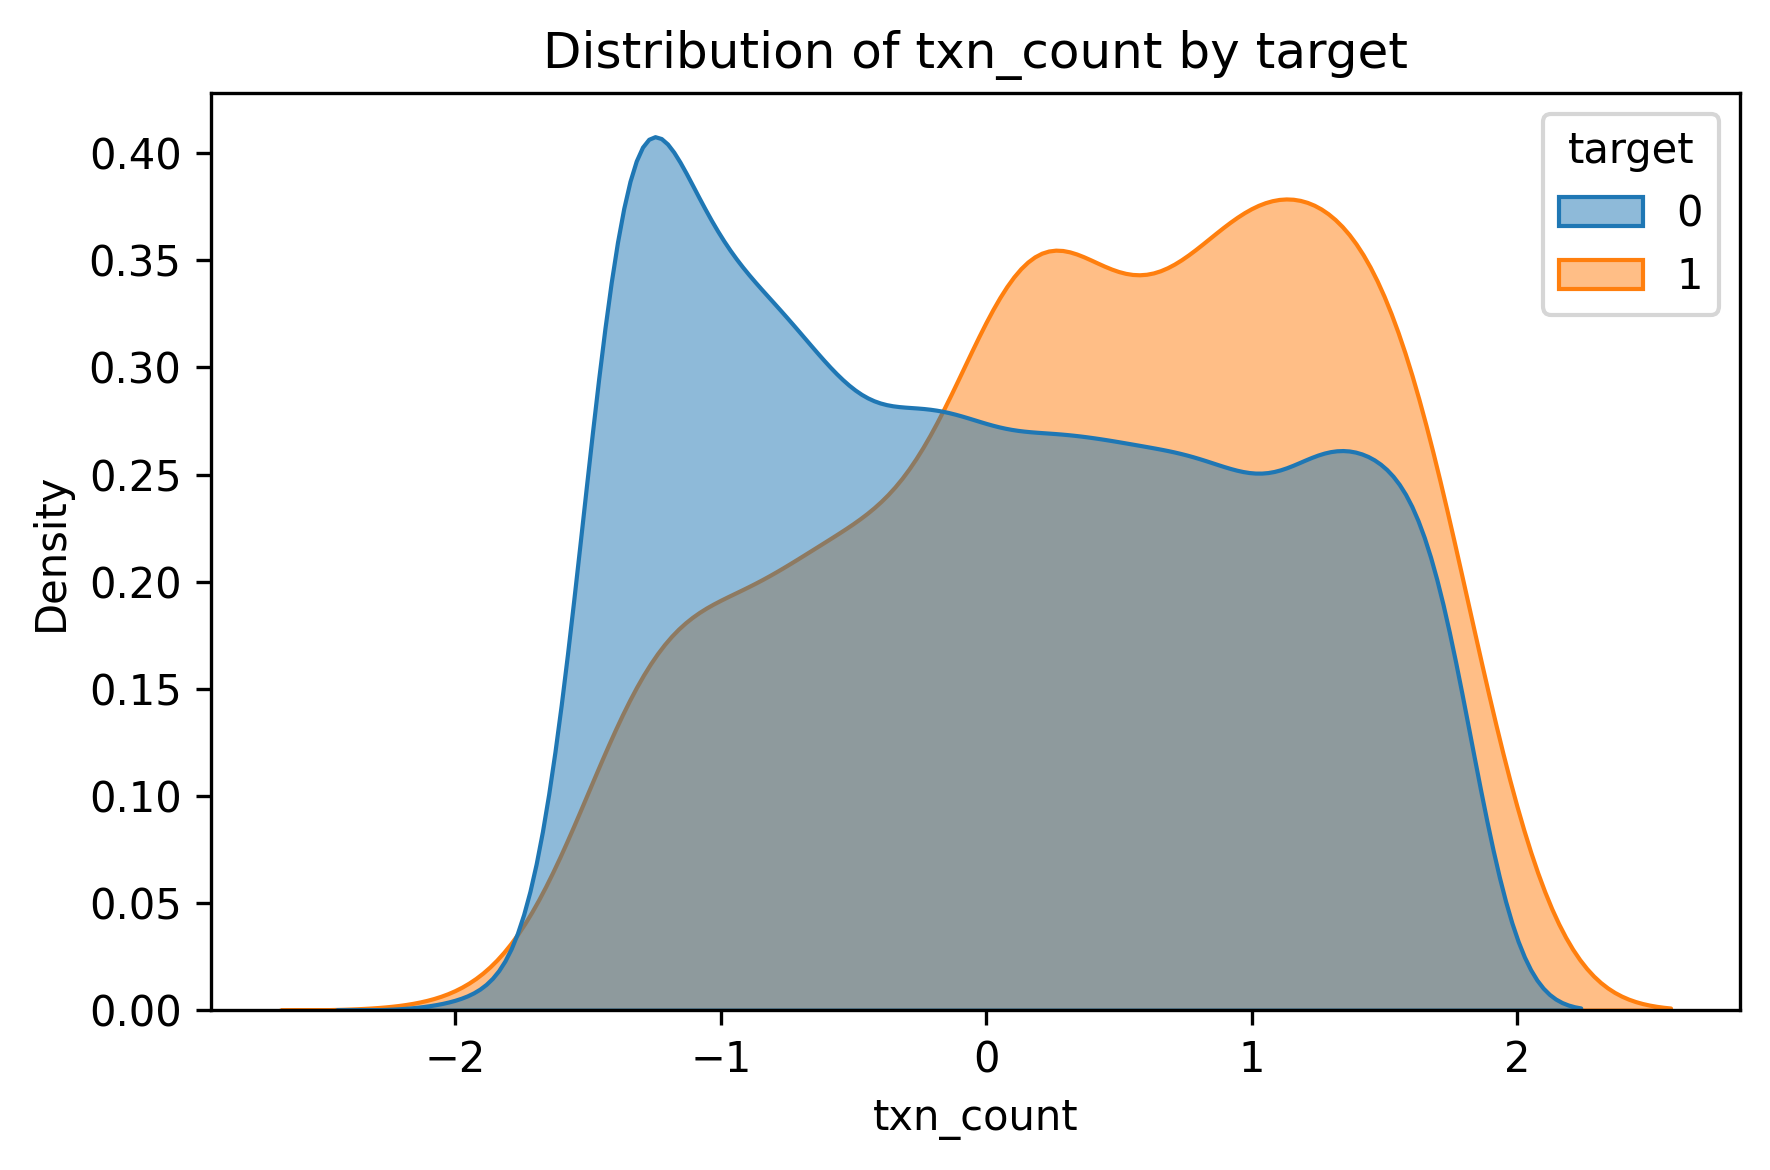

In [ ]:
for col in numeric_features_2:
    if col in df_comb.columns:  # Add this check
        plt.figure(figsize=(6, 4))
        sns.kdeplot(data=df_comb, x=col, hue=target, fill=True, common_norm=False, alpha=0.5)
        plt.title(f"Distribution of {col} by {target}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' not found in df_comb. Skipping plot.") # Optional: add a message for skipped columns

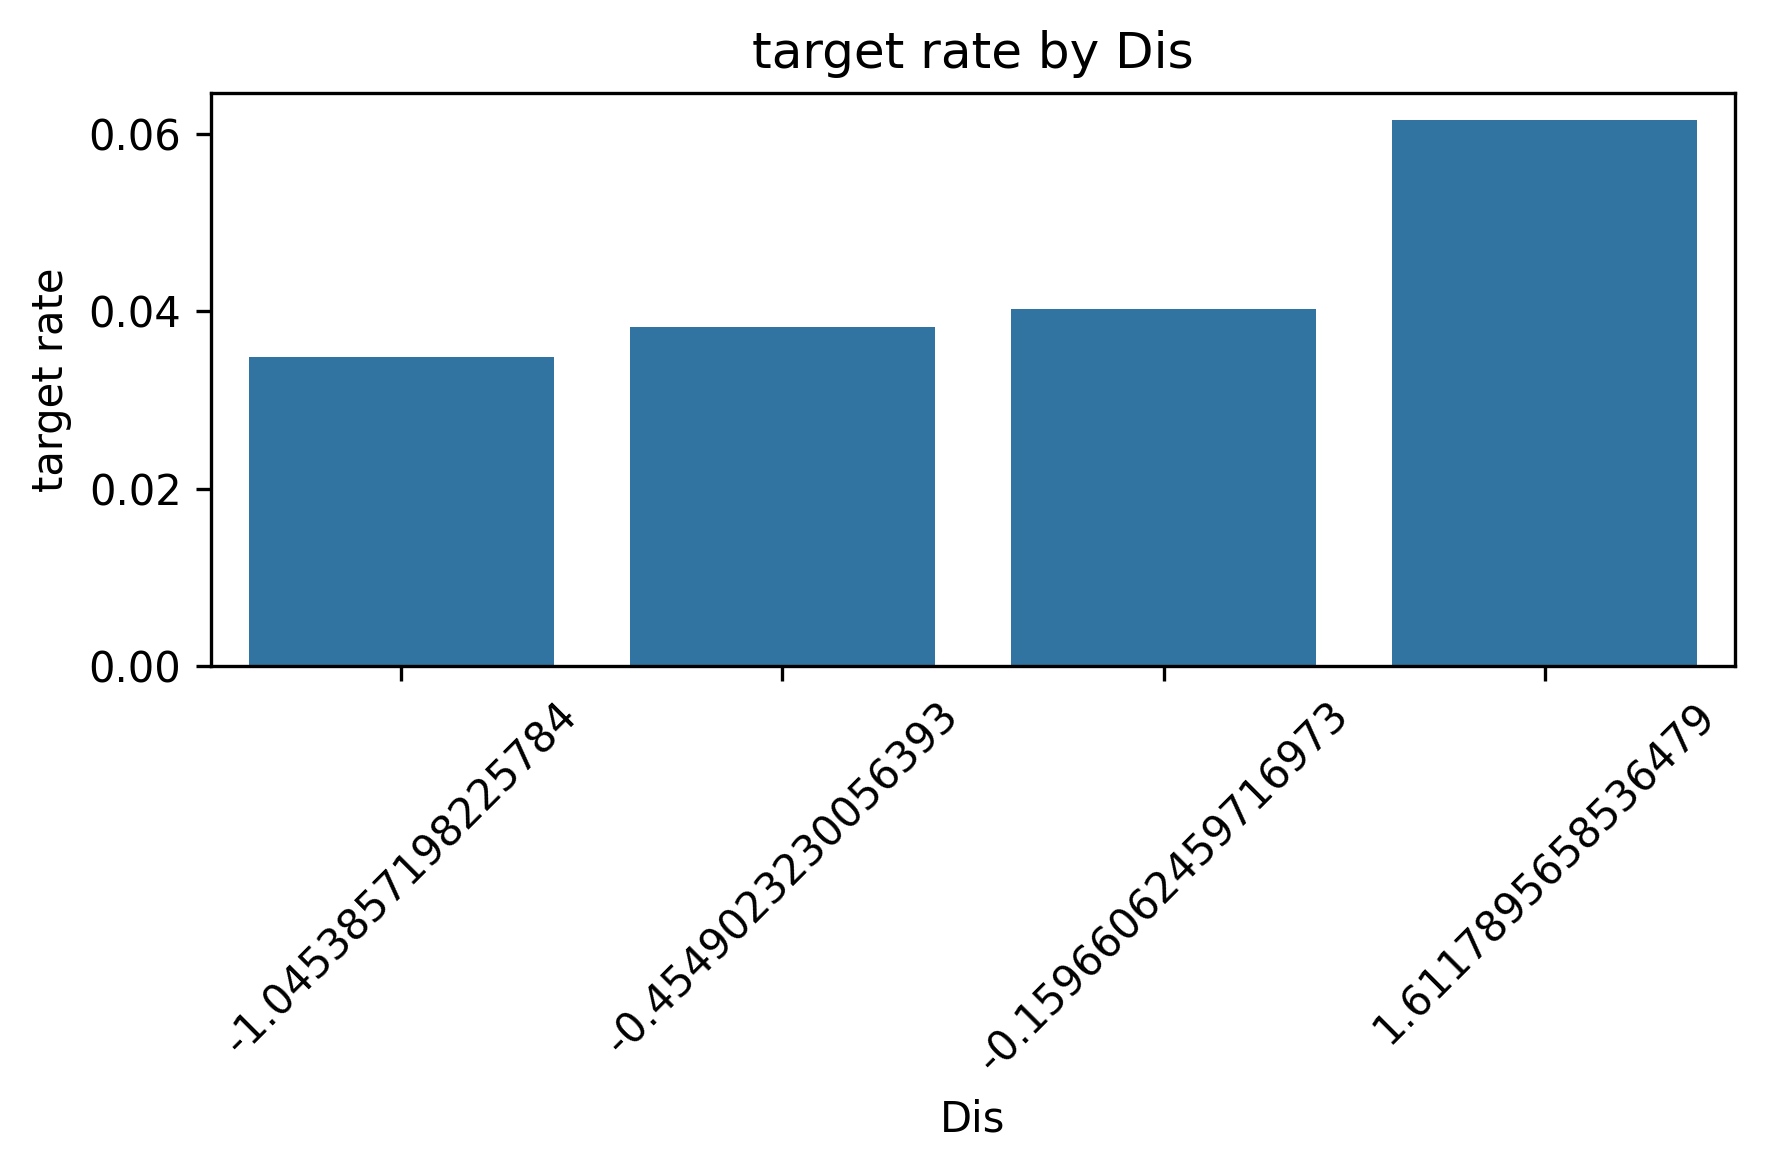

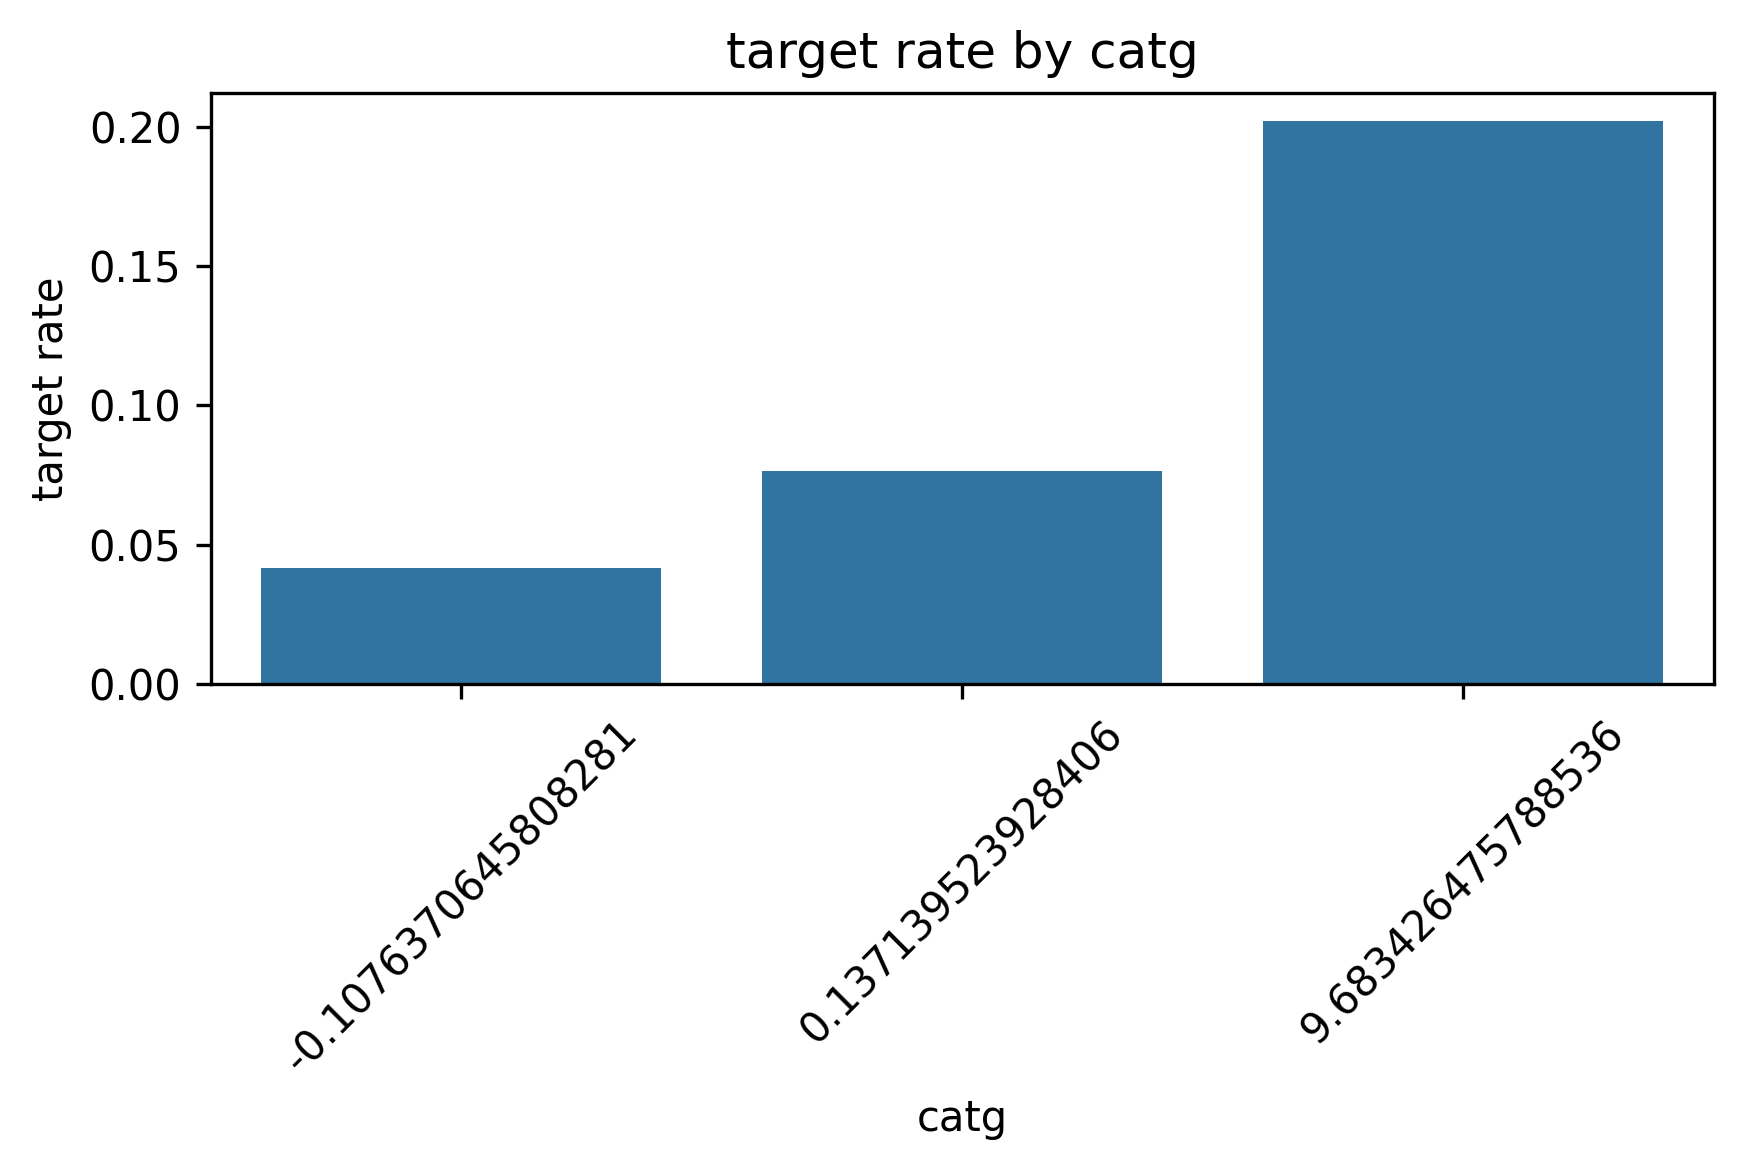

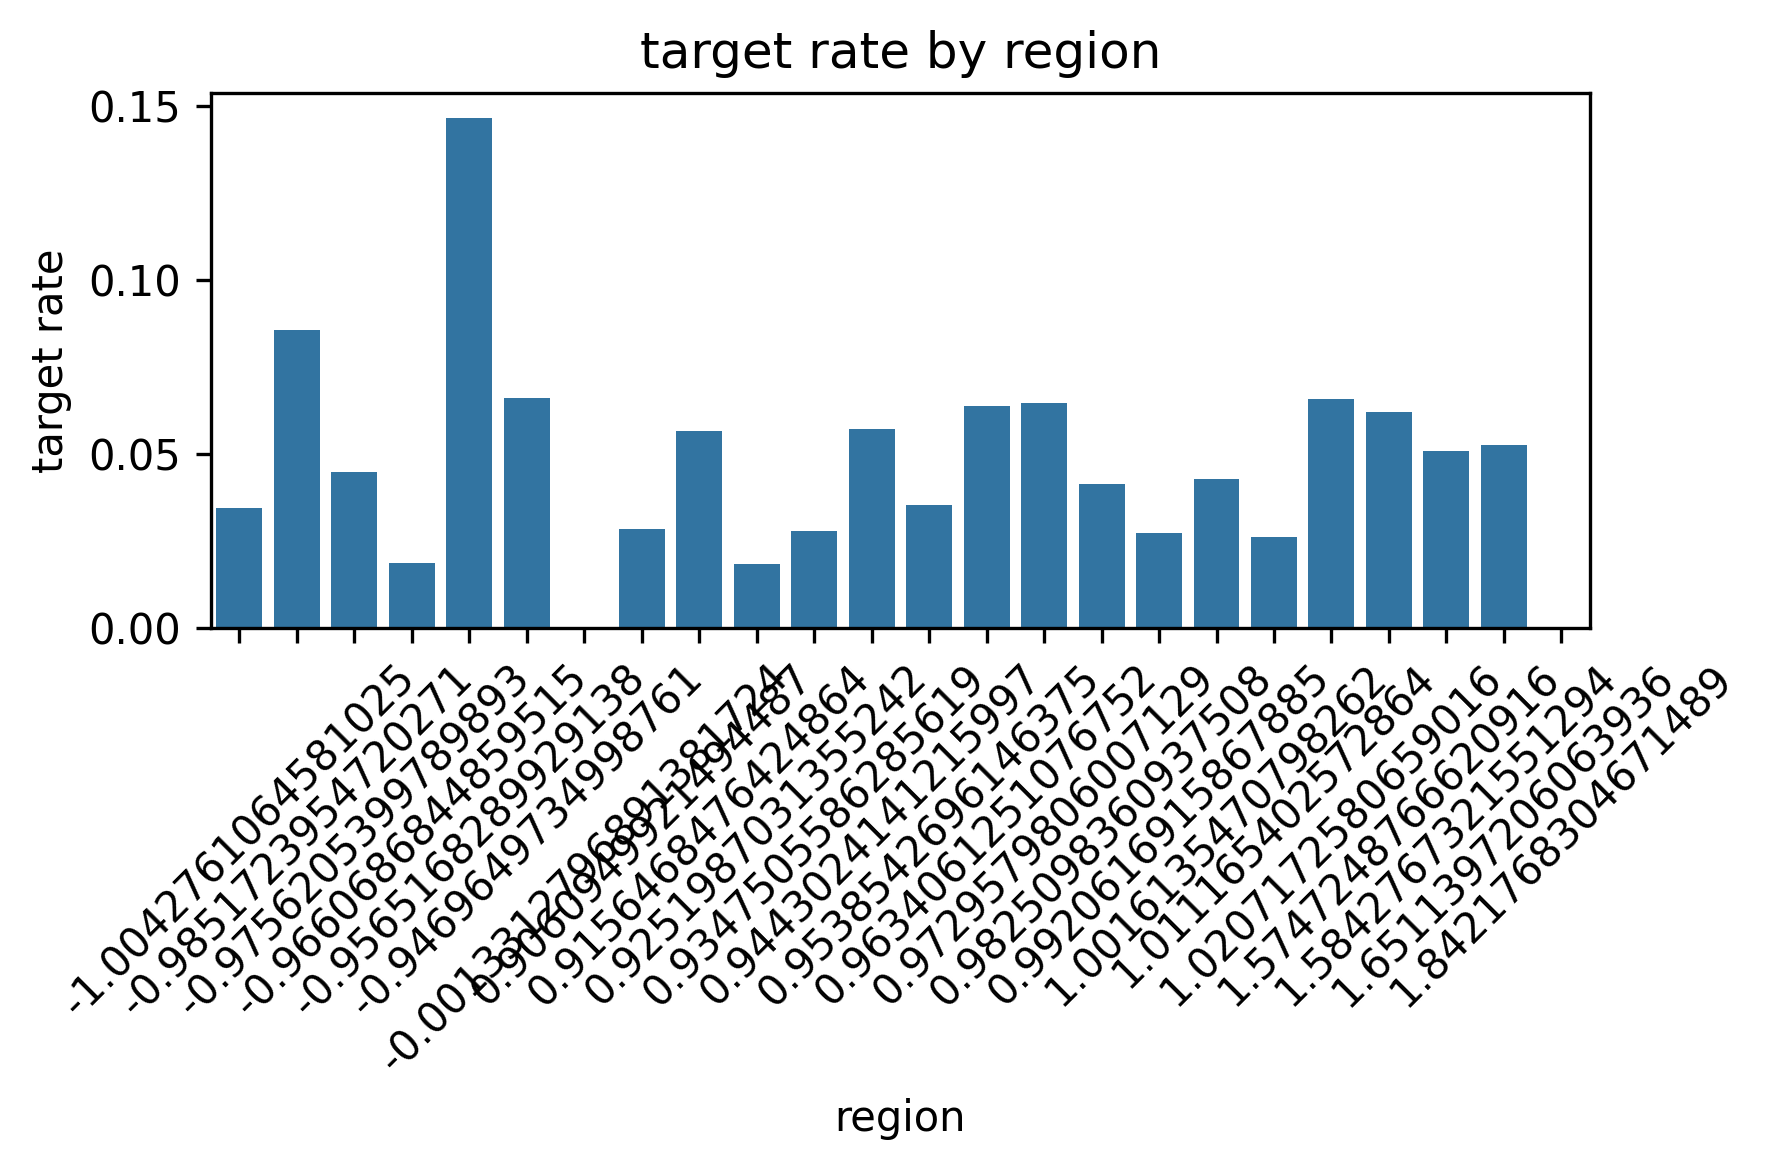

In [ ]:
for col in categorical_features:
    plt.figure(figsize=(6, 4))
    mean_target = df.groupby(col)[target].mean().sort_values(ascending=False)
    sns.barplot(x=mean_target.index, y=mean_target.values)
    plt.title(f"{target} rate by {col}")
    plt.ylabel(f"{target} rate")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


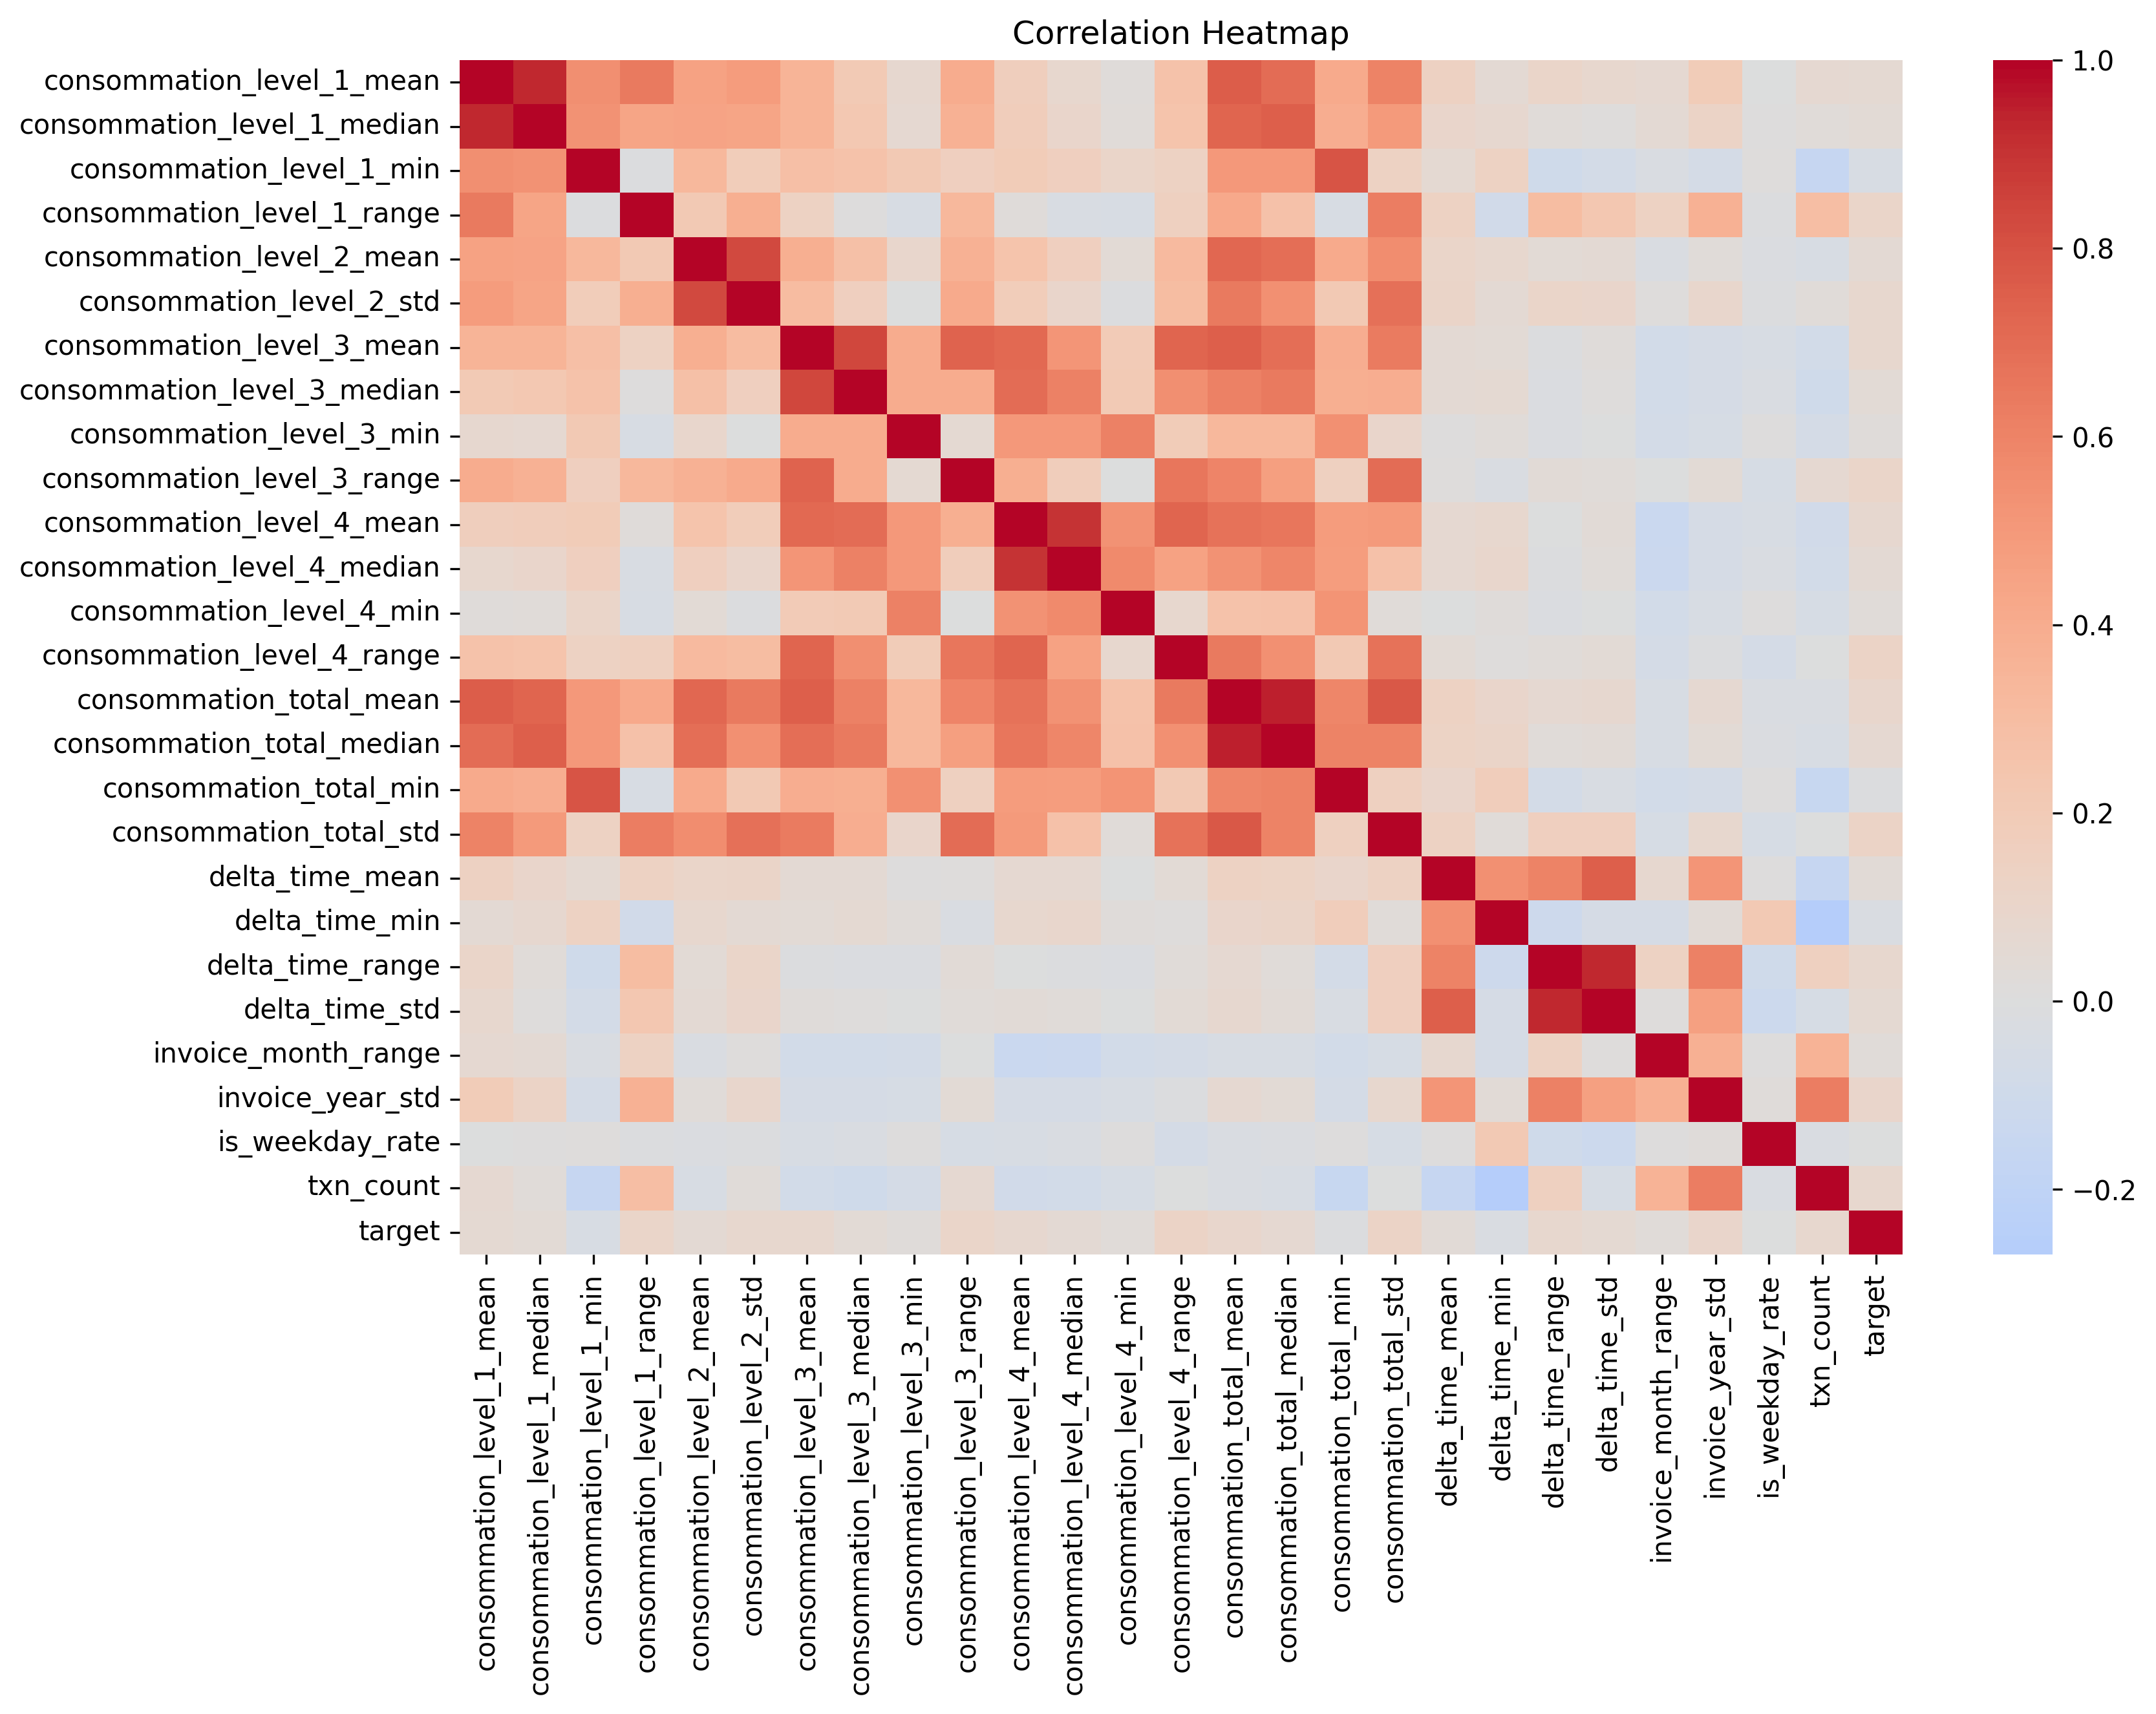

In [ ]:
plt.figure(figsize=(12, 8))
corr = df[numeric_features_2 + [target]].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap")
plt.show()


# 5. Modeling

## LightGBM: Best Performing Trial (the Third)

✅ Found saved GOSS+ROS (v2) model & params. Loading...
[LightGBM] [Warning] feature_fraction is set=0.7224162561505759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7224162561505759
[LightGBM] [Warning] lambda_l2 is set=0.5242957927635179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5242957927635179
[LightGBM] [Warning] lambda_l1 is set=4.593612608346885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.593612608346885
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.

🔹 Performance (v2, Threshold = 0.5691):
ROC-AUC:  0.74529
Accuracy: 0.90549
Precision:0.16384
Recall:   0.28155
F1-score: 0.20714

🔹 Classification Report (v2):
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2246
           1       0.16      0.28      0.2

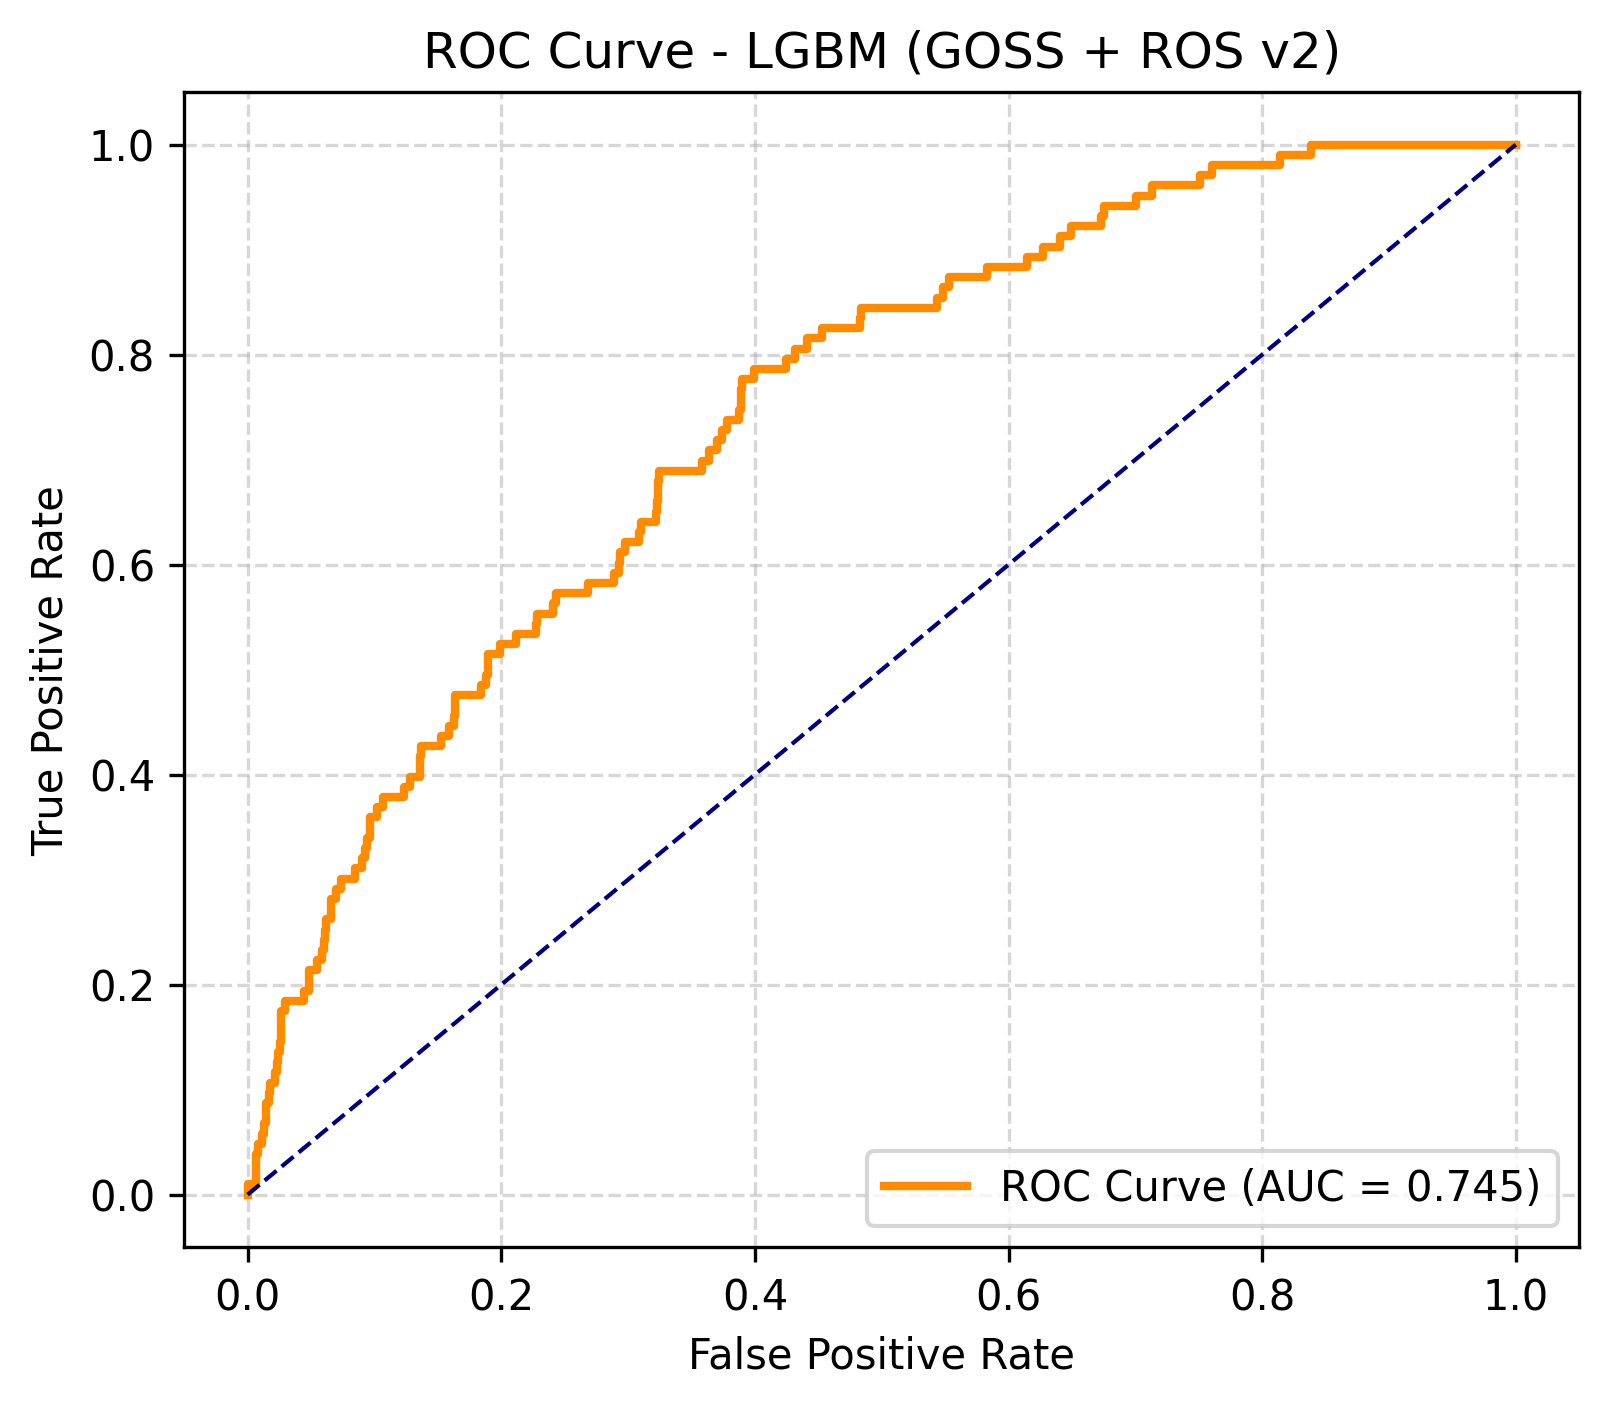

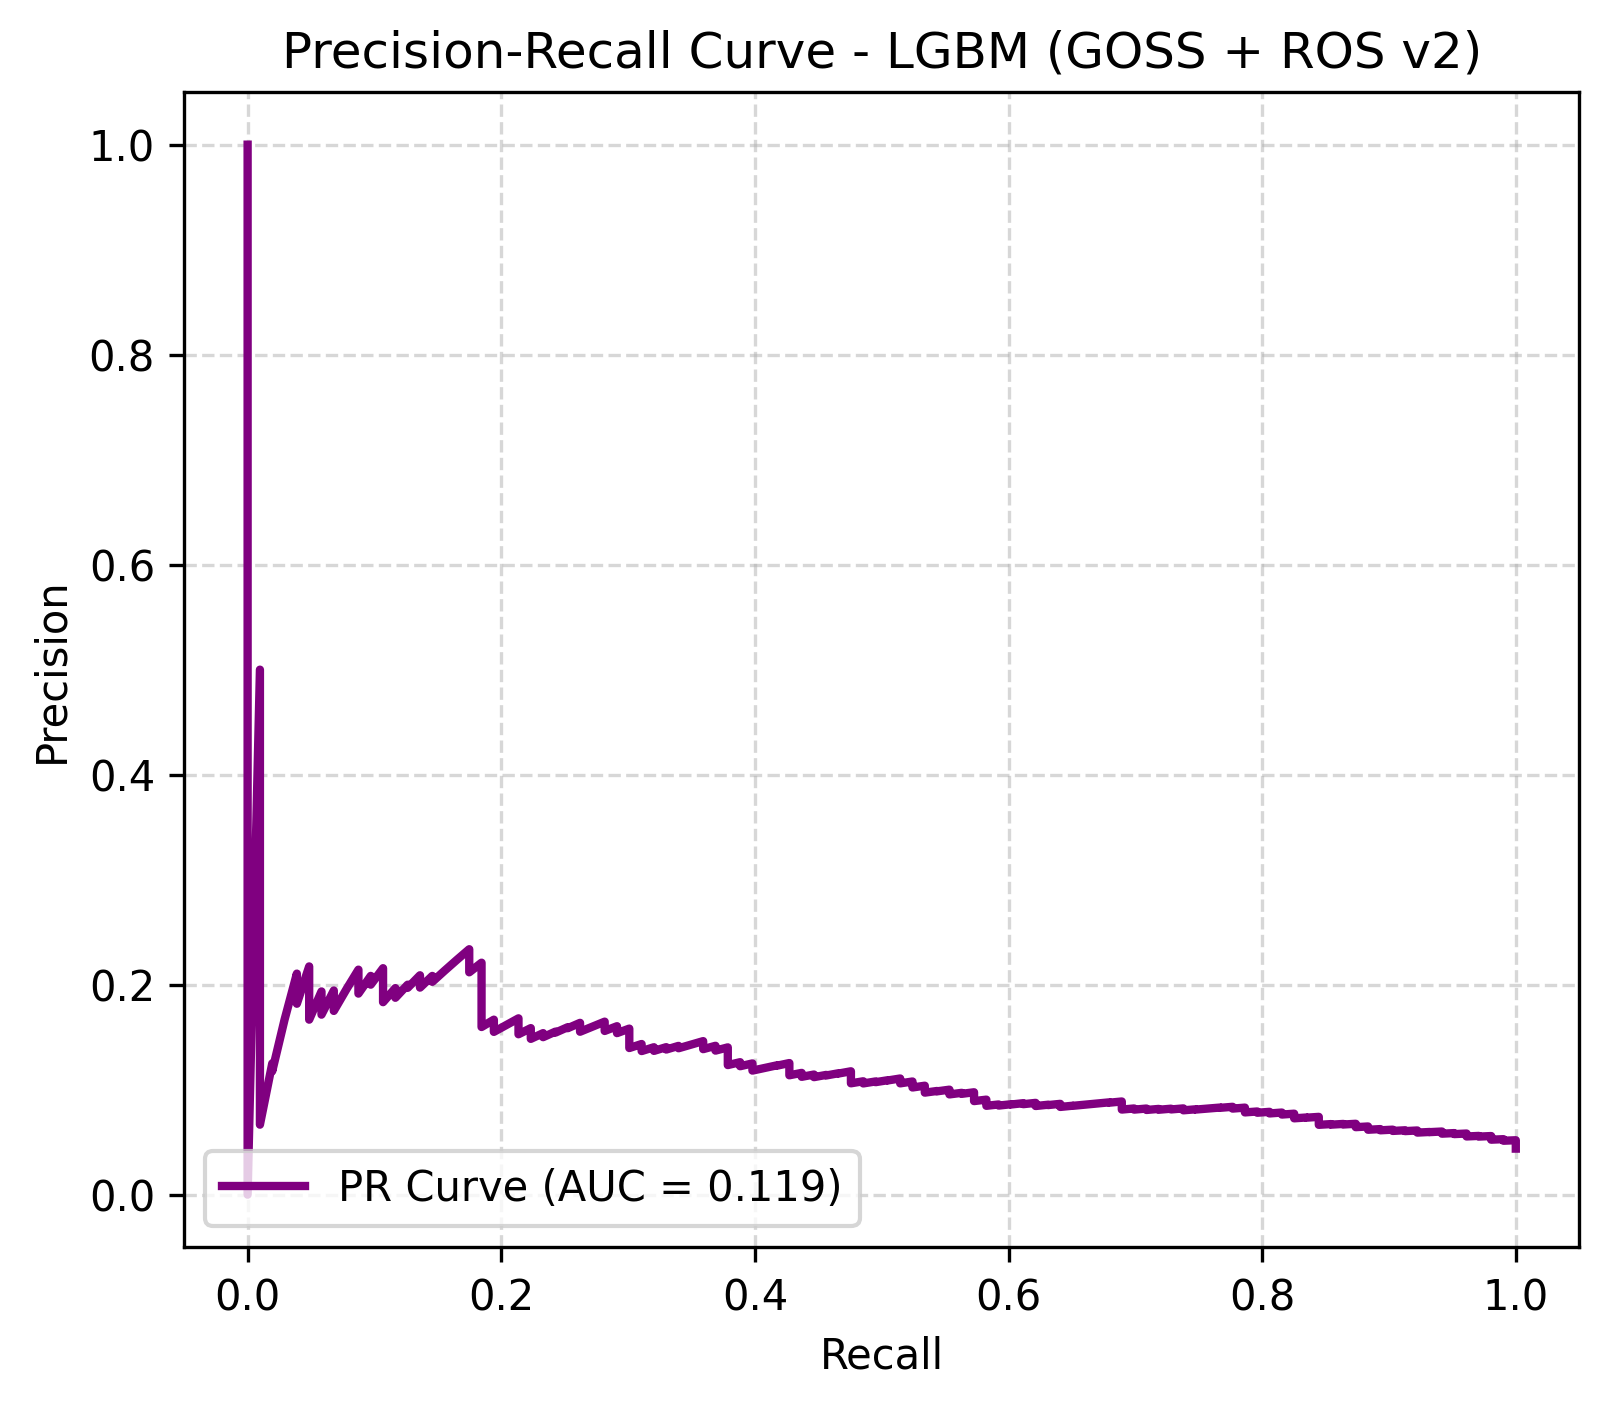

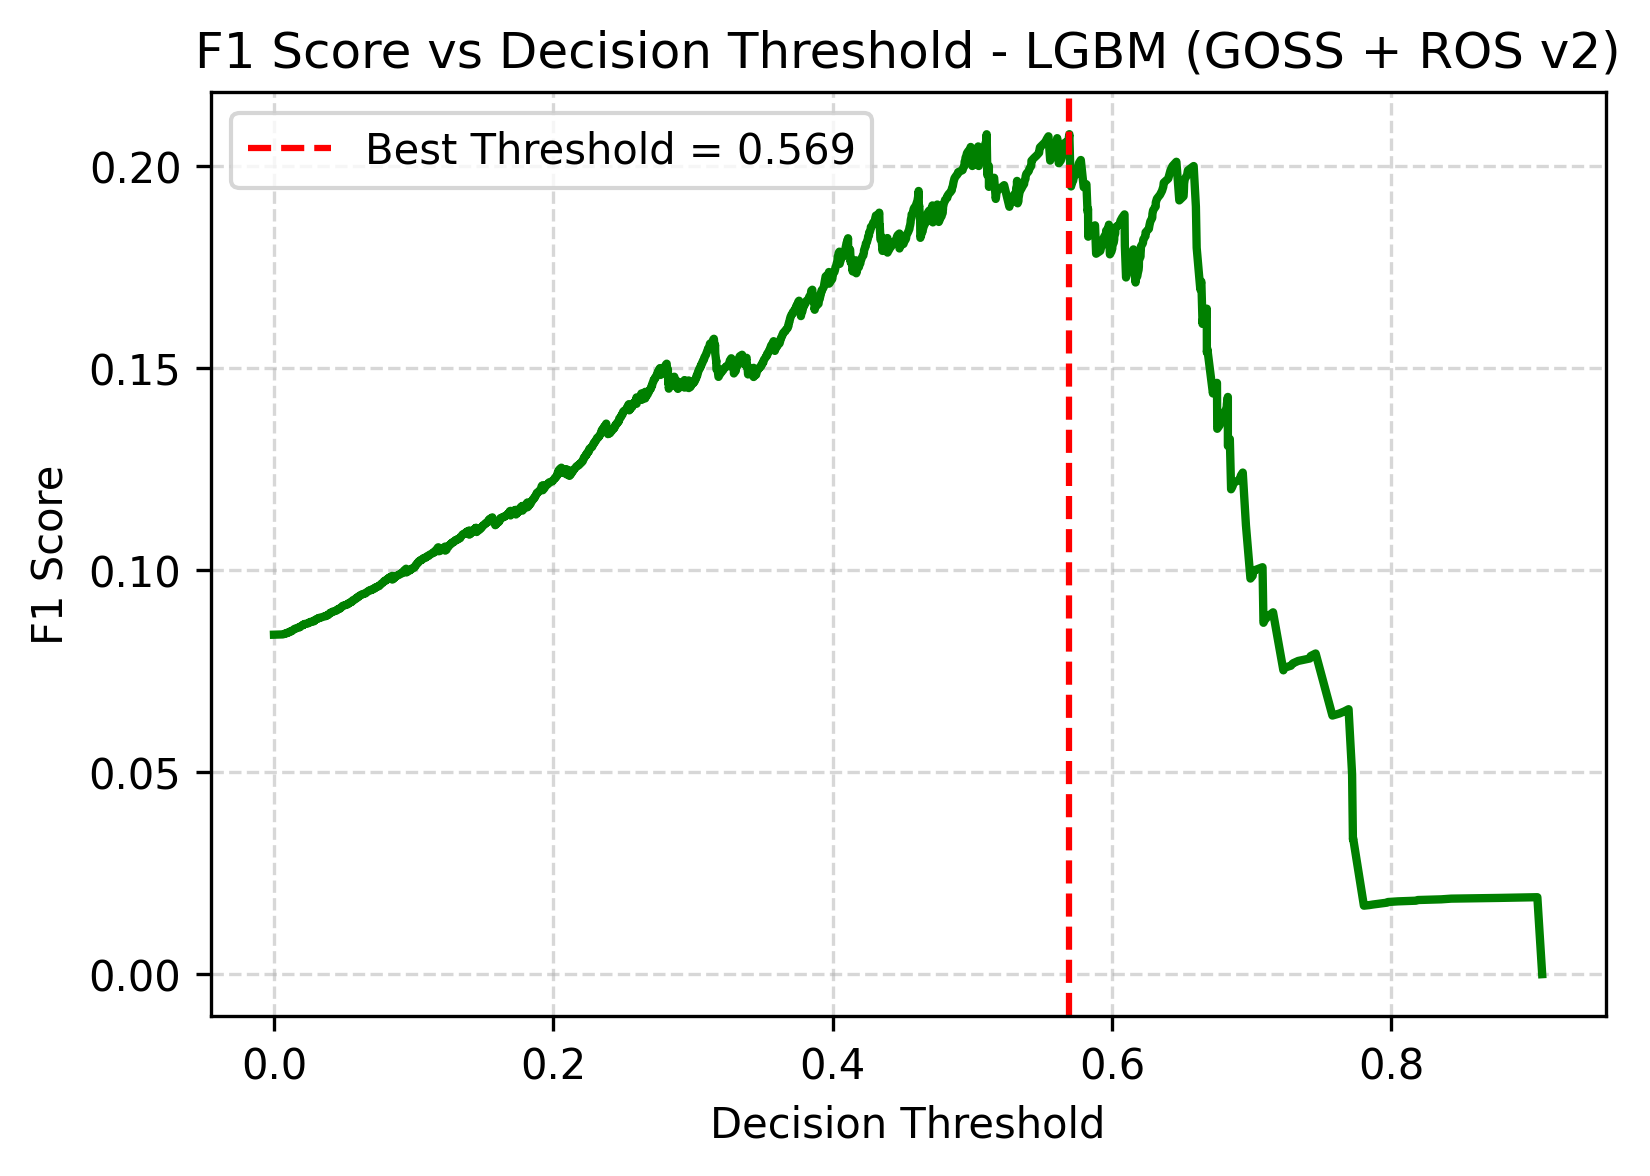

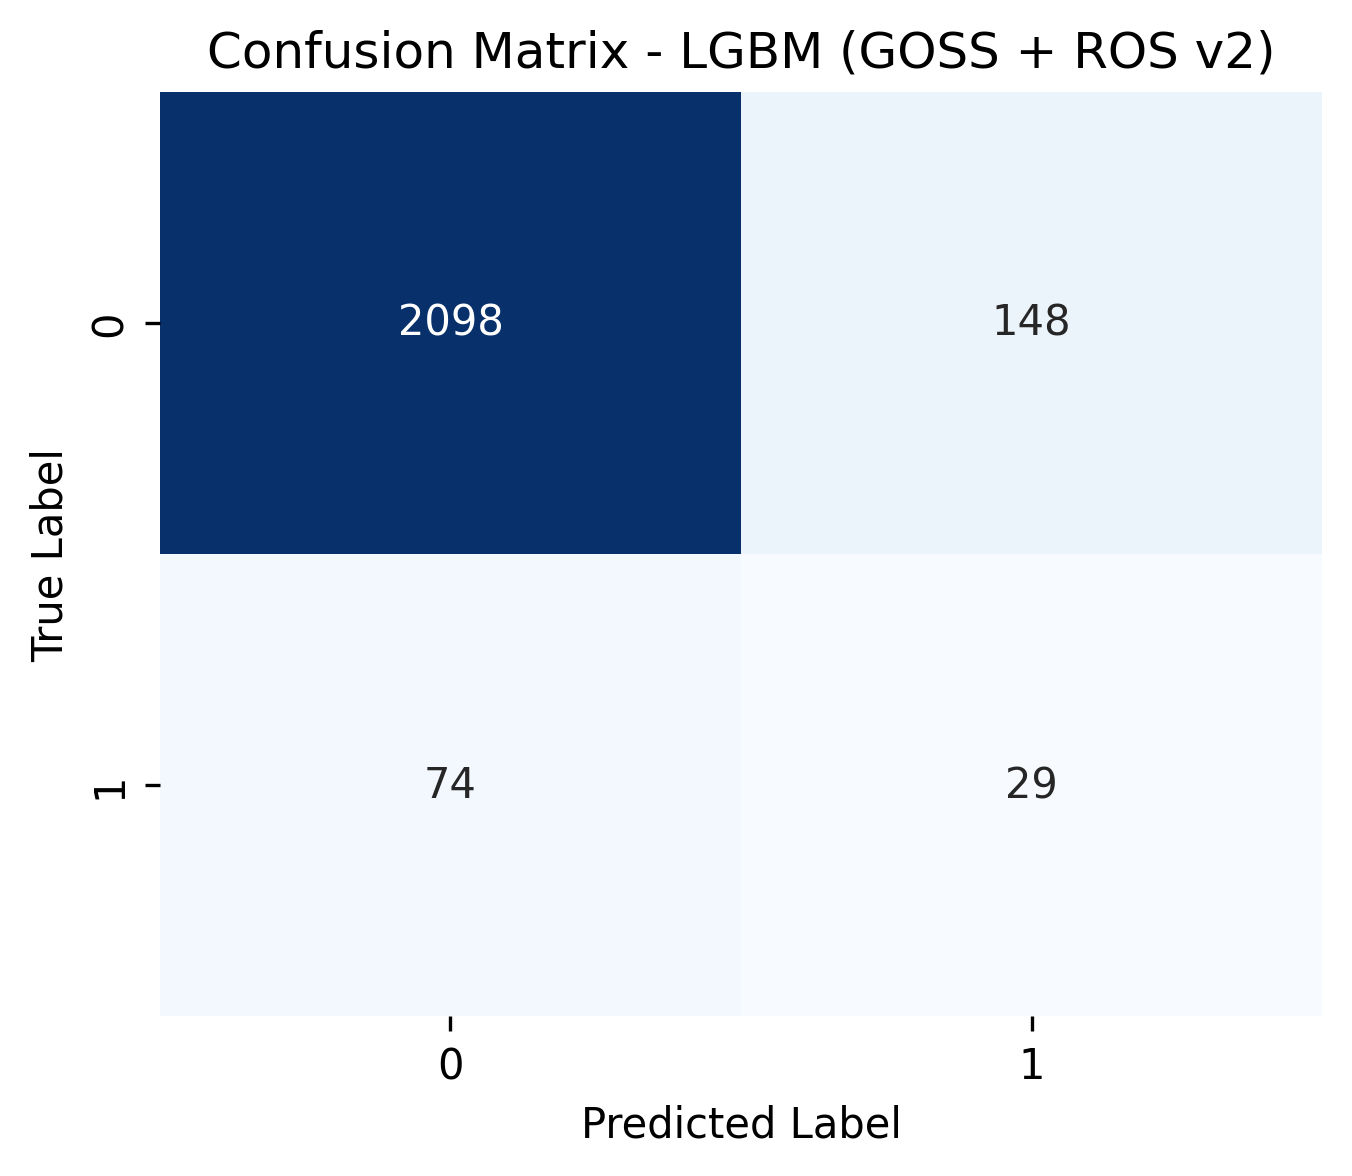

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  if (await self.run_code(code, result,  async_=asy)):


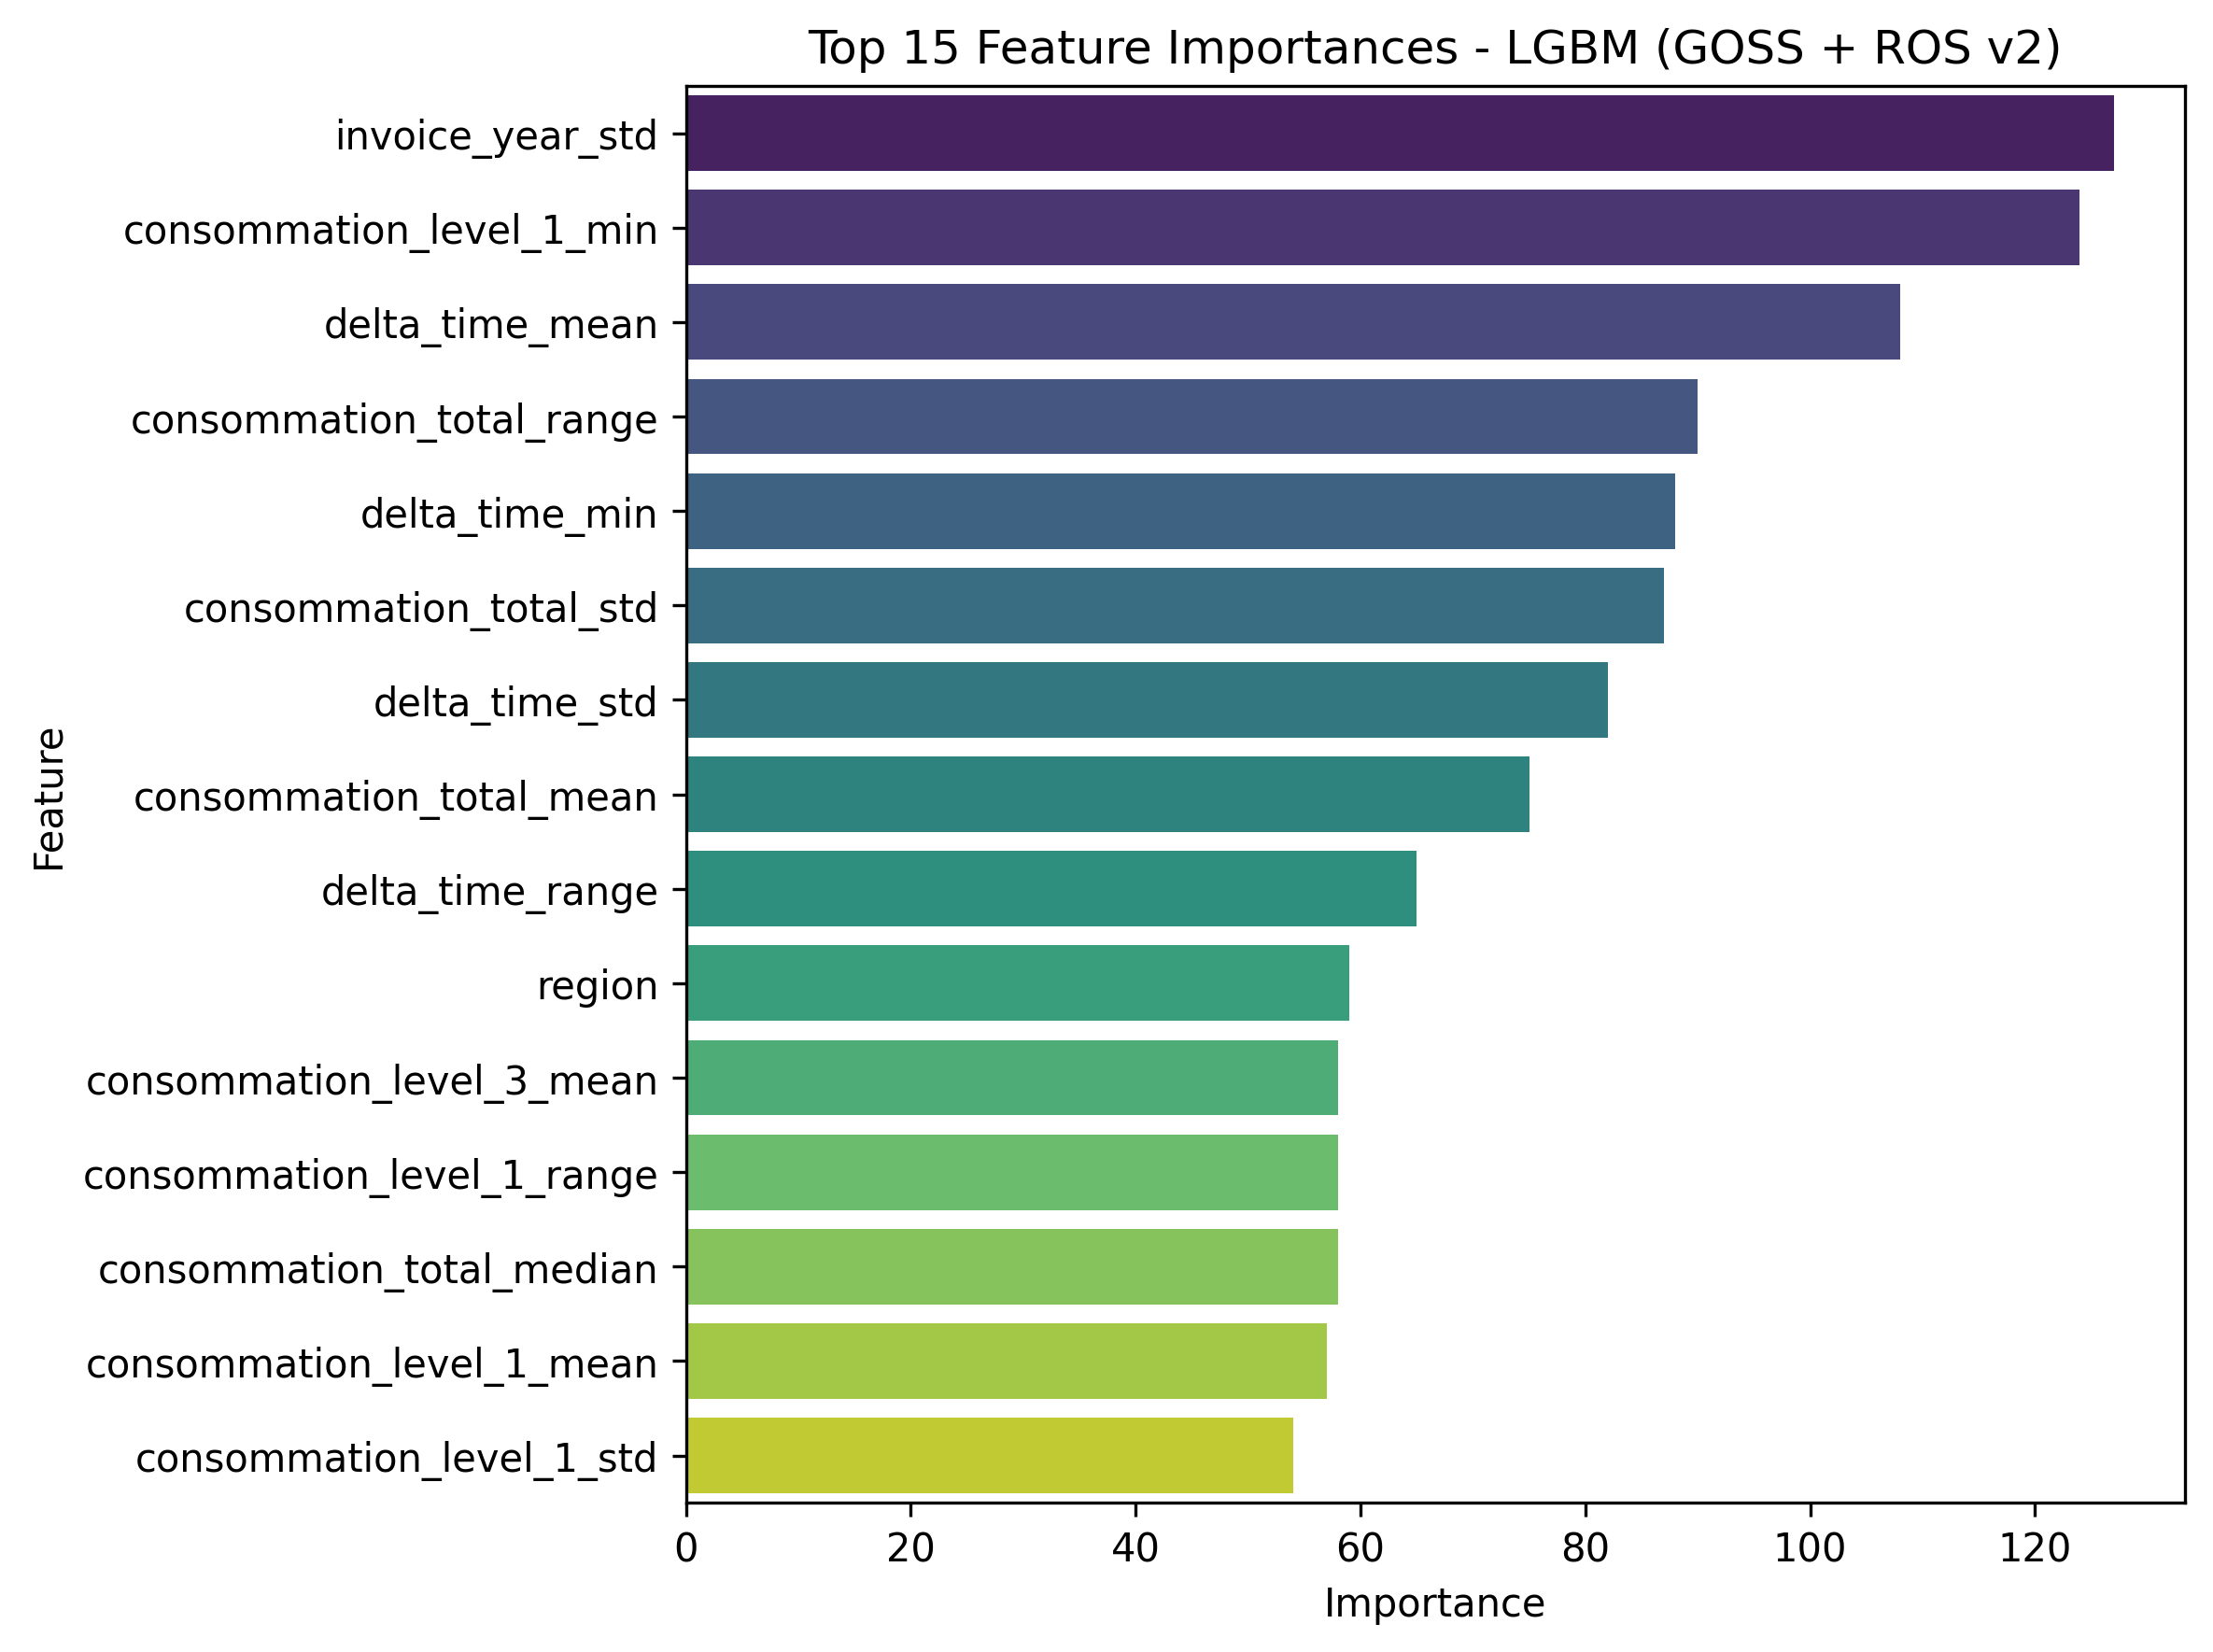

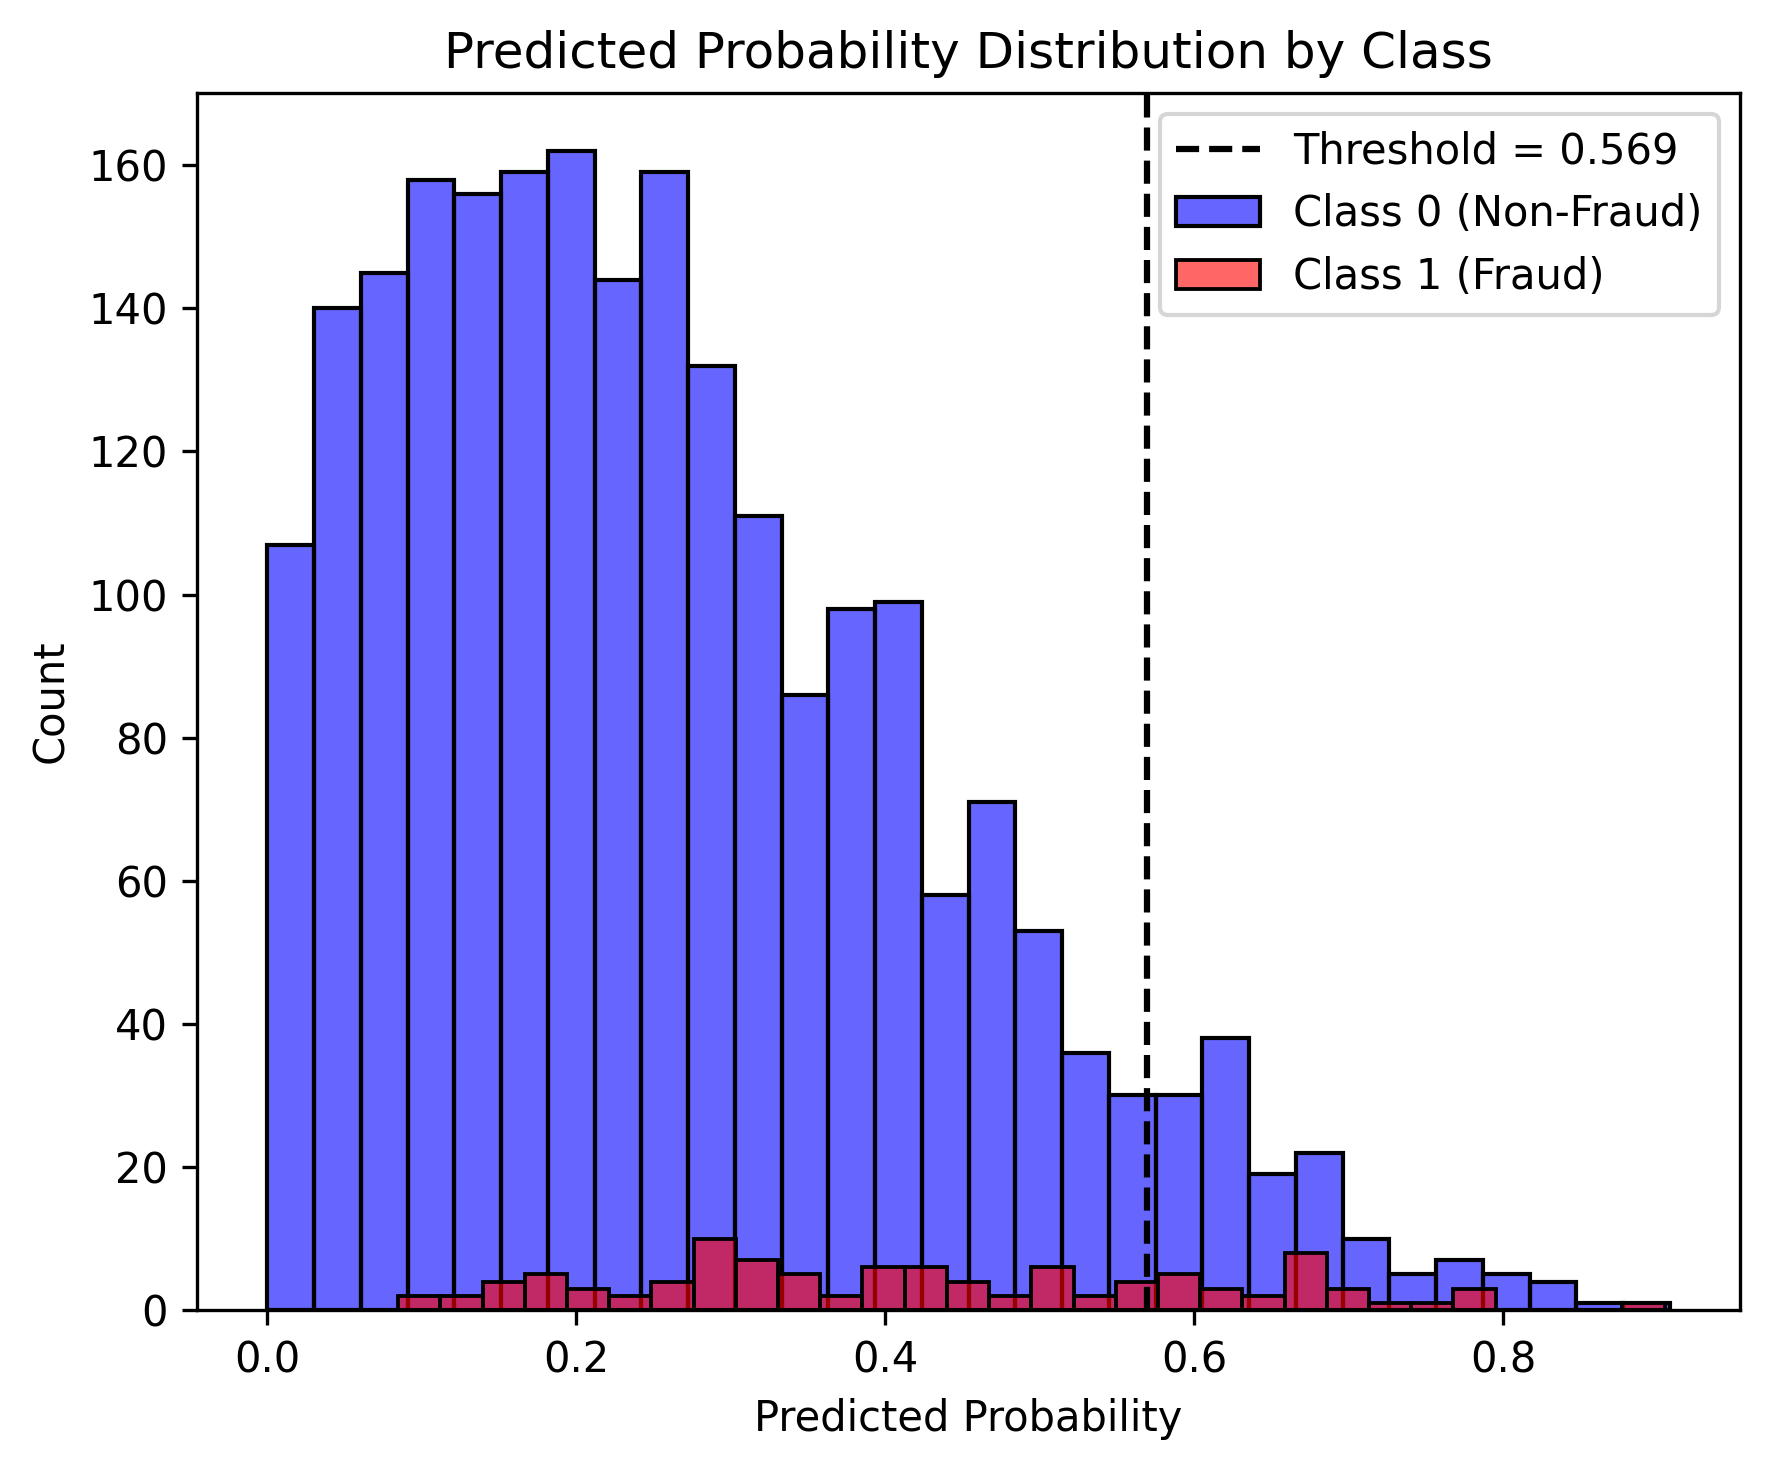


✅ All visualizations (ROC, PR, F1 threshold, Confusion Matrix, Feature Importance, Probability Distribution) completed successfully.


In [ ]:
# ==========================================
# LGBM + GOSS + RandomOverSampler (per-fold)
# BayesSearchCV (5-fold), TEST eval with F1-opt threshold
# Uses existing X_train, X_test, y_train, y_test in memory
# (v2: N_ITER=25, with visualization)
# ==========================================

# Install skopt if not already installed
try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer
except ImportError:
    !pip install scikit-optimize
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, classification_report,
    precision_recall_curve, roc_curve, confusion_matrix, auc
)
import lightgbm as lgb
import joblib, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Preprocessing (assuming function exists)
# -------------------------------
X_train, X_test = preprocess_train_test(X_train, X_test)

# -------------------------------
# Config
# -------------------------------
N_FOLDS = 5
N_ITER  = 25
RANDOM_STATE = 42
MODEL_PATH  = "final_lgb_goss_ros_v2.pkl"
PARAMS_PATH = "best_lgb_goss_ros_params_v2.pkl"
PRED_CSV    = "lgb_goss_ros_predictions_v2.csv"

# -------------------------------
# Define pipeline: ROS -> LGBM(GOSS)
# -------------------------------
ros = RandomOverSampler(
    sampling_strategy=0.5,
    random_state=RANDOM_STATE
)

clf = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="goss",
    n_estimators=1500,
    class_weight=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe = Pipeline([
    ("ros", ros),
    ("clf", clf),
])

# -------------------------------
# Search space (note clf__ prefix)
# -------------------------------
search_space = {
    "clf__num_leaves": Integer(31, 255),
    "clf__max_depth": Integer(-1, 12),
    "clf__learning_rate": Real(0.01, 0.2, prior="log-uniform"),
    "clf__min_child_samples": Integer(5, 100),
    "clf__feature_fraction": Real(0.5, 1.0),
    "clf__lambda_l1": Real(0.0, 5.0),
    "clf__lambda_l2": Real(0.0, 5.0),
    # GOSS-specific:
    "clf__top_rate": Real(0.1, 0.5),
    "clf__other_rate": Real(0.0, 0.5),
}

# -------------------------------
# Train or load model
# -------------------------------
if os.path.exists(MODEL_PATH) and os.path.exists(PARAMS_PATH):
    print("✅ Found saved GOSS+ROS (v2) model & params. Loading...")
    best_params = joblib.load(PARAMS_PATH)
    final_model = joblib.load(MODEL_PATH)
else:
    print("🚀 Running BayesSearchCV (v2) with per-fold ROS (5-fold Stratified)...")
    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    opt = BayesSearchCV(
        estimator=pipe,
        search_spaces=search_space,
        n_iter=N_ITER,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE,
        refit=True,
        return_train_score=False
    )

    opt.fit(X_train, y_train)
    best_params = opt.best_params_
    print("✅ Best Params (v2):\n", best_params)
    print("✅ Best CV ROC-AUC (v2): {:.5f}".format(opt.best_score_))

    final_model = opt.best_estimator_
    joblib.dump(best_params, PARAMS_PATH)
    joblib.dump(final_model, MODEL_PATH)
    print("💾 Saved model ->", MODEL_PATH)
    print("💾 Saved params ->", PARAMS_PATH)

# -------------------------------
# Evaluate on TEST with F1-opt threshold
# -------------------------------
probs = final_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[max(best_idx - 1, 0)]
y_pred = (probs >= best_threshold).astype(int)

roc_auc = roc_auc_score(y_test, probs)
accuracy = np.mean(y_test == y_pred)
precision_val = precision_score(y_test, y_pred, zero_division=0)
recall_val = recall_score(y_test, y_pred, zero_division=0)
f1_val = f1_score(y_test, y_pred, zero_division=0)

print("\n🔹 Performance (v2, Threshold = {:.4f}):".format(best_threshold))
print(f"ROC-AUC:  {roc_auc:.5f}")
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision:{precision_val:.5f}")
print(f"Recall:   {recall_val:.5f}")
print(f"F1-score: {f1_val:.5f}")

print("\n🔹 Classification Report (v2):")
print(classification_report(y_test, y_pred, zero_division=0))

# Save predictions (v2)
pd.DataFrame({"y_true": y_test, "y_pred": y_pred, "proba": probs}).to_csv(PRED_CSV, index=False)
print("📁 Saved predictions ->", PRED_CSV)

# -------------------------------
# 7. Visualization of Model Performance
# -------------------------------

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LGBM (GOSS + ROS v2)')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Precision-Recall Curve
pr_auc = auc(recall, precision)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LGBM (GOSS + ROS v2)')
plt.legend(loc="lower left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# F1-Score vs Threshold
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_scores[:-1], color='green', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.3f}')
plt.xlabel('Decision Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Decision Threshold - LGBM (GOSS + ROS v2)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - LGBM (GOSS + ROS v2)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature Importance
try:
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': final_model.named_steps['clf'].feature_importances_
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(8,6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
    plt.title('Top 15 Feature Importances - LGBM (GOSS + ROS v2)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("⚠️ Could not plot feature importance:", e)

# Probability Distribution Plot
plt.figure(figsize=(6,5))
sns.histplot(probs[y_test == 0], bins=30, color='blue', label='Class 0 (Non-Fraud)', alpha=0.6)
sns.histplot(probs[y_test == 1], bins=30, color='red', label='Class 1 (Fraud)', alpha=0.6)
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Threshold = {best_threshold:.3f}')
plt.title('Predicted Probability Distribution by Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

print("\n✅ All visualizations (ROC, PR, F1 threshold, Confusion Matrix, Feature Importance, Probability Distribution) completed successfully.")


In [ ]:
# ==========================================
# 8. Save Performance Metrics and High-DPI Plots
# ==========================================
import os

# Directory for saving all outputs
SAVE_DIR = "lgbm_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1️⃣ Save metrics summary
metrics_dict = {
    "ROC_AUC": roc_auc,
    "Accuracy": accuracy,
    "Precision": precision_val,
    "Recall": recall_val,
    "F1_Score": f1_val,
    "Best_Threshold": best_threshold,
    "PR_AUC": pr_auc
}
metrics_df = pd.DataFrame([metrics_dict])
metrics_csv_path = os.path.join(SAVE_DIR, "performance_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"📊 Performance metrics saved to: {metrics_csv_path}")

# 2️⃣ Save plots (High-DPI)
plt.rcParams.update({'figure.dpi': 300})  # high DPI globally

# ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM Fraud Detection')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
roc_path = os.path.join(SAVE_DIR, "roc_curve.png")
plt.savefig(roc_path, dpi=300)
plt.close()

# Precision–Recall Curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
pr_path = os.path.join(SAVE_DIR, "precision_recall_curve.png")
plt.savefig(pr_path, dpi=300)
plt.close()

# F1 vs Threshold
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_scores[:-1], color='green', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.3f}')
plt.xlabel('Decision Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Decision Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
f1_path = os.path.join(SAVE_DIR, "f1_vs_threshold.png")
plt.savefig(f1_path, dpi=300)
plt.close()

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
cm_path = os.path.join(SAVE_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=300)
plt.close()

# Feature Importance
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Feature Importances - LightGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
fi_path = os.path.join(SAVE_DIR, "feature_importance.png")
plt.savefig(fi_path, dpi=300)
plt.close()

print("\n✅ All performance plots saved in high-DPI format:")
for p in [roc_path, pr_path, f1_path, cm_path, fi_path]:
    print("   •", p)

# Optional: Zip all results for easy download (Colab-friendly)
import shutil
zip_path = f"{SAVE_DIR}.zip"
shutil.make_archive(SAVE_DIR, 'zip', SAVE_DIR)
print(f"\n📦 All results compressed to: {zip_path}")

# If running in Colab, you can enable download
try:
    from google.colab import files
    files.download(zip_path)
except Exception:
    print("💡 Run in Colab to auto-download the ZIP, or access it manually from:", zip_path)


## ANN: Best Performing Trial

In [ ]:
!pip install optuna

In [ ]:
# ======================================================
# Step 0: Import Libraries and Set Seeds
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report)
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


In [ ]:
# ======================================================
# Step 1: Data Preprocessing
# ======================================================
print("📊 Step 1: Preprocessing data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)


# ======================================================
# Step 2: Define ANN Model with Hyperparameters (Optimized)
# ======================================================
def create_model(trial, input_dim, seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)

    # Streamlined search space for 5-fold within 20 min
    n1 = trial.suggest_categorical('n1', [64, 96])       # ✅ Reduced to 2 options
    n2 = trial.suggest_categorical('n2', [32, 48])       # ✅ 2 options
    dropout1 = trial.suggest_float('dropout1', 0.2, 0.3) # ✅ Narrower range
    dropout2 = trial.suggest_float('dropout2', 0.1, 0.2) # ✅ Narrower range
    lr = trial.suggest_categorical('lr', [0.001, 0.0005]) # ✅ Categorical for speed
    reg = trial.suggest_categorical('l2', [1e-5, 1e-4])   # ✅ Categorical for speed

    model = Sequential([
        Dense(n1, activation='relu', input_dim=input_dim,
              kernel_regularizer=tf.keras.regularizers.l2(reg),
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
        Dropout(dropout1, seed=seed),
        Dense(n2, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(reg),
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
        Dropout(dropout2, seed=seed),
        Dense(1, activation='sigmoid',
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model


# ======================================================
# Step 3: Optuna Objective Function (5-Fold Optimized)
# ======================================================
def objective(trial):
    set_seeds(42)

    ros = RandomOverSampler(random_state=42)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # ✅ 5-fold as required
    aucs = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled, y_train)):
        set_seeds(42 + fold_idx)

        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Random Oversampling on training fold only
        X_tr_res, y_tr_res = ros.fit_resample(X_tr, y_tr)

        model = create_model(trial, X_tr_res.shape[1], seed=42+fold_idx)
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=4,  # ✅ Reduced for 5-fold speed
            restore_best_weights=True,
            min_delta=0.001
        )

        model.fit(
            X_tr_res, y_tr_res,
            validation_data=(X_val, y_val),
            epochs=30,  # ✅ Reduced for 5-fold speed
            batch_size=trial.suggest_categorical('batch_size', [32, 64]),
            verbose=0,
            callbacks=[early_stop],
            shuffle=True
        )

        y_pred_prob = model.predict(X_val, verbose=0)
        auc = roc_auc_score(y_val, y_pred_prob)
        aucs.append(auc)
        K.clear_session()

    return np.mean(aucs)


# ======================================================
# Step 4: Run Optuna Study (5-Fold Optimized)
# ======================================================
print("\n🚀 Running Optuna Hyperparameter Optimization with 5-Fold CV...")
print("⏱️  Estimated time: 18-22 minutes\n")

# Pruner to stop unpromising trials early
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=2,  # ✅ Start pruning earlier
    n_warmup_steps=2     # ✅ Prune after 2 folds if bad
)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    direction='maximize',
    sampler=sampler,
    pruner=pruner
)

# Progress tracking
def callback(study, trial):
    if trial.value is not None:
        print(f"✓ Trial {trial.number+1}/12: AUC = {trial.value:.4f} | Best: {study.best_value:.4f}")
    else:
        print(f"✗ Trial {trial.number+1}/12: Pruned")

study.optimize(
    objective,
    n_trials=12,      # ✅ Reduced for 5-fold
    timeout=1200,     # ✅ 20 min timeout
    callbacks=[callback],
    show_progress_bar=True
)

print("\n✅ Best Hyperparameters Found (5-Fold CV):")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
print(f"\n🎯 Best 5-Fold Cross-Validation AUC: {study.best_value:.4f}")

# Show trial statistics
print(f"\n📊 Optimization Statistics:")
print(f"  Completed trials: {len([t for t in study.trials if t.value is not None])}")
print(f"  Pruned trials: {len([t for t in study.trials if t.value is None])}")


# ======================================================
# Step 5: Train Final Model with Tuned Parameters
# ======================================================
print("\n🎯 Training Final Model with Best Parameters...")
set_seeds(42)

best = study.best_params
ros = RandomOverSampler(random_state=42)
X_train_final, y_train_final = ros.fit_resample(X_train_scaled, y_train)

final_model = Sequential([
    Dense(best['n1'], activation='relu', input_dim=X_train_final.shape[1],
          kernel_regularizer=tf.keras.regularizers.l2(best['l2']),
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(best['dropout1'], seed=42),
    Dense(best['n2'], activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(best['l2']),
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(best['dropout2'], seed=42),
    Dense(1, activation='sigmoid',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best['lr']),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    min_delta=0.0005
)

history = final_model.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=50,  # ✅ Balanced for final model
    batch_size=best['batch_size'],
    callbacks=[early_stop],
    verbose=1
)

print(f"\n✅ Final training completed in {len(history.history['loss'])} epochs")


# ======================================================
# Step 6: Plot Training Curves
# ======================================================
print("\n📊 Generating training curves...")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Accuracy over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# ======================================================
# Step 7: Evaluate on Test Data with Threshold Tuning
# ======================================================
print("\n🔍 Evaluating on Test Data...")
y_test_pred_prob = final_model.predict(X_test_scaled, verbose=0).ravel()

# Find optimal threshold for maximum precision
thresholds = np.arange(0.1, 0.9, 0.02)
precisions = []
for t in thresholds:
    y_pred_t = (y_test_pred_prob > t).astype(int)
    if y_pred_t.sum() > 0:
        precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
    else:
        precisions.append(0)

best_t = thresholds[np.argmax(precisions)]
print(f"⚙️  Optimal Threshold for Highest Precision: {best_t:.2f}")

y_test_pred = (y_test_pred_prob > best_t).astype(int)

print("\n📊 Final Model Performance (Test Set):")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"  AUC:       {roc_auc_score(y_test, y_test_pred_prob):.4f}")

print("\n📋 Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\n📋 Classification Report:")
print(classification_report(y_test, y_test_pred))


# ======================================================
# Step 8: Visualize Optuna Optimization (Optional)
# ======================================================
print("\n📈 Generating Optuna optimization visualizations...")

try:
    # Optimization history
    fig1 = optuna.visualization.plot_optimization_history(study)
    fig1.update_layout(title="5-Fold CV Optimization History")
    fig1.show()

    # Parameter importances
    fig2 = optuna.visualization.plot_param_importances(study)
    fig2.update_layout(title="Hyperparameter Importances")
    fig2.show()

    # Parallel coordinate plot
    fig3 = optuna.visualization.plot_parallel_coordinate(study)
    fig3.update_layout(title="Hyperparameter Relationships")
    fig3.show()
except Exception as e:
    print(f"Could not generate Optuna visualizations: {e}")

print("\n✅ All steps completed successfully!")
print(f"✅ Used 5-Fold Cross-Validation as required")
print(f"✅ Applied RandomOverSampling (no data leakage)")
print(f"✅ Best Model AUC: {study.best_value:.4f}")

In [ ]:
# ======================================================
# Step 7: Evaluate on Test Data with Threshold Tuning
# ======================================================
print("\n🔍 Evaluating on Test Data...")
y_test_pred_prob = final_model.predict(X_test_scaled, verbose=0).ravel()

# Find optimal threshold for maximum precision
thresholds = np.arange(0.1, 0.9, 0.02)  # ✅ Coarser grid for speed
precisions = []
for t in thresholds:
    y_pred_t = (y_test_pred_prob > t).astype(int)
    if y_pred_t.sum() > 0:  # Avoid division by zero
        precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
    else:
        precisions.append(0)

best_t = thresholds[np.argmax(precisions)]
print(f"⚙️  Optimal Threshold for Highest Precision: {best_t:.2f}")

y_test_pred = (y_test_pred_prob > best_t).astype(int)

print("\n📊 Final Model Performance (Test Set):")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"  AUC:       {roc_auc_score(y_test, y_test_pred_prob):.4f}")

print("\n📋 Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\n📋 Classification Report:")
print(classification_report(y_test, y_test_pred))

# 6. Model Performance

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
models = ['LightGBM', 'ANN']
f1_scores = [0.2071, 0.189]

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=f1_scores, palette='viridis')

# Add value labels
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.002, f"{score:.4f}", ha='center', va='bottom', fontsize=10)

# Titles and labels
plt.title("Model F1 Score Comparison", fontsize=14)
plt.ylabel("F1 Score", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.ylim(0, max(f1_scores) + 0.05)
plt.tight_layout()
plt.show()

# Appendix

LightGBM Experiments

### First attempt

In [ ]:
# ==========================================
# LIGHTGBM FRAUD DETECTION (TRAIN ONCE)
# WITH 5-FOLD CV + BAYESIAN HYPERPARAMETER OPTIMIZATION
# ==========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, classification_report
)
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import joblib
import os

# -------------------------------
# 1. Load Data
# -------------------------------
X_TRAIN_CSV = "/content/X_train.csv"
X_TEST_CSV  = "/content/X_test.csv"
Y_TRAIN_CSV = "/content/y_train.csv"
Y_TEST_CSV  = "/content/y_test.csv"
target_col  = "target"

X_train = pd.read_csv(X_TRAIN_CSV)
X_test  = pd.read_csv(X_TEST_CSV)
y_train = pd.read_csv(Y_TRAIN_CSV)[target_col]
y_test  = pd.read_csv(Y_TEST_CSV)[target_col]

# -------------------------------
# 2. Define Model and Search Space
# -------------------------------
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=1500,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

param_space = {
    'num_leaves': Integer(20, 150),
    'max_depth': Integer(3, 12),
    'learning_rate': Real(0.005, 0.1, "log-uniform"),
    'min_child_samples': Integer(10, 100),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0.0, 10.0),
    'reg_lambda': Real(0.0, 10.0)
}

# -------------------------------
# 3. Check if model already exists
# -------------------------------
if os.path.exists("final_lgb_model.pkl") and os.path.exists("best_lgb_params.pkl"):
    print("✅ Found saved model and parameters. Loading existing model...")
    best_params = joblib.load("best_lgb_params.pkl")
    final_model = joblib.load("final_lgb_model.pkl")

else:
    print("🚀 Running Bayesian Hyperparameter Optimization (5-Fold CV)...")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    opt = BayesSearchCV(
        estimator=lgb_model,
        search_spaces=param_space,
        n_iter=20,           # reduce to 10 for faster search
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    opt.fit(X_train, y_train)
    best_params = opt.best_params_

    print("✅ Best Parameters Found:\n", best_params)
    print("✅ Best CV ROC-AUC: {:.5f}".format(opt.best_score_))

    # Get trained model directly from BayesSearchCV
    final_model = opt.best_estimator_

    # Save both model and params
    joblib.dump(best_params, "best_lgb_params.pkl")
    joblib.dump(final_model, "final_lgb_model.pkl")
    print("💾 Saved best parameters and final model to disk.")

# -------------------------------
# 4. Evaluate Model on Test Data
# -------------------------------
probs = final_model.predict_proba(X_test)[:, 1]

# Find threshold maximizing F1
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred = (probs >= best_threshold).astype(int)

# -------------------------------
# 5. Performance Metrics
# -------------------------------
roc_auc = roc_auc_score(y_test, probs)
accuracy = np.mean(y_test == y_pred)
precision_val = precision_score(y_test, y_pred, zero_division=0)
recall_val = recall_score(y_test, y_pred, zero_division=0)
f1_val = f1_score(y_test, y_pred, zero_division=0)

print("\n🔹 Performance Metrics (Threshold = {:.3f}):".format(best_threshold))
print(f"ROC-AUC:  {roc_auc:.5f}")
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision:{precision_val:.5f}")
print(f"Recall:   {recall_val:.5f}")
print(f"F1-score: {f1_val:.5f}")

print("\n🔹 Detailed Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# -------------------------------
# 6. Save predictions and metrics
# -------------------------------
pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'probability': probs
}).to_csv("lgb_predictions.csv", index=False)
print("📁 Predictions saved to lgb_predictions.csv")

print("\n✅ Training completed once. "
      "Next time, this code will load the saved model directly for instant evaluation!")


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import precision_recall_curve

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Weighted F1 to penalize false positives more moderately
weighted_f1 = 2 * (precision * recall) / (precision + recall + 1e-12)

# Optionally, you can multiply precision by a weight >1 to penalize false positives
precision_weight = 2.0  # heavier weight to precision (reduce false positives)
weighted_f1_fp_penalty = 2 * (precision_weight*precision * recall) / (precision_weight*precision + recall + 1e-12)

best_idx = np.argmax(weighted_f1_fp_penalty)
best_threshold = thresholds[best_idx]
print(f"✅ Suggested Threshold (balance FP/recall): {best_threshold:.3f}")

y_pred_best = (probs >= best_threshold).astype(int)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_best, zero_division=0))

cm = confusion_matrix(y_test, y_pred_best)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Balanced)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# ==========================================
# VISUALIZATION FOR LIGHTGBM FRAUD DETECTION MODEL
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, confusion_matrix
)
import numpy as np
import pandas as pd

# -------------------------------
# 1. ROC Curve
# -------------------------------
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM Fraud Detection')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# -------------------------------
# 2. Precision-Recall Curve
# -------------------------------
precision, recall, thresholds = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# -------------------------------
# 3. F1-Score vs Threshold
# -------------------------------
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores[:-1], color='green', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.3f}')
plt.xlabel('Decision Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Decision Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# -------------------------------
# 4. Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
cm_labels = np.array([['TN', 'FP'], ['FN', 'TP']])

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=cm_labels + "\n" + cm.astype(str), fmt='', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Numeric version (optional)
print("\n🔹 Confusion Matrix (Raw Counts):")
print(pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1']))

# -------------------------------
# 5. Feature Importance
# -------------------------------
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Feature Importances - LightGBM')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# -------------------------------
# 6. Probability Distribution
# -------------------------------
plt.figure(figsize=(6, 5))
sns.histplot(probs[y_test == 0], bins=30, color='blue', label='Class 0 (Non-Fraud)', alpha=0.6)
sns.histplot(probs[y_test == 1], bins=30, color='red', label='Class 1 (Fraud)', alpha=0.6)
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Threshold = {best_threshold:.3f}')
plt.title('Predicted Probability Distribution by Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import os
import json

# -------------------------------
# 0. Create a folder to save outputs
# -------------------------------
output_dir = "model_outputs"
os.makedirs(output_dir, exist_ok=True)

# -------------------------------
# 1. Save Performance Metrics
# -------------------------------
metrics = {
    "ROC-AUC": roc_auc,
    "PR-AUC": pr_auc,
    "Best Threshold": best_threshold,
    "Accuracy": np.mean(y_test == y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1": f1_score(y_test, y_pred, zero_division=0),
    "Confusion Matrix": cm.tolist()
}

with open(os.path.join(output_dir, "performance_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=4)

print(f"✅ Performance metrics saved to {output_dir}/performance_metrics.json")

# -------------------------------
# 2. Save Plots
# -------------------------------
# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM Fraud Detection')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "roc_curve.png"))
plt.close()

# Precision-Recall Curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "precision_recall_curve.png"))
plt.close()

# F1 vs Threshold
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores[:-1], color='green', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.3f}')
plt.xlabel('Decision Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Decision Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "f1_vs_threshold.png"))
plt.close()

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=cm_labels + "\n" + cm.astype(str), fmt='', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.close()

# Feature Importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Feature Importances - LightGBM')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_importance.png"))
plt.close()

# Probability Distribution
plt.figure(figsize=(6, 5))
sns.histplot(probs[y_test == 0], bins=30, color='blue', label='Class 0', alpha=0.6)
sns.histplot(probs[y_test == 1], bins=30, color='red', label='Class 1', alpha=0.6)
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Threshold = {best_threshold:.3f}')
plt.title('Predicted Probability Distribution by Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "probability_distribution.png"))
plt.close()

print(f"✅ All plots saved to {output_dir}/")


### Second attempt: Best performing

🚀 Running Bayesian Hyperparameter Optimization (5-Fold CV)...
[LightGBM] [Info] Number of positive: 412, number of negative: 8980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5457
[LightGBM] [Info] Number of data points in the train set: 9392, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

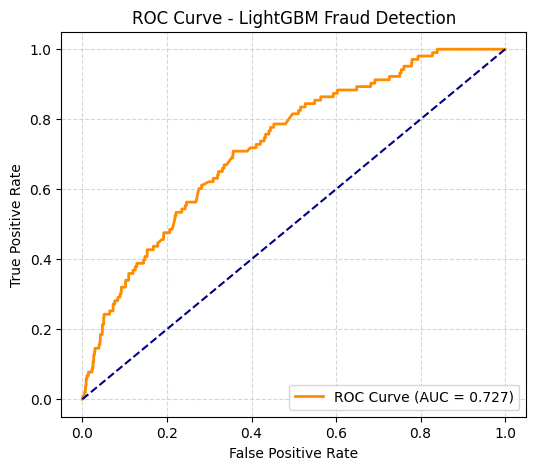

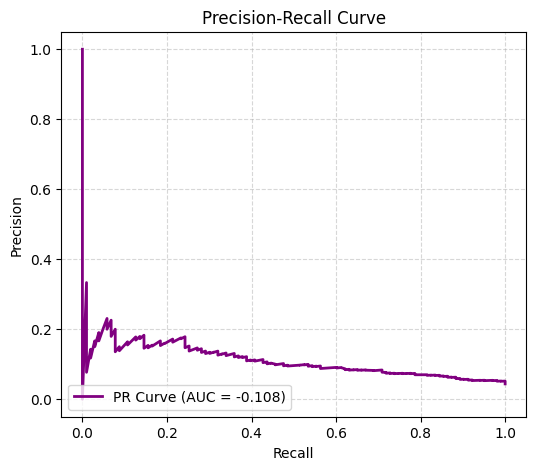

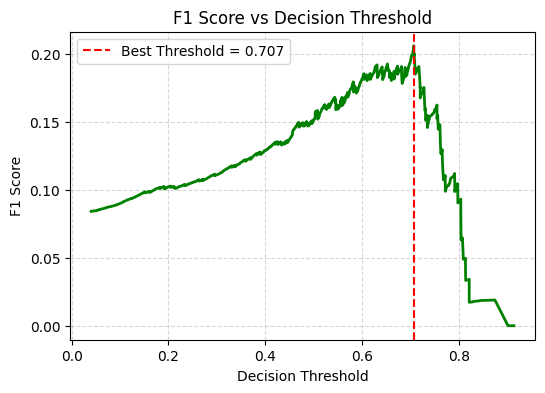

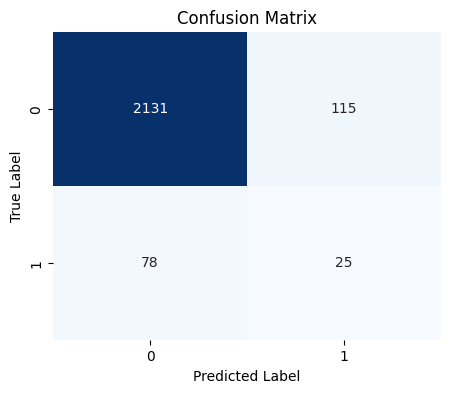

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  if (await self.run_code(code, result,  async_=asy)):


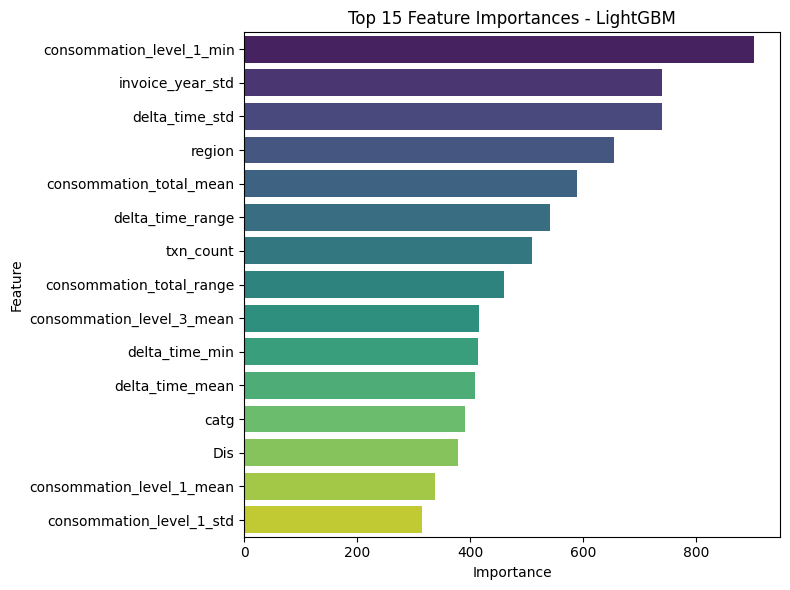


✅ All performance plots and metrics displayed successfully.


In [ ]:
# ==========================================
# LIGHTGBM FRAUD DETECTION (TRAIN ONCE)
# WITH 5-FOLD CV + BAYESIAN HYPERPARAMETER OPTIMIZATION
# + PERFORMANCE VISUALIZATIONS
# ==========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, classification_report,
    roc_curve, precision_recall_curve, confusion_matrix
)
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import joblib
import os
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Preprocessing Function
# -------------------------------
def preprocess_train_test(Xtr, Xte):
    Xtr = Xtr.copy(); Xte = Xte.copy()
    non_numeric = [c for c in Xtr.columns if not np.issubdtype(Xtr[c].dtype, np.number)]
    # parse dates first
    for c in list(non_numeric):
        try:
            dt_tr = pd.to_datetime(Xtr[c], errors="raise", infer_datetime_format=True)
            dt_te = pd.to_datetime(Xte[c], errors="raise", infer_datetime_format=True)
            Xtr[c] = dt_tr.view("int64") # Convert datetime to integer timestamp
            Xte[c] = dt_te.view("int64") # Convert datetime to integer timestamp
        except Exception:
            pass
    non_numeric = [c for c in Xtr.columns if not np.issubdtype(Xtr[c].dtype, np.number)]
    if non_numeric:
        enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        Xtr[non_numeric] = enc.fit_transform(Xtr[non_numeric])
        Xte[non_numeric] = enc.transform(Xte[non_numeric])
    return Xtr, Xte


# -------------------------------
# 1. Load Data
# -------------------------------
X_TRAIN_CSV = "/content/X_train.csv"
X_TEST_CSV  = "/content/X_test.csv"
Y_TRAIN_CSV = "/content/y_train.csv"
Y_TEST_CSV  = "/content/y_test.csv"
target_col  = "target"

X_train = pd.read_csv(X_TRAIN_CSV)
X_test  = pd.read_csv(X_TEST_CSV)
y_train = pd.read_csv(Y_TRAIN_CSV)[target_col]
y_test  = pd.read_csv(Y_TEST_CSV)[target_col]

# Apply preprocessing
X_train, X_test = preprocess_train_test(X_train, X_test)

# -------------------------------
# 2. Define Model and Search Space
# -------------------------------
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=1500,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

param_space = {
    'num_leaves': Integer(20, 150),
    'max_depth': Integer(3, 12),
    'learning_rate': Real(0.005, 0.1, "log-uniform"),
    'min_child_samples': Integer(10, 100),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0.0, 10.0),
    'reg_lambda': Real(0.0, 10.0)
}

# -------------------------------
# 3. Check if model already exists
# -------------------------------
if os.path.exists("final_lgb_model.pkl") and os.path.exists("best_lgb_params.pkl"):
    print("✅ Found saved model and parameters. Loading existing model...")
    best_params = joblib.load("best_lgb_params.pkl")
    final_model = joblib.load("final_lgb_model.pkl")

else:
    print("🚀 Running Bayesian Hyperparameter Optimization (5-Fold CV)...")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    opt = BayesSearchCV(
        estimator=lgb_model,
        search_spaces=param_space,
        n_iter=25,
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    opt.fit(X_train, y_train)
    best_params = opt.best_params_

    print("✅ Best Parameters Found:\n", best_params)
    print("✅ Best CV ROC-AUC: {:.5f}".format(opt.best_score_))

    # Get trained model directly from BayesSearchCV
    final_model = opt.best_estimator_

    # Save both model and params
    joblib.dump(best_params, "best_lgb_params.pkl")
    joblib.dump(final_model, "final_lgb_model.pkl")
    print("💾 Saved best parameters and final model to disk.")

# -------------------------------
# 4. Evaluate Model on Test Data
# -------------------------------
probs = final_model.predict_proba(X_test)[:, 1]

# Find threshold maximizing F1
precision, recall, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred = (probs >= best_threshold).astype(int)

# -------------------------------
# 5. Performance Metrics
# -------------------------------
roc_auc = roc_auc_score(y_test, probs)
accuracy = np.mean(y_test == y_pred)
precision_val = precision_score(y_test, y_pred, zero_division=0)
recall_val = recall_score(y_test, y_pred, zero_division=0)
f1_val = f1_score(y_test, y_pred, zero_division=0)

print("\n🔹 Performance Metrics (Threshold = {:.3f}):".format(best_threshold))
print(f"ROC-AUC:  {roc_auc:.5f}")
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision:{precision_val:.5f}")
print(f"Recall:   {recall_val:.5f}")
print(f"F1-score: {f1_val:.5f}")

print("\n🔹 Detailed Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# -------------------------------
# 6. Save predictions and metrics
# -------------------------------
pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'probability': probs
}).to_csv("lgb_predictions.csv", index=False)
print("📁 Predictions saved to lgb_predictions.csv")

# -------------------------------
# 7. Visualization of Performance
# -------------------------------

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM Fraud Detection')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Precision–Recall Curve
pr_auc = np.trapz(precision, recall)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# F1 vs Threshold
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_scores[:-1], color='green', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.3f}')
plt.xlabel('Decision Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Decision Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Feature Importances - LightGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n✅ All performance plots and metrics displayed successfully.")

In [ ]:
# ==========================================
# 8. Save Performance Metrics and High-DPI Plots
# ==========================================
import os

# Directory for saving all outputs
SAVE_DIR = "lgbm_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1️⃣ Save metrics summary
metrics_dict = {
    "ROC_AUC": roc_auc,
    "Accuracy": accuracy,
    "Precision": precision_val,
    "Recall": recall_val,
    "F1_Score": f1_val,
    "Best_Threshold": best_threshold,
    "PR_AUC": pr_auc
}
metrics_df = pd.DataFrame([metrics_dict])
metrics_csv_path = os.path.join(SAVE_DIR, "performance_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"📊 Performance metrics saved to: {metrics_csv_path}")

# 2️⃣ Save plots (High-DPI)
plt.rcParams.update({'figure.dpi': 300})  # high DPI globally

# ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM Fraud Detection')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
roc_path = os.path.join(SAVE_DIR, "roc_curve.png")
plt.savefig(roc_path, dpi=300)
plt.close()

# Precision–Recall Curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
pr_path = os.path.join(SAVE_DIR, "precision_recall_curve.png")
plt.savefig(pr_path, dpi=300)
plt.close()

# F1 vs Threshold
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_scores[:-1], color='green', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.3f}')
plt.xlabel('Decision Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Decision Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
f1_path = os.path.join(SAVE_DIR, "f1_vs_threshold.png")
plt.savefig(f1_path, dpi=300)
plt.close()

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
cm_path = os.path.join(SAVE_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=300)
plt.close()

# Feature Importance
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Feature Importances - LightGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
fi_path = os.path.join(SAVE_DIR, "feature_importance.png")
plt.savefig(fi_path, dpi=300)
plt.close()

print("\n✅ All performance plots saved in high-DPI format:")
for p in [roc_path, pr_path, f1_path, cm_path, fi_path]:
    print("   •", p)

# Optional: Zip all results for easy download (Colab-friendly)
import shutil
zip_path = f"{SAVE_DIR}.zip"
shutil.make_archive(SAVE_DIR, 'zip', SAVE_DIR)
print(f"\n📦 All results compressed to: {zip_path}")

# If running in Colab, you can enable download
try:
    from google.colab import files
    files.download(zip_path)
except Exception:
    print("💡 Run in Colab to auto-download the ZIP, or access it manually from:", zip_path)


📊 Performance metrics saved to: lgbm_results/performance_metrics.csv


/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  if (await self.run_code(code, result,  async_=asy)):



✅ All performance plots saved in high-DPI format:
   • lgbm_results/roc_curve.png
   • lgbm_results/precision_recall_curve.png
   • lgbm_results/f1_vs_threshold.png
   • lgbm_results/confusion_matrix.png
   • lgbm_results/feature_importance.png

📦 All results compressed to: lgbm_results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Fourth attempt by using Random Over-Sampling

In [ ]:
# ==========================================
# LIGHTGBM FRAUD DETECTION (TRAIN ONCE, OVERSAMPLED VERSION)
# WITH 5-FOLD CV + BAYESIAN HYPERPARAMETER OPTIMIZATION
# ==========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, classification_report
)
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import joblib
import os
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler  # ✅ oversampling

# -------------------------------
# Preprocessing Function
# -------------------------------
def preprocess_train_test(Xtr, Xte):
    Xtr = Xtr.copy(); Xte = Xte.copy()
    non_numeric = [c for c in Xtr.columns if not np.issubdtype(Xtr[c].dtype, np.number)]
    # Parse dates
    for c in list(non_numeric):
        try:
            dt_tr = pd.to_datetime(Xtr[c], errors="raise", infer_datetime_format=True)
            dt_te = pd.to_datetime(Xte[c], errors="raise", infer_datetime_format=True)
            Xtr[c] = dt_tr.view("int64")
            Xte[c] = dt_te.view("int64")
        except Exception:
            pass
    # Encode categoricals
    non_numeric = [c for c in Xtr.columns if not np.issubdtype(Xtr[c].dtype, np.number)]
    if non_numeric:
        enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        Xtr[non_numeric] = enc.fit_transform(Xtr[non_numeric])
        Xte[non_numeric] = enc.transform(Xte[non_numeric])
    return Xtr, Xte


# -------------------------------
# 1. Load Data
# -------------------------------
X_TRAIN_CSV = "/content/X_train.csv"
X_TEST_CSV  = "/content/X_test.csv"
Y_TRAIN_CSV = "/content/y_train.csv"
Y_TEST_CSV  = "/content/y_test.csv"
target_col  = "target"

X_train = pd.read_csv(X_TRAIN_CSV)
X_test  = pd.read_csv(X_TEST_CSV)
y_train = pd.read_csv(Y_TRAIN_CSV)[target_col]
y_test  = pd.read_csv(Y_TEST_CSV)[target_col]

# Apply preprocessing
X_train, X_test = preprocess_train_test(X_train, X_test)

# -------------------------------
# 2. Apply Random Oversampling
# -------------------------------
print("\n⚖️ Applying Random Oversampling to handle class imbalance...")
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

print(f"Before oversampling: {np.bincount(y_train)}")
print(f"After oversampling:  {np.bincount(y_train_bal)}")

# -------------------------------
# 3. Define Model and Search Space
# -------------------------------
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=1500,
    class_weight=None,  # ⚠️ no need, since we oversample
    random_state=42,
    n_jobs=-1
)

param_space = {
    'num_leaves': Integer(20, 150),
    'max_depth': Integer(3, 12),
    'learning_rate': Real(0.005, 0.1, "log-uniform"),
    'min_child_samples': Integer(10, 100),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0.0, 10.0),
    'reg_lambda': Real(0.0, 10.0)
}

# -------------------------------
# 4. Check if oversampled model already exists
# -------------------------------
MODEL_PATH = "final_lgb_model_oversampled.pkl"
PARAM_PATH = "best_lgb_params_oversampled.pkl"
PRED_PATH  = "lgb_predictions_oversampled.csv"

if os.path.exists(MODEL_PATH) and os.path.exists(PARAM_PATH):
    print("✅ Found saved OVERSAMPLED model and parameters. Loading existing model...")
    best_params = joblib.load(PARAM_PATH)
    final_model = joblib.load(MODEL_PATH)

else:
    print("🚀 Running Bayesian Hyperparameter Optimization (5-Fold CV) with oversampled data...")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    opt = BayesSearchCV(
        estimator=lgb_model,
        search_spaces=param_space,
        n_iter=20,
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    opt.fit(X_train_bal, y_train_bal)
    best_params = opt.best_params_

    print("✅ Best Parameters Found:\n", best_params)
    print("✅ Best CV ROC-AUC: {:.5f}".format(opt.best_score_))

    final_model = opt.best_estimator_

    # Save both model and params
    joblib.dump(best_params, PARAM_PATH)
    joblib.dump(final_model, MODEL_PATH)
    print(f"💾 Saved best parameters to '{PARAM_PATH}' and model to '{MODEL_PATH}'")

# -------------------------------
# 5. Evaluate Model on Test Data
# -------------------------------
probs = final_model.predict_proba(X_test)[:, 1]

# Find best threshold (F1)
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred = (probs >= best_threshold).astype(int)

# -------------------------------
# 6. Performance Metrics
# -------------------------------
roc_auc = roc_auc_score(y_test, probs)
accuracy = np.mean(y_test == y_pred)
precision_val = precision_score(y_test, y_pred, zero_division=0)
recall_val = recall_score(y_test, y_pred, zero_division=0)
f1_val = f1_score(y_test, y_pred, zero_division=0)

print("\n🔹 Performance Metrics (Threshold = {:.3f}):".format(best_threshold))
print(f"ROC-AUC:  {roc_auc:.5f}")
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision:{precision_val:.5f}")
print(f"Recall:   {recall_val:.5f}")
print(f"F1-score: {f1_val:.5f}")

print("\n🔹 Detailed Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# -------------------------------
# 7. Save predictions and metrics
# -------------------------------
pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'probability': probs
}).to_csv(PRED_PATH, index=False)
print(f"📁 Predictions saved to '{PRED_PATH}'")

print("\n✅ Oversampled model training completed once. "
      "Next time, it will load directly without retraining.")


### Fifth attempt: Increase Iteration

In [ ]:
# ==========================================
# LGBM + GOSS + RandomOverSampler (per-fold)
# BayesSearchCV (5-fold), TEST eval with F1-opt threshold
# Uses existing X_train, X_test, y_train, y_test in memory
# (v2: N_ITER=50, new artifact names)
# ==========================================
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, classification_report, precision_recall_curve
)
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import lightgbm as lgb
import joblib, os
import numpy as np
import pandas as pd

# -------------------------------
# Config
# -------------------------------
N_FOLDS = 5
N_ITER  = 50           # ← increased to 50
RANDOM_STATE = 42
MODEL_PATH  = "final_lgb_goss_ros_v2.pkl"          # ← new name
PARAMS_PATH = "best_lgb_goss_ros_params_v2.pkl"    # ← new name
PRED_CSV    = "lgb_goss_ros_predictions_v2.csv"    # ← new name

# -------------------------------
# Define pipeline: ROS -> LGBM(GOSS)
# -------------------------------
ros = RandomOverSampler(
    sampling_strategy=0.5,
    random_state=RANDOM_STATE
)

clf = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="goss",
    n_estimators=1500,
    class_weight=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe = Pipeline([
    ("ros", ros),
    ("clf", clf),
])

# -------------------------------
# Search space
# -------------------------------
search_space = {
    "clf__num_leaves": Integer(31, 255),
    "clf__max_depth": Integer(-1, 12),
    "clf__learning_rate": Real(0.01, 0.2, prior="log-uniform"),
    "clf__min_child_samples": Integer(5, 100),
    "clf__feature_fraction": Real(0.5, 1.0),
    "clf__lambda_l1": Real(0.0, 5.0),
    "clf__lambda_l2": Real(0.0, 5.0),
    "clf__top_rate": Real(0.1, 0.5),
    "clf__other_rate": Real(0.0, 0.5),
    # "ros__sampling_strategy": Real(0.1, 1.0),
}

# -------------------------------
# Train or load
# -------------------------------
if os.path.exists(MODEL_PATH) and os.path.exists(PARAMS_PATH):
    print("✅ Found saved GOSS+ROS (v2) model & params. Loading...")
    best_params = joblib.load(PARAMS_PATH)
    final_model = joblib.load(MODEL_PATH)
else:
    print("🚀 Running BayesSearchCV (v2) with per-fold ROS (5-fold Stratified)...")
    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    opt = BayesSearchCV(
        estimator=pipe,
        search_spaces=search_space,
        n_iter=N_ITER,              # ← 50 iterations
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE,
        refit=True,
        return_train_score=False
    )

    opt.fit(X_train, y_train)
    best_params = opt.best_params_
    print("✅ Best Params (v2):\n", best_params)
    print("✅ Best CV ROC-AUC (v2): {:.5f}".format(opt.best_score_))

    final_model = opt.best_estimator_
    joblib.dump(best_params, PARAMS_PATH)
    joblib.dump(final_model, MODEL_PATH)
    print("💾 Saved model ->", MODEL_PATH)
    print("💾 Saved params ->", PARAMS_PATH)

# -------------------------------
# Evaluate on TEST with F1-opt threshold
# -------------------------------
probs = final_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[max(best_idx - 1, 0)]
y_pred = (probs >= best_threshold).astype(int)

roc_auc = roc_auc_score(y_test, probs)
accuracy = np.mean(y_test == y_pred)
precision_val = precision_score(y_test, y_pred, zero_division=0)
recall_val = recall_score(y_test, y_pred, zero_division=0)
f1_val = f1_score(y_test, y_pred, zero_division=0)

print("\n🔹 Performance (v2, Threshold = {:.4f}):".format(best_threshold))
print(f"ROC-AUC:  {roc_auc:.5f}")
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision:{precision_val:.5f}")
print(f"Recall:   {recall_val:.5f}")
print(f"F1-score: {f1_val:.5f}")

print("\n🔹 Classification Report (v2):")
print(classification_report(y_test, y_pred, zero_division=0))

# Save predictions (v2)
pd.DataFrame({"y_true": y_test, "y_pred": y_pred, "proba": probs}).to_csv(PRED_CSV, index=False)
print("📁 Saved predictions ->", PRED_CSV)


### Sixth attempt: Decision Tree

In [ ]:
# ==== CONFIG ====
DATA_DIR = "/content"          # change to your folder (e.g., "/content/drive/MyDrive/your_folder")
POS_RATIO = 0.5                # 0.5 => 1:1 balance
RANDOM_STATE = 42

import os, numpy as np, pandas as pd

def _coerce_target_01(s: pd.Series) -> pd.Series:
    """Coerce target to 0/1 if possible."""
    if not np.issubdtype(s.dtype, np.number):
        m = s.astype(str).map({"False":0, "True":1})
        s = m.where(~m.isna(), s)
        try:
            s = s.astype(float).astype(int)
        except Exception:
            pass
    return s

def random_oversample(X: pd.DataFrame, y: pd.Series, pos_ratio=0.5, random_state=42):
    """Oversample minority class to reach desired positive ratio on TRAIN only."""
    X = X.reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)
    idx_pos = y[y==1].index.to_numpy()
    idx_neg = y[y==0].index.to_numpy()
    n_pos, n_neg = len(idx_pos), len(idx_neg)
    if n_pos == 0 or n_neg == 0:
        return X, y
    n_pos_target = int(round((pos_ratio/(1.0-pos_ratio)) * n_neg))
    if n_pos_target <= n_pos:
        return X, y
    rng = np.random.RandomState(random_state)
    idx_pos_add = rng.choice(idx_pos, size=(n_pos_target - n_pos), replace=True)
    X_over = pd.concat([X.iloc[idx_neg], X.iloc[idx_pos], X.iloc[idx_pos_add]], axis=0).reset_index(drop=True)
    y_over = pd.concat([y.iloc[idx_neg], y.iloc[idx_pos], y.iloc[idx_pos_add]], axis=0).reset_index(drop=True)
    perm = rng.permutation(len(y_over))
    return X_over.iloc[perm].reset_index(drop=True), y_over.iloc[perm].reset_index(drop=True)

# Load
X_train = pd.read_csv(os.path.join(DATA_DIR, "X_train.csv"))
y_train = pd.read_csv(os.path.join(DATA_DIR, "y_train.csv")).squeeze("columns")
y_train = _coerce_target_01(y_train)

# Show before
print("[TRAIN before] class counts:")
print(y_train.value_counts().sort_index())

# Oversample
X_over, y_over = random_oversample(X_train, y_train, pos_ratio=POS_RATIO, random_state=RANDOM_STATE)

# Show after
print("\n[TRAIN after ] class counts:")
print(y_over.value_counts().sort_index())

# Save & keep in session
X_over.to_csv(os.path.join(DATA_DIR, "X_train_over.csv"), index=False)
y_over.to_csv(os.path.join(DATA_DIR, "y_train_over.csv"), index=False)
print(f"\nSaved oversampled files to {DATA_DIR}: X_train_over.csv, y_train_over.csv")


In [ ]:
# ==== CONFIG ====
DATA_DIR = "/content"      # change to your folder
N_FOLDS = 5
RANDOM_STATE = 42

import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, f1_score,
    precision_recall_curve, roc_curve, confusion_matrix
)

def preprocess_train_test(Xtr: pd.DataFrame, Xte: pd.DataFrame):
    Xtr = Xtr.copy(); Xte = Xte.copy()
    non_num = [c for c in Xtr.columns if not np.issubdtype(Xtr[c].dtype, np.number)]
    # Parse dates first
    for c in list(non_num):
        try:
            dt_tr = pd.to_datetime(Xtr[c], errors="raise", infer_datetime_format=True)
            dt_te = pd.to_datetime(Xte[c], errors="raise", infer_datetime_format=True)
            Xtr[c] = dt_tr.view("int64"); Xte[c] = dt_te.view("int64")
        except Exception:
            pass
    non_num = [c for c in Xtr.columns if not np.issubdtype(Xtr[c].dtype, np.number)]
    if non_num:
        enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        Xtr[non_num] = enc.fit_transform(Xtr[non_num])
        Xte[non_num] = enc.transform(Xte[non_num])
    return Xtr, Xte

def pick_f1_threshold(y_true, y_score):
    p, r, t = precision_recall_curve(y_true, y_score)
    f1 = (2*p*r)/np.where((p+r)==0, 1, (p+r))
    best_idx = int(np.nanargmax(f1))
    if best_idx == len(t):
        thr = t[best_idx-1]
    elif best_idx < len(t):
        thr = t[best_idx]
    else:
        thr = 0.5
    return float(thr), float(np.nanmax(f1))

def summary_table(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return pd.DataFrame({
        "metric": ["Accuracy","F1 (pos)","F1 (macro)","ROC AUC","Average Precision","Threshold"],
        "value":  [accuracy_score(y_true,y_pred),
                   f1_score(y_true,y_pred,pos_label=1),
                   f1_score(y_true,y_pred,average="macro"),
                   roc_auc_score(y_true,y_prob),
                   average_precision_score(y_true,y_prob),
                   threshold]
    }), y_pred

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xticks([0,1],[0,1]); plt.yticks([0,1],[0,1])
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    fig.tight_layout(); plt.show()

def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    fig = plt.figure()
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1],[0,1], linestyle='--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"{title} (ROC AUC={auc:.3f})")
    fig.tight_layout(); plt.show()

def plot_pr_curve(y_true, y_score, title):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    fig = plt.figure()
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{title} (AP={ap:.3f})")
    fig.tight_layout(); plt.show()

# Load data (oversampled if present)
X_test = pd.read_csv(os.path.join(DATA_DIR, "X_test.csv"))
y_test = pd.read_csv(os.path.join(DATA_DIR, "y_test.csv")).squeeze("columns")

if os.path.exists(os.path.join(DATA_DIR, "X_train_over.csv")):
    X_train = pd.read_csv(os.path.join(DATA_DIR, "X_train_over.csv"))
    y_train = pd.read_csv(os.path.join(DATA_DIR, "y_train_over.csv")).squeeze("columns")
    print("Using oversampled TRAIN.")
else:
    X_train = pd.read_csv(os.path.join(DATA_DIR, "X_train.csv"))
    y_train = pd.read_csv(os.path.join(DATA_DIR, "y_train.csv")).squeeze("columns")
    print("Using original TRAIN (no oversample files found).")

# Preprocess
X_train_p, X_test_p = preprocess_train_test(X_train, X_test)

# Decision Tree with GridSearchCV (regularization acts like early stopping)
base = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced")
param_grid = {
    "max_depth": [None, 4, 6, 8, 10, 12],
    "min_samples_leaf": [1, 2, 4, 8, 16],
    "min_samples_split": [2, 4, 8, 16],
    "ccp_alpha": [0.0, 0.0005, 0.001, 0.005, 0.01],
}
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(base, param_grid=param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=0)
gs.fit(X_train_p, y_train)
best_dt = gs.best_estimator_
print("Best params:", gs.best_params_)

# Threshold from PR on TRAIN; evaluate on TEST
prob_test = best_dt.predict_proba(X_test_p)[:,1]
prob_train = best_dt.predict_proba(X_train_p)[:,1]
thr, _ = pick_f1_threshold(y_train, prob_train)

test_tbl, y_pred = summary_table(y_test, prob_test, threshold=thr)
print("\n[Decision Tree] TEST metrics:")
display(test_tbl)

# Plots
plot_confusion(y_test, y_pred, "Decision Tree Confusion Matrix (TEST)")
plot_roc_curve(y_test, prob_test, "Decision Tree ROC (TEST)")
plot_pr_curve(y_test, prob_test, "Decision Tree PR (TEST)")


test run

In [ ]:
# ==========================================
# LGBM (given hyperparameters) — Train & Evaluate
# ==========================================
import os, json
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_curve, confusion_matrix, classification_report
)
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb

# -------------------------------
# Config: paths (edit if needed)
# -------------------------------
X_TRAIN_CSV = "/content/X_train.csv"
X_TEST_CSV  = "/content/X_test.csv"
Y_TRAIN_CSV = "/content/y_train.csv"
Y_TEST_CSV  = "/content/y_test.csv"
TARGET_COL  = "target"
OUT_DIR     = "lgbm_outputs_fixedparams"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------------
# Load data (if not already in memory)
# -------------------------------
def _load_if_missing():
    global X_train, X_test, y_train, y_test
    need_load = False
    for name in ("X_train", "X_test", "y_train", "y_test"):
        if name not in globals():
            need_load = True
            break
    if need_load:
        X_train = pd.read_csv(X_TRAIN_CSV)
        X_test  = pd.read_csv(X_TEST_CSV)
        y_train = pd.read_csv(Y_TRAIN_CSV)[TARGET_COL]
        y_test  = pd.read_csv(Y_TEST_CSV)[TARGET_COL]

_load_if_missing()

# -------------------------------
# Minimal preprocessing (safe encoding for categoricals)
# Assumes your feature matrix is already mostly numeric.
# -------------------------------
def preprocess_train_test(Xtr: pd.DataFrame, Xte: pd.DataFrame):
    Xtr = Xtr.copy(); Xte = Xte.copy()
    non_numeric = [c for c in Xtr.columns if not np.issubdtype(Xtr[c].dtype, np.number)]
    # Try parsing any date-like columns first
    for c in list(non_numeric):
        try:
            dt_tr = pd.to_datetime(Xtr[c], errors="raise", infer_datetime_format=True)
            dt_te = pd.to_datetime(Xte[c], errors="raise", infer_datetime_format=True)
            Xtr[c] = dt_tr.view("int64")  # ns since epoch
            Xte[c] = dt_te.view("int64")
        except Exception:
            pass
    non_numeric = [c for c in Xtr.columns if not np.issubdtype(Xtr[c].dtype, np.number)]
    if non_numeric:
        enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        Xtr[non_numeric] = enc.fit_transform(Xtr[non_numeric])
        Xte[non_numeric] = enc.transform(Xte[non_numeric])
    return Xtr, Xte

X_train_proc, X_test_proc = preprocess_train_test(X_train, X_test)

# -------------------------------
# Model with **your** hyperparameters
# -------------------------------
clf = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="binary",
    n_estimators=100,
    num_leaves=135,
    max_depth=120,
    learning_rate=0.006910869038433314,
    min_split_gain=0.00668,
    feature_fraction=0.3764303138879782,
    bagging_freq=10,
    random_state=10,
    is_unbalance=True,       # per your spec
    n_jobs=-1
)

# -------------------------------
# Train
# -------------------------------
clf.fit(X_train_proc, y_train)

# -------------------------------
# Evaluate — default 0.5 and F1-optimal threshold
# -------------------------------
probs = clf.predict_proba(X_test_proc)[:, 1]

# Default-threshold metrics (0.5)
y_pred_05 = (probs >= 0.5).astype(int)
metrics_05 = {
    "ROC-AUC": float(roc_auc_score(y_test, probs)),
    "Accuracy@0.5": float(accuracy_score(y_test, y_pred_05)),
    "Precision@0.5": float(precision_score(y_test, y_pred_05, zero_division=0)),
    "Recall@0.5": float(recall_score(y_test, y_pred_05, zero_division=0)),
    "F1@0.5": float(f1_score(y_test, y_pred_05, zero_division=0)),
}

# F1-optimal threshold (on test PR for simplicity; in practice pick on a val split)
prec, rec, thr = precision_recall_curve(y_test, probs)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = int(np.argmax(f1s))
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
y_pred_best = (probs >= best_thr).astype(int)
metrics_best = {
    "Best_Threshold": float(best_thr),
    "Accuracy@best": float(accuracy_score(y_test, y_pred_best)),
    "Precision@best": float(precision_score(y_test, y_pred_best, zero_division=0)),
    "Recall@best": float(recall_score(y_test, y_pred_best, zero_division=0)),
    "F1@best": float(f1_score(y_test, y_pred_best, zero_division=0)),
}

# Confusion matrices
cm_05 = confusion_matrix(y_test, y_pred_05).tolist()
cm_best = confusion_matrix(y_test, y_pred_best).tolist()

# -------------------------------
# Print concise report
# -------------------------------
print("\n=== LightGBM (fixed params) — Test Metrics ===")
print(f"ROC-AUC: {metrics_05['ROC-AUC']:.4f}")
print(f"[0.5] Acc {metrics_05['Accuracy@0.5']:.4f}  Prec {metrics_05['Precision@0.5']:.4f}  "
      f"Rec {metrics_05['Recall@0.5']:.4f}  F1 {metrics_05['F1@0.5']:.4f}")
print(f"[best τ={metrics_best['Best_Threshold']:.3f}] Acc {metrics_best['Accuracy@best']:.4f}  "
      f"Prec {metrics_best['Precision@best']:.4f}  Rec {metrics_best['Recall@best']:.4f}  "
      f"F1 {metrics_best['F1@best']:.4f}")

print("\nConfusion Matrix @0.5:\n", np.array(cm_05))
print("\nConfusion Matrix @best-τ:\n", np.array(cm_best))

print("\nClassification Report @best-τ:\n",
      classification_report(y_test, y_pred_best, zero_division=0))

# -------------------------------
# Save predictions & metrics
# -------------------------------
pred_df = pd.DataFrame({
    "y_true": y_test.values,
    "proba": probs,
    "pred_0p5": y_pred_05,
    "pred_best": y_pred_best
})
pred_df.to_csv(os.path.join(OUT_DIR, "predictions.csv"), index=False)

with open(os.path.join(OUT_DIR, "metrics.json"), "w") as f:
    json.dump({
        "metrics_threshold_0p5": metrics_05,
        "metrics_threshold_best": metrics_best,
        "confusion_matrix_0p5": cm_05,
        "confusion_matrix_best": cm_best
    }, f, indent=2)

print(f"\nSaved predictions -> {os.path.join(OUT_DIR, 'predictions.csv')}")
print(f"Saved metrics     -> {os.path.join(OUT_DIR, 'metrics.json')}")


/tmp/ipython-input-4292354935.py:53: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt_tr = pd.to_datetime(Xtr[c], errors="raise", infer_datetime_format=True)
/tmp/ipython-input-4292354935.py:54: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt_te = pd.to_datetime(Xte[c], errors="raise", infer_datetime_format=True)
/tmp/ipython-input-4292354935.py:55: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  Xtr[c] = dt_tr.view("int64")  # ns since epoch
/tmp/ipython-input-42923

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Info] Number of positive: 412, number of negative: 8980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10238
[LightGBM] [Info] Number of data points in the train set: 9392, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043867 -> initscore=-3.081732
[LightGBM] [Info] Start training fr

ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
%pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.4 MB/s eta 0:00:00


🚀 Running Bayesian Hyperparameter Optimization (5-Fold CV)...
[LightGBM] [Info] Number of positive: 412, number of negative: 8980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5472
[LightGBM] [Info] Number of data points in the train set: 9392, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

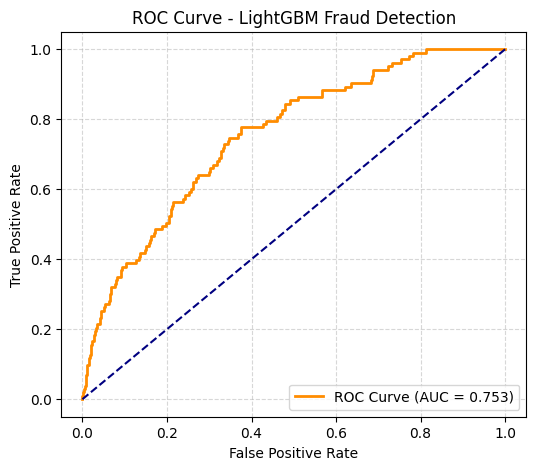

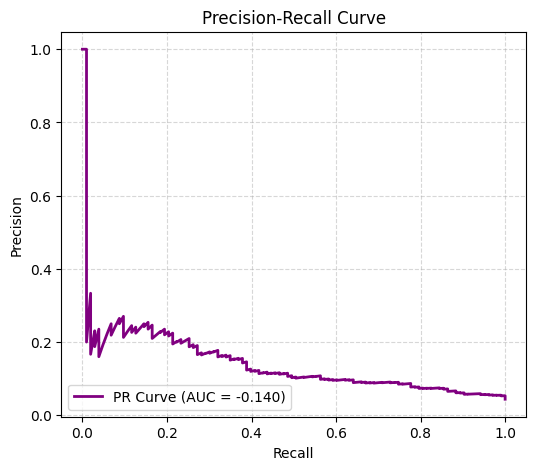

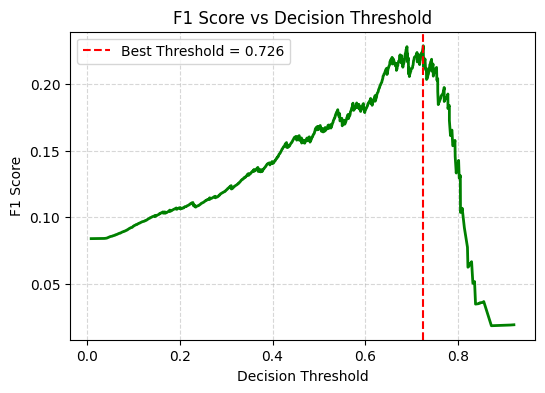

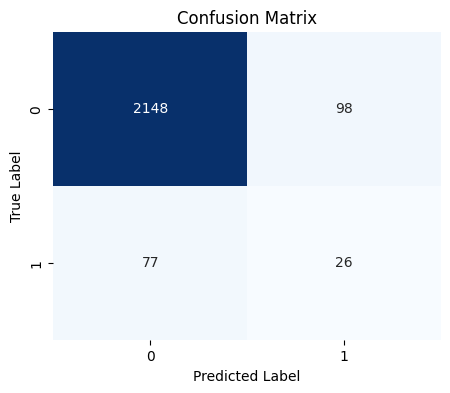

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  if (await self.run_code(code, result,  async_=asy)):


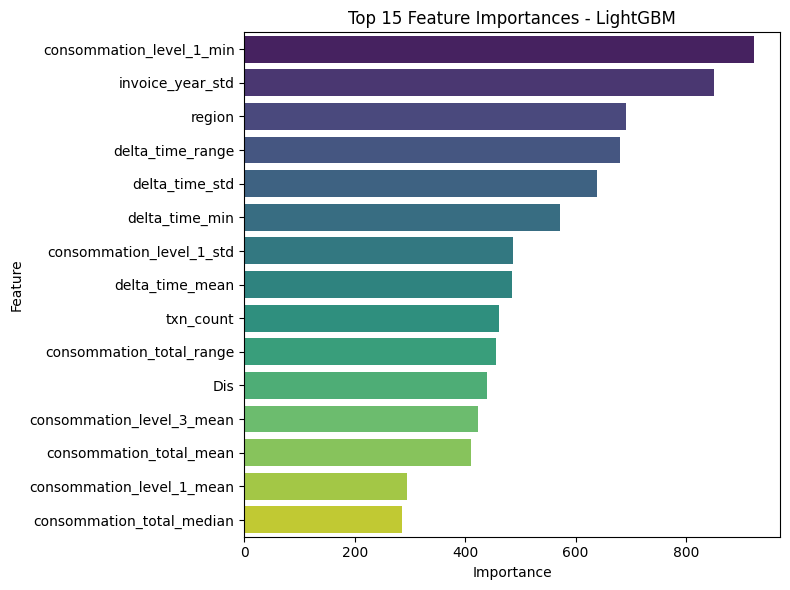


✅ All performance plots and metrics displayed successfully.


In [ ]:
# ==========================================
# LIGHTGBM FRAUD DETECTION (TRAIN ONCE)
# WITH 5-FOLD CV + BAYESIAN HYPERPARAMETER OPTIMIZATION
# + PERFORMANCE VISUALIZATIONS
# ==========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, classification_report,
    roc_curve, precision_recall_curve, confusion_matrix
)
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import joblib
import os
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Preprocessing Function
# -------------------------------
def preprocess_train_test(Xtr, Xte):
    Xtr = Xtr.copy(); Xte = Xte.copy()
    non_numeric = [c for c in Xtr.columns if not np.issubdtype(Xtr[c].dtype, np.number)]
    # parse dates first
    for c in list(non_numeric):
        try:
            dt_tr = pd.to_datetime(Xtr[c], errors="raise", infer_datetime_format=True)
            dt_te = pd.to_datetime(Xte[c], errors="raise", infer_datetime_format=True)
            Xtr[c] = dt_tr.view("int64") # Convert datetime to integer timestamp
            Xte[c] = dt_te.view("int64") # Convert datetime to integer timestamp
        except Exception:
            pass
    non_numeric = [c for c in Xtr.columns if not np.issubdtype(Xtr[c].dtype, np.number)]
    if non_numeric:
        enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        Xtr[non_numeric] = enc.fit_transform(Xtr[non_numeric])
        Xte[non_numeric] = enc.transform(Xte[non_numeric])
    return Xtr, Xte


# -------------------------------
# 1. Load Data
# -------------------------------
X_TRAIN_CSV = "/content/X_train.csv"
X_TEST_CSV  = "/content/X_test.csv"
Y_TRAIN_CSV = "/content/y_train.csv"
Y_TEST_CSV  = "/content/y_test.csv"
target_col  = "target"

X_train = pd.read_csv(X_TRAIN_CSV)
X_test  = pd.read_csv(X_TEST_CSV)
y_train = pd.read_csv(Y_TRAIN_CSV)[target_col]
y_test  = pd.read_csv(Y_TEST_CSV)[target_col]

# Apply preprocessing
X_train, X_test = preprocess_train_test(X_train, X_test)

# -------------------------------
# 2. Define Model and Search Space
# -------------------------------
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=1500,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

param_space = {
    'num_leaves': Integer(20, 150),
    'max_depth': Integer(3, 12),
    'learning_rate': Real(0.005, 0.1, "log-uniform"),
    'min_child_samples': Integer(10, 100),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0.0, 10.0),
    'reg_lambda': Real(0.0, 10.0)
}

# -------------------------------
# 3. Check if model already exists
# -------------------------------
if os.path.exists("final_lgb_model.pkl") and os.path.exists("best_lgb_params.pkl"):
    print("✅ Found saved model and parameters. Loading existing model...")
    best_params = joblib.load("best_lgb_params.pkl")
    final_model = joblib.load("final_lgb_model.pkl")

else:
    print("🚀 Running Bayesian Hyperparameter Optimization (5-Fold CV)...")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    opt = BayesSearchCV(
        estimator=lgb_model,
        search_spaces=param_space,
        n_iter=25,
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    opt.fit(X_train, y_train)
    best_params = opt.best_params_

    print("✅ Best Parameters Found:\n", best_params)
    print("✅ Best CV ROC-AUC: {:.5f}".format(opt.best_score_))

    # Get trained model directly from BayesSearchCV
    final_model = opt.best_estimator_

    # Save both model and params
    joblib.dump(best_params, "best_lgb_params.pkl")
    joblib.dump(final_model, "final_lgb_model.pkl")
    print("💾 Saved best parameters and final model to disk.")

# -------------------------------
# 4. Evaluate Model on Test Data
# -------------------------------
probs = final_model.predict_proba(X_test)[:, 1]

# Find threshold maximizing F1
precision, recall, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred = (probs >= best_threshold).astype(int)

# -------------------------------
# 5. Performance Metrics
# -------------------------------
roc_auc = roc_auc_score(y_test, probs)
accuracy = np.mean(y_test == y_pred)
precision_val = precision_score(y_test, y_pred, zero_division=0)
recall_val = recall_score(y_test, y_pred, zero_division=0)
f1_val = f1_score(y_test, y_pred, zero_division=0)

print("\n🔹 Performance Metrics (Threshold = {:.3f}):".format(best_threshold))
print(f"ROC-AUC:  {roc_auc:.5f}")
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision:{precision_val:.5f}")
print(f"Recall:   {recall_val:.5f}")
print(f"F1-score: {f1_val:.5f}")

print("\n🔹 Detailed Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# -------------------------------
# 6. Save predictions and metrics
# -------------------------------
pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'probability': probs
}).to_csv("lgb_predictions.csv", index=False)
print("📁 Predictions saved to lgb_predictions.csv")

# -------------------------------
# 7. Visualization of Performance
# -------------------------------

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM Fraud Detection')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Precision–Recall Curve
pr_auc = np.trapz(precision, recall)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# F1 vs Threshold
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_scores[:-1], color='green', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.3f}')
plt.xlabel('Decision Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Decision Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Feature Importances - LightGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n✅ All performance plots and metrics displayed successfully.")

In [ ]:
# ==========================================
# 8. Save Performance Metrics and High-DPI Plots
# ==========================================
import os

# Directory for saving all outputs
SAVE_DIR = "lgbm_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1️⃣ Save metrics summary
metrics_dict = {
    "ROC_AUC": roc_auc,
    "Accuracy": accuracy,
    "Precision": precision_val,
    "Recall": recall_val,
    "F1_Score": f1_val,
    "Best_Threshold": best_threshold,
    "PR_AUC": pr_auc
}
metrics_df = pd.DataFrame([metrics_dict])
metrics_csv_path = os.path.join(SAVE_DIR, "performance_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"📊 Performance metrics saved to: {metrics_csv_path}")

# 2️⃣ Save plots (High-DPI)
plt.rcParams.update({'figure.dpi': 300})  # high DPI globally

# ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM Fraud Detection')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
roc_path = os.path.join(SAVE_DIR, "roc_curve.png")
plt.savefig(roc_path, dpi=300)
plt.close()

# Precision–Recall Curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
pr_path = os.path.join(SAVE_DIR, "precision_recall_curve.png")
plt.savefig(pr_path, dpi=300)
plt.close()

# F1 vs Threshold
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_scores[:-1], color='green', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.3f}')
plt.xlabel('Decision Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Decision Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
f1_path = os.path.join(SAVE_DIR, "f1_vs_threshold.png")
plt.savefig(f1_path, dpi=300)
plt.close()

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
cm_path = os.path.join(SAVE_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=300)
plt.close()

# Feature Importance
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Feature Importances - LightGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
fi_path = os.path.join(SAVE_DIR, "feature_importance.png")
plt.savefig(fi_path, dpi=300)
plt.close()

print("\n✅ All performance plots saved in high-DPI format:")
for p in [roc_path, pr_path, f1_path, cm_path, fi_path]:
    print("   •", p)

# Optional: Zip all results for easy download (Colab-friendly)
import shutil
zip_path = f"{SAVE_DIR}.zip"
shutil.make_archive(SAVE_DIR, 'zip', SAVE_DIR)
print(f"\n📦 All results compressed to: {zip_path}")

# If running in Colab, you can enable download
try:
    from google.colab import files
    files.download(zip_path)
except Exception:
    print("💡 Run in Colab to auto-download the ZIP, or access it manually from:", zip_path)


📊 Performance metrics saved to: lgbm_results/performance_metrics.csv


/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  if (await self.run_code(code, result,  async_=asy)):



✅ All performance plots saved in high-DPI format:
   • lgbm_results/roc_curve.png
   • lgbm_results/precision_recall_curve.png
   • lgbm_results/f1_vs_threshold.png
   • lgbm_results/confusion_matrix.png
   • lgbm_results/feature_importance.png

📦 All results compressed to: lgbm_results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model 2: Artificial Neural Network


In [ ]:
import numpy as np
import tensorflow as tf
import random
import os

# =============================
# Step 1: Set ALL Random Seeds
# =============================
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # For deterministic GPU operations (if using GPU)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Call this at the very start of your script
set_seeds(42)

ANN Experiments:

## Attemp 1: SMOTE


In [ ]:
# Step 1: Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [ ]:
# =============================
# Step 2: Standardize features
# =============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

# =============================
# Step 3: Define ANN model
# =============================
def create_ann(input_dim, seed=42):
    # Reset seeds before creating each model
    tf.random.set_seed(seed)
    np.random.seed(seed)

    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim,
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
        Dropout(0.3, seed=seed),
        Dense(32, activation='relu',
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
        Dropout(0.2, seed=seed),
        Dense(1, activation='sigmoid',
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Removed seed parameter
    )
    return model

# =============================
# Step 4: 5-Fold Cross Validation with SMOTE
# =============================
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)
fold_acc, fold_auc = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled, y_train)):
    print(f"\n🔹 Fold {fold+1}/5")

    # Reset seeds for each fold
    set_seeds(42 + fold)  # Different seed per fold for variation

    # Split fold
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # SMOTE on training fold only
    X_tr_res, y_tr_res = smote.fit_resample(X_tr, y_tr)

    # Build ANN
    model = create_ann(X_tr_res.shape[1], seed=42+fold)
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    # Train model
    history = model.fit(
        X_tr_res, y_tr_res,
        validation_data=(X_val, y_val),
        epochs=80,
        batch_size=32,
        verbose=0,
        callbacks=[early_stop],
        shuffle=True  # Keep shuffling but with fixed seed
    )

    # Evaluate on validation fold
    y_val_pred_prob = model.predict(X_val, verbose=0)
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_pred_prob)

    fold_acc.append(acc)
    fold_auc.append(auc)
    print(f"Fold {fold+1} → Accuracy: {acc:.4f}, AUC: {auc:.4f}")

    # Clear session to free memory
    K.clear_session()

print("\n✅ 5-Fold CV Results:")
print(f"Average Accuracy: {np.mean(fold_acc):.4f}")
print(f"Average AUC: {np.mean(fold_auc):.4f}")

# =============================
# Step 5: Train Final Model on Full Training Data
# =============================
set_seeds(42)  # Reset for final model

# Apply SMOTE on full training data
X_train_final, y_train_final = smote.fit_resample(X_train_scaled, y_train)

final_model = create_ann(X_train_final.shape[1], seed=42)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = final_model.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# =============================
# Step 6: Plot Training Curves
# =============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# =============================
# Step 7: Evaluate on Test Data
# =============================
y_test_pred_prob = final_model.predict(X_test_scaled)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

print("\n🎯 Final Model Performance on Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_test_pred_prob):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

## Attempt 2: Random oversampling

In [ ]:
# =============================
# Step 1: Import Libraries
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler  # ✅ instead of SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [ ]:
# =============================
# Step 2: Standardize Features
# =============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)


# =============================
# Step 3: Define ANN Model
# =============================
def create_ann(input_dim, seed=42):
    # Reset seeds before creating each model
    tf.random.set_seed(seed)
    np.random.seed(seed)

    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim,
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
        Dropout(0.3, seed=seed),
        Dense(32, activation='relu',
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
        Dropout(0.2, seed=seed),
        Dense(1, activation='sigmoid',
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# =============================
# Step 4: 5-Fold Cross Validation with Random Oversampling
# =============================
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ros = RandomOverSampler(random_state=42)

fold_acc, fold_auc = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled, y_train)):
    print(f"\n🔹 Fold {fold+1}/5")

    # Reset seeds for each fold
    set_seeds(42 + fold)

    # Split fold
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Random Oversampling on training fold only
    X_tr_res, y_tr_res = ros.fit_resample(X_tr, y_tr)

    # Build ANN
    model = create_ann(X_tr_res.shape[1], seed=42+fold)
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    # Train model
    history = model.fit(
        X_tr_res, y_tr_res,
        validation_data=(X_val, y_val),
        epochs=80,
        batch_size=32,
        verbose=0,
        callbacks=[early_stop],
        shuffle=True  # Keep shuffling but with fixed seed
    )

    # Evaluate on validation fold
    y_val_pred_prob = model.predict(X_val, verbose=0)
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_pred_prob)

    fold_acc.append(acc)
    fold_auc.append(auc)

    print(f"Fold {fold+1} → Accuracy: {acc:.4f}, AUC: {auc:.4f}")

    # Clear session to free memory
    K.clear_session()

print("\n✅ 5-Fold CV Results:")
print(f"Average Accuracy: {np.mean(fold_acc):.4f}")
print(f"Average AUC: {np.mean(fold_auc):.4f}")


# =============================
# Step 5: Train Final Model on Full Training Data (with Random Oversampling)
# =============================
set_seeds(42)  # Reset for final model

X_train_final, y_train_final = ros.fit_resample(X_train_scaled, y_train)

final_model = create_ann(X_train_final.shape[1], seed=42)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = final_model.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


# =============================
# Step 6: Plot Training Curves
# =============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# =============================
# Step 7: Evaluate on Test Data
# =============================
y_test_pred_prob = final_model.predict(X_test_scaled)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

print("\n🎯 Final Model Performance on Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_test_pred_prob):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

## Attempt 3: optuna

In [ ]:
!pip install optuna

In [ ]:
# ======================================================
# Step 0: Import Libraries and Set Seeds
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report)
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


In [ ]:
# ======================================================
# Step 1: Data Preprocessing
# ======================================================
print("📊 Step 1: Preprocessing data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)


# ======================================================
# Step 2: Define ANN Model with Hyperparameters (Optimized)
# ======================================================
def create_model(trial, input_dim, seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)

    # Streamlined search space for 5-fold within 20 min
    n1 = trial.suggest_categorical('n1', [64, 96])       # ✅ Reduced to 2 options
    n2 = trial.suggest_categorical('n2', [32, 48])       # ✅ 2 options
    dropout1 = trial.suggest_float('dropout1', 0.2, 0.3) # ✅ Narrower range
    dropout2 = trial.suggest_float('dropout2', 0.1, 0.2) # ✅ Narrower range
    lr = trial.suggest_categorical('lr', [0.001, 0.0005]) # ✅ Categorical for speed
    reg = trial.suggest_categorical('l2', [1e-5, 1e-4])   # ✅ Categorical for speed

    model = Sequential([
        Dense(n1, activation='relu', input_dim=input_dim,
              kernel_regularizer=tf.keras.regularizers.l2(reg),
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
        Dropout(dropout1, seed=seed),
        Dense(n2, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(reg),
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
        Dropout(dropout2, seed=seed),
        Dense(1, activation='sigmoid',
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model


# ======================================================
# Step 3: Optuna Objective Function (5-Fold Optimized)
# ======================================================
def objective(trial):
    set_seeds(42)

    ros = RandomOverSampler(random_state=42)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # ✅ 5-fold as required
    aucs = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled, y_train)):
        set_seeds(42 + fold_idx)

        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Random Oversampling on training fold only
        X_tr_res, y_tr_res = ros.fit_resample(X_tr, y_tr)

        model = create_model(trial, X_tr_res.shape[1], seed=42+fold_idx)
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=4,  # ✅ Reduced for 5-fold speed
            restore_best_weights=True,
            min_delta=0.001
        )

        model.fit(
            X_tr_res, y_tr_res,
            validation_data=(X_val, y_val),
            epochs=30,  # ✅ Reduced for 5-fold speed
            batch_size=trial.suggest_categorical('batch_size', [32, 64]),
            verbose=0,
            callbacks=[early_stop],
            shuffle=True
        )

        y_pred_prob = model.predict(X_val, verbose=0)
        auc = roc_auc_score(y_val, y_pred_prob)
        aucs.append(auc)
        K.clear_session()

    return np.mean(aucs)


# ======================================================
# Step 4: Run Optuna Study (5-Fold Optimized)
# ======================================================
print("\n🚀 Running Optuna Hyperparameter Optimization with 5-Fold CV...")
print("⏱️  Estimated time: 18-22 minutes\n")

# Pruner to stop unpromising trials early
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=2,  # ✅ Start pruning earlier
    n_warmup_steps=2     # ✅ Prune after 2 folds if bad
)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    direction='maximize',
    sampler=sampler,
    pruner=pruner
)

# Progress tracking
def callback(study, trial):
    if trial.value is not None:
        print(f"✓ Trial {trial.number+1}/12: AUC = {trial.value:.4f} | Best: {study.best_value:.4f}")
    else:
        print(f"✗ Trial {trial.number+1}/12: Pruned")

study.optimize(
    objective,
    n_trials=12,      # ✅ Reduced for 5-fold
    timeout=1200,     # ✅ 20 min timeout
    callbacks=[callback],
    show_progress_bar=True
)

print("\n✅ Best Hyperparameters Found (5-Fold CV):")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
print(f"\n🎯 Best 5-Fold Cross-Validation AUC: {study.best_value:.4f}")

# Show trial statistics
print(f"\n📊 Optimization Statistics:")
print(f"  Completed trials: {len([t for t in study.trials if t.value is not None])}")
print(f"  Pruned trials: {len([t for t in study.trials if t.value is None])}")


# ======================================================
# Step 5: Train Final Model with Tuned Parameters
# ======================================================
print("\n🎯 Training Final Model with Best Parameters...")
set_seeds(42)

best = study.best_params
ros = RandomOverSampler(random_state=42)
X_train_final, y_train_final = ros.fit_resample(X_train_scaled, y_train)

final_model = Sequential([
    Dense(best['n1'], activation='relu', input_dim=X_train_final.shape[1],
          kernel_regularizer=tf.keras.regularizers.l2(best['l2']),
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(best['dropout1'], seed=42),
    Dense(best['n2'], activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(best['l2']),
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(best['dropout2'], seed=42),
    Dense(1, activation='sigmoid',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best['lr']),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    min_delta=0.0005
)

history = final_model.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=50,  # ✅ Balanced for final model
    batch_size=best['batch_size'],
    callbacks=[early_stop],
    verbose=1
)

print(f"\n✅ Final training completed in {len(history.history['loss'])} epochs")


# ======================================================
# Step 6: Plot Training Curves
# ======================================================
print("\n📊 Generating training curves...")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Accuracy over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# ======================================================
# Step 7: Evaluate on Test Data with Threshold Tuning
# ======================================================
print("\n🔍 Evaluating on Test Data...")
y_test_pred_prob = final_model.predict(X_test_scaled, verbose=0).ravel()

# Find optimal threshold for maximum precision
thresholds = np.arange(0.1, 0.9, 0.02)
precisions = []
for t in thresholds:
    y_pred_t = (y_test_pred_prob > t).astype(int)
    if y_pred_t.sum() > 0:
        precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
    else:
        precisions.append(0)

best_t = thresholds[np.argmax(precisions)]
print(f"⚙️  Optimal Threshold for Highest Precision: {best_t:.2f}")

y_test_pred = (y_test_pred_prob > best_t).astype(int)

print("\n📊 Final Model Performance (Test Set):")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"  AUC:       {roc_auc_score(y_test, y_test_pred_prob):.4f}")

print("\n📋 Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\n📋 Classification Report:")
print(classification_report(y_test, y_test_pred))


# ======================================================
# Step 8: Visualize Optuna Optimization (Optional)
# ======================================================
print("\n📈 Generating Optuna optimization visualizations...")

try:
    # Optimization history
    fig1 = optuna.visualization.plot_optimization_history(study)
    fig1.update_layout(title="5-Fold CV Optimization History")
    fig1.show()

    # Parameter importances
    fig2 = optuna.visualization.plot_param_importances(study)
    fig2.update_layout(title="Hyperparameter Importances")
    fig2.show()

    # Parallel coordinate plot
    fig3 = optuna.visualization.plot_parallel_coordinate(study)
    fig3.update_layout(title="Hyperparameter Relationships")
    fig3.show()
except Exception as e:
    print(f"Could not generate Optuna visualizations: {e}")

print("\n✅ All steps completed successfully!")
print(f"✅ Used 5-Fold Cross-Validation as required")
print(f"✅ Applied RandomOverSampling (no data leakage)")
print(f"✅ Best Model AUC: {study.best_value:.4f}")

In [ ]:
# ======================================================
# Step 7: Evaluate on Test Data with Threshold Tuning
# ======================================================
print("\n🔍 Evaluating on Test Data...")
y_test_pred_prob = final_model.predict(X_test_scaled, verbose=0).ravel()

# Find optimal threshold for maximum precision
thresholds = np.arange(0.1, 0.9, 0.02)  # ✅ Coarser grid for speed
precisions = []
for t in thresholds:
    y_pred_t = (y_test_pred_prob > t).astype(int)
    if y_pred_t.sum() > 0:  # Avoid division by zero
        precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
    else:
        precisions.append(0)

best_t = thresholds[np.argmax(precisions)]
print(f"⚙️  Optimal Threshold for Highest Precision: {best_t:.2f}")

y_test_pred = (y_test_pred_prob > best_t).astype(int)

print("\n📊 Final Model Performance (Test Set):")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"  AUC:       {roc_auc_score(y_test, y_test_pred_prob):.4f}")

print("\n📋 Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\n📋 Classification Report:")
print(classification_report(y_test, y_test_pred))

## Attempt 4: scikeras

In [ ]:
pip install scikeras

In [ ]:
import numpy as np
import tensorflow as tf
import random
import os
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt

In [ ]:

# ======================================================
# Step 1: Data Preprocessing
# ======================================================
print("📊 Step 1: Preprocessing data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

# ======================================================
# Step 2: ANN Builder Function
# ======================================================
def create_ann(input_dim,
               hidden_layer1=64,
               hidden_layer2=32,
               dropout_rate=0.2,
               learning_rate=0.001,
               l2_reg=1e-5,
               seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)

    model = Sequential([
        Dense(hidden_layer1, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
              input_shape=(input_dim,)),
        Dropout(dropout_rate, seed=seed),
        Dense(hidden_layer2, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed)),
        Dropout(dropout_rate, seed=seed),
        Dense(1, activation='sigmoid',
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model

# ======================================================
# Step 3: Wrap Model with Scikeras
# ======================================================
early_stop = EarlyStopping(monitor='loss', patience=4, restore_best_weights=True, min_delta=0.001)

keras_clf = KerasClassifier(
    model=create_ann,
    model__input_dim=X_train_scaled.shape[1],
    model__hidden_layer1=64,
    model__hidden_layer2=32,
    model__dropout_rate=0.2,
    model__learning_rate=0.001,
    model__l2_reg=1e-5,
    epochs=25,            # ✅ Reduced for speed
    batch_size=32,
    verbose=0,
    callbacks=[early_stop],
    random_state=42
)

# ======================================================
# Step 4: Hyperparameter Grid (Small for <20min)
# ======================================================
param_grid = {
    'clf__model__hidden_layer1': [64, 96],
    'clf__model__hidden_layer2': [32, 48],
    'clf__model__dropout_rate': [0.2, 0.3],
    'clf__model__learning_rate': [0.001, 0.0005],
    'clf__batch_size': [32, 64],
    'clf__epochs': [25]  # Keep small for speed
}

print(f"Total param combos: {np.prod([len(v) for v in param_grid.values()])}")
print(f"Total model fits (5-fold CV): {np.prod([len(v) for v in param_grid.values()]) * 5}")

# ======================================================
# Step 5: Pipeline + Random Oversampling
# ======================================================
ros = RandomOverSampler(random_state=42)
pipeline = ImbPipeline([
    ('ros', ros),
    ('clf', keras_clf)
])

# ======================================================
# Step 6: 5-Fold CV & Scoring
# ======================================================
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# ======================================================
# Step 7: Grid Search CV
# ======================================================
print("\n🚀 Running GridSearchCV with 5-Fold CV...")
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=roc_scorer,
    cv=kf,
    verbose=2,
    n_jobs=1,
    return_train_score=True
)
grid_result = grid.fit(X_train_scaled, y_train)
print("\n✅ Grid Search Completed!")

# ======================================================
# Step 8: Display Best Parameters
# ======================================================
print(f"\n🎯 Best 5-Fold CV AUC: {grid_result.best_score_:.4f}")
for key, value in grid_result.best_params_.items():
    print(f"  {key.replace('clf__', '')}: {value}")

# ======================================================
# Step 9: Train Final Model with Best Parameters
# ======================================================
best_params = {k.replace('clf__model__', ''): v for k, v in grid_result.best_params_.items() if 'model__' in k}
best_params['batch_size'] = grid_result.best_params_['clf__batch_size']

X_train_final, y_train_final = ros.fit_resample(X_train_scaled, y_train)

final_model = create_ann(
    input_dim=X_train_scaled.shape[1],
    hidden_layer1=best_params['hidden_layer1'],
    hidden_layer2=best_params['hidden_layer2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate'],
    l2_reg=1e-5,
    seed=42
)

early_stop_final = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, min_delta=0.0005)
history = final_model.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[early_stop_final],
    verbose=1
)
print(f"\n✅ Final training completed in {len(history.history['loss'])} epochs")

# ======================================================
# Step 10: Plot Training Curves
# ======================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


In [ ]:
# ======================================================
# Step 11: Evaluate on Test Data with Threshold Tuning
# ======================================================
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report

print("\n🔍 Evaluating on Test Data...")
y_test_pred_prob = final_model.predict(X_test_scaled).ravel()

# Find optimal threshold for maximum precision
thresholds = np.arange(0.1, 0.9, 0.01)
precisions = [precision_score(y_test, (y_test_pred_prob > t).astype(int), zero_division=0) for t in thresholds]
best_t = thresholds[np.argmax(precisions)]
print(f"\n⚙️ Optimal Threshold for Highest Precision: {best_t:.2f}")

y_test_pred = (y_test_pred_prob > best_t).astype(int)

print("\n📊 Final Model Performance (Test Set):")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC:       {roc_auc_score(y_test, y_test_pred_prob):.4f}")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
